#Setup and Data Inspection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np

In [ ]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("lovesunkyu/movie-posters-by-genre")

print("Path to dataset files:", dataset_path)

100%|██████████| 1.56G/1.56G [00:58<00:00, 28.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lovesunkyu/movie-posters-by-genre/versions/3


In [ ]:
from collections import defaultdict
import os

genre_counts = defaultdict(int)
dataset_path = os.path.join(dataset_path, "Posters")

# Go into both subfolders (train + validation)
for split in ['Posters_Train', 'Posters_Validation']:
    split_path = os.path.join(dataset_path, split)
    genre_dirs = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]

    for genre in genre_dirs:
        genre_path = os.path.join(split_path, genre)
        num_images = len([f for f in os.listdir(genre_path) if f.endswith(".jpg")])
        genre_counts[f"{split}/{genre}"] = num_images

# Print results
for genre, count in genre_counts.items():
    print(f"{genre}: {count} images")

Posters_Train/Crime: 1172 images
Posters_Train/Animation: 2793 images
Posters_Train/Comedy: 5515 images
Posters_Train/Thriller: 5249 images
Posters_Train/Sport: 866 images
Posters_Train/Action: 6245 images
Posters_Train/Sci-Fi: 2251 images
Posters_Train/History: 1548 images
Posters_Train/Fantasy: 2331 images
Posters_Train/Adventure: 4413 images
Posters_Train/Horror: 4241 images
Posters_Train/Family: 2301 images
Posters_Train/Drama: 7455 images
Posters_Train/Mystery: 2576 images
Posters_Train/Romance: 1331 images
Posters_Train/Music: 2303 images
Posters_Train/Biography: 2289 images
Posters_Train/War: 1224 images
Posters_Train/Documentary: 4088 images
Posters_Validation/Crime: 1172 images
Posters_Validation/Animation: 244 images
Posters_Validation/Comedy: 2767 images
Posters_Validation/Thriller: 750 images
Posters_Validation/Sport: 219 images
Posters_Validation/Action: 1302 images
Posters_Validation/Sci-Fi: 390 images
Posters_Validation/History: 222 images
Posters_Validation/Fantasy: 450

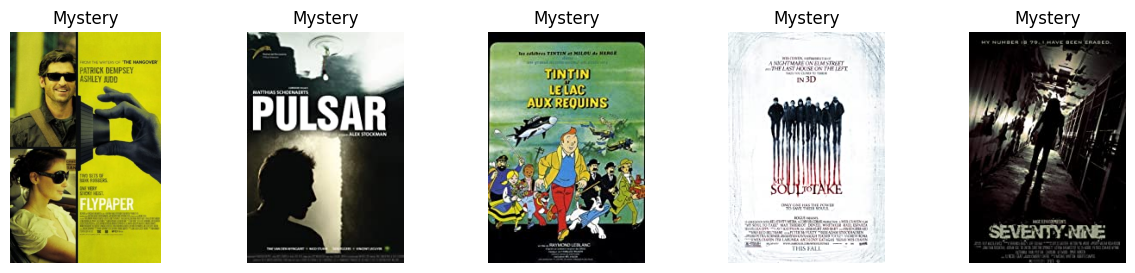

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def show_sample_images(split="Posters_Train", genre="Comedy", n=5):
    genre_path = os.path.join(dataset_path, split, genre)
    image_files = [f for f in os.listdir(genre_path) if f.endswith(".jpg")]
    sample_files = random.sample(image_files, min(n, len(image_files)))

    plt.figure(figsize=(15, 3))
    for i, fname in enumerate(sample_files):
        img = Image.open(os.path.join(genre_path, fname))
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"{genre}")
        plt.axis("off")
    plt.show()

# Example usage:
show_sample_images("Posters_Train", "Mystery", n=5)

In [ ]:
# === Build multi-label mapping dictionary === (Addition)
from collections import defaultdict

# Create mapping: relative image path (split/filename.jpg) -> set of genres
image_to_genres = defaultdict(set)

for split in ['Posters_Train', 'Posters_Validation']:
    split_path = os.path.join(dataset_path, split)
    for genre in sorted(os.listdir(split_path)):
        genre_path = os.path.join(split_path, genre)
        if not os.path.isdir(genre_path):
            continue
        for fname in os.listdir(genre_path):
            if fname.lower().endswith(".jpg"):
                rel_path = os.path.join(split, fname)
                image_to_genres[rel_path].add(genre)

print(f"Found {len(image_to_genres)} images with genre annotations.")


Found 41108 images with genre annotations.


In [ ]:
import pandas as pd #Addition

# Get sorted list of all genres (consistent column order)
all_genres = sorted({genre for genres in image_to_genres.values() for genre in genres})

# Convert to list of dicts
rows = []
for rel_path, genres in image_to_genres.items():
    row = {"image_path": os.path.join(dataset_path, rel_path)}
    for genre in all_genres:
        row[genre] = int(genre in genres)  # multi-hot encoding
    rows.append(row)

df = pd.DataFrame(rows)
df.head()


image_path  Action  Adventure  \
0  /root/.cache/kagglehub/datasets/lovesunkyu/mov...       1          1   
1  /root/.cache/kagglehub/datasets/lovesunkyu/mov...       1          0   
2  /root/.cache/kagglehub/datasets/lovesunkyu/mov...       1          0   
3  /root/.cache/kagglehub/datasets/lovesunkyu/mov...       1          1   
4  /root/.cache/kagglehub/datasets/lovesunkyu/mov...       1          0   

   Animation  Biography  Comedy  Crime  Documentary  Drama  Family  Fantasy  \
0          0          0       0      0            0      0       0        0   
1          0          0       0      0            0      0       0        0   
2          0          0       0      0            0      0       0        0   
3          0          0       0      0            0      0       0        0   
4          0          0       0      0            0      0       0        0   

   History  Horror  Music  Mystery  Romance  Sci-Fi  Sport  Thriller  War  
0        0       0      0        0        0       1      0         0    0  
1        0       0      0        0        0       0      0         0    0  
2        0       0      0        0        0       0      0         0    0  
3        0       0      0        0        0       0      0         0    0  
4        0       0      0        0        0       0      0         1    0

#Dataset Preparation & Splitting

In [ ]:
#Imports
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset

In [ ]:
#Define transforms

IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),                  # Resize all images
    transforms.RandomHorizontalFlip(p=0.5),         # Flip 50% of the time
    transforms.RandomRotation(degrees=15),          # Rotate up to ±15 degrees
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),                # Change color properties
    transforms.RandomAffine(degrees=0,
                            translate=(0.1, 0.1),
                            scale=(0.9, 1.1)),       # Slight scale and shift
    transforms.ToTensor(),                          # Convert to tensor
    transforms.Normalize([0.5]*3, [0.5]*3)           # Normalize to [-1, 1]
])


val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

#Creation of one-hot encoded image feature vectors

In [ ]:
import os
from collections import defaultdict


# Combine both train and validation folders
folders = [
    os.path.join(dataset_path, "Posters_Train"),
    os.path.join(dataset_path, "Posters_Validation")
]

seen = defaultdict(list)  # filename -> list of genre folders

# Check for duplicates
for root_folder in folders:
    for genre in os.listdir(root_folder):
        genre_path = os.path.join(root_folder, genre)
        if not os.path.isdir(genre_path):
            continue

        for fname in os.listdir(genre_path):
            if not fname.endswith(".jpg"):
                continue

            seen[fname].append(genre)

            if len(seen[fname]) > 1:
                print(f"🟡 Found duplicate poster: {fname}")
                print(f"Appears in genres: {seen[fname]}")
                break
        else:
            continue  # no duplicate found, go to next genre
        break  # break if duplicate found
    else:
        continue
    break


🟡 Found duplicate poster: tt0315824.jpg
Appears in genres: ['Crime', 'Comedy']


In [ ]:
import os
from collections import defaultdict

# Use the correct dataset path from kagglehub
dataset_path = "/root/.cache/kagglehub/datasets/lovesunkyu/movie-posters-by-genre/versions/3/Posters"

folders = [
    os.path.join(dataset_path, "Posters_Train"),
    os.path.join(dataset_path, "Posters_Validation")
]

image_to_genres = defaultdict(list)

for root_folder in folders:
    for genre in os.listdir(root_folder):
        genre_path = os.path.join(root_folder, genre)
        if not os.path.isdir(genre_path):
            continue

        for fname in os.listdir(genre_path):
            if fname.endswith(".jpg"):
                image_to_genres[fname].append(genre)

             # Immediately deduplicate in-place (EfeT)
            image_to_genres[fname] = list(set(image_to_genres[fname]))

# Show a few results
sample_labels = list(image_to_genres.items())[:5]
for fname, genres in sample_labels:
    print(f"{fname}: {genres}")

tt0107808.jpg: ['Drama', 'Crime', 'Thriller']
tt0443706.jpg: ['History', 'Drama', 'Crime']
tt1334470.jpg: ['Action', 'Adventure', 'Crime']
tt0315824.jpg: ['Comedy', 'Crime']
tt1001562.jpg: ['Comedy', 'Crime']


In [ ]:
# Step 2: Create one-hot encoding for each image based on genres

# 1. Get all unique genres
all_genres = sorted(set(g for genres in image_to_genres.values() for g in genres))
genre_to_index = {genre: idx for idx, genre in enumerate(all_genres)}

# 2. Map each filename to a one-hot encoded genre vector
image_to_onehot = {}

for fname, genres in image_to_genres.items():
    one_hot = [0] * len(all_genres)
    for g in set(genres):  # remove duplicates
        one_hot[genre_to_index[g]] = 1
    image_to_onehot[fname] = one_hot



# 3. Show results with genre labels
for i, (f, vec) in enumerate(image_to_onehot.items()):
    active_genres = [genre for genre, idx in genre_to_index.items() if vec[idx] == 1]
    print(f"\n🎬 {f}")
    print(f"✔ Genres: {active_genres}")
    print(f"🔢 One-hot: {vec}")
    if i == 4: break


🎬 tt0107808.jpg
✔ Genres: ['Crime', 'Drama', 'Thriller']
🔢 One-hot: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

🎬 tt0443706.jpg
✔ Genres: ['Crime', 'Drama', 'History']
🔢 One-hot: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

🎬 tt1334470.jpg
✔ Genres: ['Action', 'Adventure', 'Crime']
🔢 One-hot: [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

🎬 tt0315824.jpg
✔ Genres: ['Comedy', 'Crime']
🔢 One-hot: [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

🎬 tt1001562.jpg
✔ Genres: ['Comedy', 'Crime']
🔢 One-hot: [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print("🎯 One-Hot Vector Genre Order:")
print(all_genres)

🎯 One-Hot Vector Genre Order:
['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War']


In [ ]:
from collections import defaultdict #Addition
import os

image_to_genres = defaultdict(list)

folders = [
    os.path.join(dataset_path, "Posters_Train"),
    os.path.join(dataset_path, "Posters_Validation")
]

for root_folder in folders:
    for genre in os.listdir(root_folder):
        if not os.path.isdir(os.path.join(root_folder, genre)) or genre.startswith("."):
            continue

        genre_path = os.path.join(root_folder, genre)
        for fname in os.listdir(genre_path):
            if fname.endswith(".jpg"):
                image_to_genres[fname].append(genre)

# Optional: enforce uniqueness
for fname in image_to_genres:
    image_to_genres[fname] = list(set(image_to_genres[fname]))


In [ ]:
# One-hot encoding #Addition
all_genres = sorted(set(g for genres in image_to_genres.values() for g in genres))
genre_to_index = {genre: idx for idx, genre in enumerate(all_genres)}

image_to_onehot = {}
for fname, genres in image_to_genres.items():
    vec = [0] * len(all_genres)
    for g in genres:
        vec[genre_to_index[g]] = 1
    image_to_onehot[fname] = vec


In [ ]:
import pandas as pd

# Convert to DataFrame
df_labels = pd.DataFrame.from_dict(image_to_onehot, orient='index', columns=all_genres)

# Move filenames into a column
df_labels.reset_index(inplace=True)
df_labels.rename(columns={"index": "filename"}, inplace=True)

# Save to CSV
df_labels.to_csv("multilabel_posters.csv", index=False)

print("✅ Saved to multilabel_posters.csv")

✅ Saved to multilabel_posters.csv


#Split and make the dataset from scratch

In [ ]:
import os
import shutil

flat_folder = "/kaggle/working/Posters_Flat"
os.makedirs(flat_folder, exist_ok=True)

folders = [
    os.path.join(dataset_path, "Posters_Train"),
    os.path.join(dataset_path, "Posters_Validation")
]

seen = set()
for root_folder in folders:
    for genre in os.listdir(root_folder):
        genre_path = os.path.join(root_folder, genre)
        for fname in os.listdir(genre_path):
            if fname.endswith(".jpg") and fname not in seen:
                src = os.path.join(genre_path, fname)
                dst = os.path.join(flat_folder, fname)
                shutil.copy2(src, dst)
                seen.add(fname)

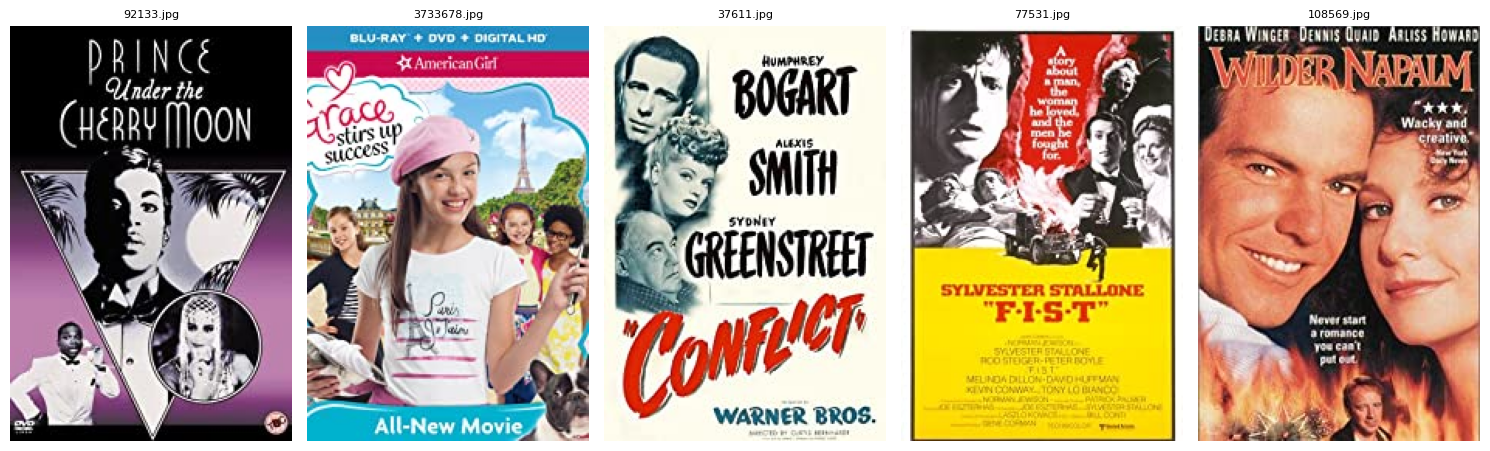

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

flat_folder = "/kaggle/working/Posters_Flat"
all_files = [f for f in os.listdir(flat_folder) if f.endswith(".jpg")]

# Pick 5 random ones
random_files = random.sample(all_files, 5)

plt.figure(figsize=(15, 5))
for i, fname in enumerate(random_files):
    img_path = os.path.join(flat_folder, fname)
    img = Image.open(img_path)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(fname, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Load your label dataframe
df = pd.read_csv("multilabel_posters.csv")

# Only keep files that exist in the flat folder
flat_folder = "/kaggle/working/Posters_Flat"
existing_files = set(os.listdir(flat_folder))
df = df[df["filename"].isin(existing_files)].reset_index(drop=True)

# Split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.33, random_state=42)  # 0.33 of 30% → 10%

# Save
train_df.to_csv("train_labels.csv", index=False)
val_df.to_csv("val_labels.csv", index=False)
test_df.to_csv("test_labels.csv", index=False)

print("✅ Dataset split complete.")
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

✅ Dataset split complete.
Train: 23720, Val: 6811, Test: 3356


In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import torch
import os

IMG_SIZE = 224
flat_folder = "/kaggle/working/Posters_Flat"

# Augmentations
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [ ]:
class PosterDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
        self.labels = self.data.drop(columns=["filename"]).values
        self.filenames = self.data["filename"].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.filenames[idx])
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
BATCH_SIZE = 32

train_set = PosterDataset("train_labels.csv", flat_folder, transform=train_transform)
val_set   = PosterDataset("val_labels.csv", flat_folder, transform=val_test_transform)
test_set  = PosterDataset("test_labels.csv", flat_folder, transform=val_test_transform)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

#Data Inspection After Reshaping the Dataset

In [ ]:
print("Train size:", len(train_set))
print("Validation size:", len(val_set))
print("Test size:", len(test_set))

Train size: 23720
Validation size: 6811
Test size: 3356


In [ ]:
img, label = train_set[0]
print("Image shape:", img.shape)
print("Label index:", label)

Image shape: torch.Size([3, 224, 224])
Label index: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


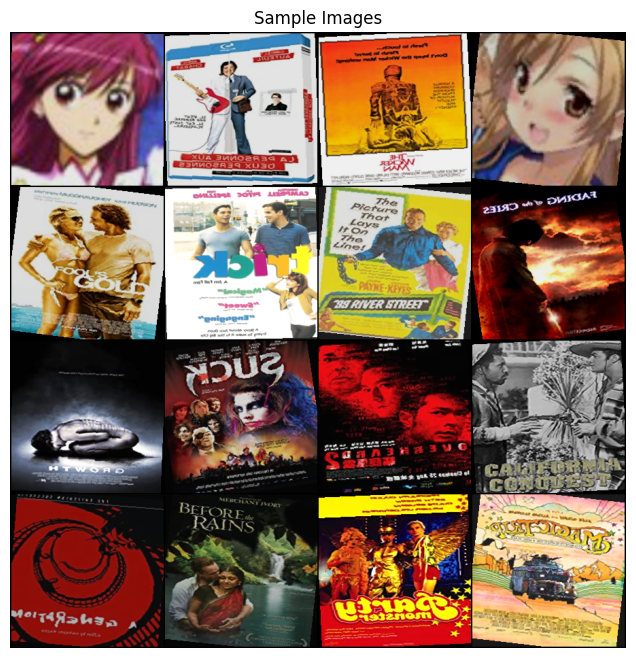

In [ ]:
import matplotlib.pyplot as plt
import torchvision

def show_sample_batch(dataset, n=16):
    imgs = [dataset[i][0] for i in range(n)]
    labels = [dataset[i][1] for i in range(n)]

    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)

    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title("Sample Images")
    plt.show()

show_sample_batch(train_set)

#Implementation of ResNet-50
Model created here

In [ ]:
#Import libraries
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

In [ ]:
import pandas as pd

# Load the label CSV just to get number of genres
label_df = pd.read_csv("train_labels.csv")
NUM_CLASSES = label_df.shape[1] - 1  # exclude 'filename' column

print("Number of genre classes:", NUM_CLASSES)

Number of genre classes: 19


In [ ]:
#resnet50 = models.resnet50(pretrained=True)
from torchvision.models import resnet50, ResNet50_Weights  #Addition, replaced that with this
resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)


# Freeze feature extractor (optional, can be unfrozen later)
for param in resnet50.parameters():
    param.requires_grad = True # CHANGED THIS ONE TO TRUE (ADDITION)

# Replace classifier head with multi-label output
resnet50.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(resnet50.fc.in_features, NUM_CLASSES)  # output logits
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 87.6MB/s]


In [ ]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)  # move model to device

# Now call summary with the device
summary(resnet50, input_size=(3, 224, 224), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
#ADDITION, REPLACED THIS CODE ABOVE WITH THIS TO SEE

from torchsummary import summary
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute pos_weight from training labels
import pandas as pd
df = pd.read_csv("train_labels.csv")
genre_labels = df.columns.tolist()[1:]
label_counts = df[genre_labels].sum(axis=0)

#pos_weights = (1.0 / (label_counts + 1e-6)) #THIS DIDN'T WORK, just gave 0 for all the weights too small maybe ADDITION
pos_weights = label_counts.max() / (label_counts + 1e-6)

pos_weights = torch.tensor(pos_weights.values, dtype=torch.float32).to(device)

# Model setup
import torchvision.models as models
import torch.nn as nn

resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in resnet50.parameters():
    param.requires_grad = True  # fine-tune full model

# Replace classifier head
NUM_CLASSES = len(genre_labels)
resnet50.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(resnet50.fc.in_features, NUM_CLASSES)
)

resnet50 = resnet50.to(device)

# Loss function with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

# Optimizer
import torch.optim as optim
optimizer = optim.Adam(resnet50.parameters(), lr=1e-5)
# Now call summary with the device
summary(resnet50, input_size=(3, 224, 224), device=str(device))
for genre, weight in zip(genre_labels, pos_weights.tolist()):
    print(f"{genre:12} → weight: {weight:.2f}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# ADDITION AGAIN FOR THE ABOVE CODE, NOT DELETING IN CASE IT DOESN'T WORK

from torchsummary import summary
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute pos_weight from training labels
import pandas as pd
df = pd.read_csv("train_labels.csv")
genre_labels = df.columns.tolist()[1:]
label_counts = df[genre_labels].sum(axis=0)

#pos_weights = (1.0 / (label_counts + 1e-6)) #THIS DIDN'T WORK, just gave 0 for all the weights too small maybe ADDITION
pos_weights = label_counts.max() / (label_counts + 1e-6)

pos_weights = torch.tensor(pos_weights.values, dtype=torch.float32).to(device)

# === BASELINE MODEL ===
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

baseline_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in baseline_model.parameters():
    param.requires_grad = True

NUM_CLASSES = len(genre_labels)
baseline_model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(baseline_model.fc.in_features, NUM_CLASSES)
)
baseline_model = baseline_model.to(device)

baseline_criterion = nn.BCEWithLogitsLoss()
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=1e-4)

# === BALANCED MODEL ===

# pos_weight calculation
pos_weights = label_counts.max() / (label_counts + 1e-6)
pos_weights = torch.tensor(pos_weights.values, dtype=torch.float32).to(device)

balanced_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in balanced_model.parameters():
    param.requires_grad = True

balanced_model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(balanced_model.fc.in_features, NUM_CLASSES)
)
balanced_model = balanced_model.to(device)

balanced_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
balanced_optimizer = optim.Adam(balanced_model.parameters(), lr=1e-5)
from torch.optim.lr_scheduler import StepLR

# Step down LR every 15 epochs by half
balanced_scheduler = StepLR(balanced_optimizer, step_size=25, gamma=0.5)



#Apply the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    loop = tqdm(dataloader, desc="Training", leave=False)

    for images, targets in loop:
        images = images.to(device)
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Update progress bar description dynamically
        loop.set_postfix(batch_loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [ ]:
from sklearn.metrics import f1_score #changec the eval function ADDITION

def evaluate(model, dataloader, criterion, device, threshold=0.5):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device).float()

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    val_loss = running_loss / len(dataloader.dataset)
    y_pred = (np.vstack(all_preds) >= threshold).astype(int)
    y_true = np.vstack(all_labels)
    f1 = f1_score(y_true, y_pred, average="samples")

    return val_loss, f1


#Run this to train ResNet50

#BASELINE MODEL for Resnet50

This is the default version for the Resnet50, we have to realize that we have an imbalanced dataset, so we will try to consider that later on with pos_weights. Right now, we expect smaller F1 values for the rarer genres.

In [ ]:
# === TRAIN BASELINE MODEL ===
EPOCHS = 50
baseline_train_losses = []
baseline_val_losses = []
baseline_f1s = []

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(baseline_model, train_loader, baseline_optimizer, baseline_criterion, device)
    val_loss, val_f1 = evaluate(baseline_model, val_loader, baseline_criterion, device)

    baseline_train_losses.append(train_loss)
    baseline_val_losses.append(val_loss)
    baseline_f1s.append(val_f1)

    print(f"[BASELINE] Epoch {epoch+1}/{EPOCHS} → Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")


[BASELINE] Epoch 1/50 → Train Loss: 0.2620 | Val Loss: 0.2328 | Val F1: 0.2432


[BASELINE] Epoch 2/50 → Train Loss: 0.2236 | Val Loss: 0.2241 | Val F1: 0.2868


[BASELINE] Epoch 3/50 → Train Loss: 0.2043 | Val Loss: 0.2217 | Val F1: 0.3097


[BASELINE] Epoch 4/50 → Train Loss: 0.1839 | Val Loss: 0.2239 | Val F1: 0.3537


[BASELINE] Epoch 5/50 → Train Loss: 0.1622 | Val Loss: 0.2341 | Val F1: 0.3598


[BASELINE] Epoch 6/50 → Train Loss: 0.1409 | Val Loss: 0.2417 | Val F1: 0.3831


[BASELINE] Epoch 7/50 → Train Loss: 0.1214 | Val Loss: 0.2547 | Val F1: 0.3835


[BASELINE] Epoch 8/50 → Train Loss: 0.1025 | Val Loss: 0.2700 | Val F1: 0.3962


[BASELINE] Epoch 9/50 → Train Loss: 0.0874 | Val Loss: 0.2926 | Val F1: 0.4035


[BASELINE] Epoch 10/50 → Train Loss: 0.0738 | Val Loss: 0.3009 | Val F1: 0.4115


[BASELINE] Epoch 11/50 → Train Loss: 0.0630 | Val Loss: 0.3181 | Val F1: 0.3946


[BASELINE] Epoch 12/50 → Train Loss: 0.0529 | Val Loss: 0.3315 | Val F1: 0.4185


[BASELINE] Epoch 13/50 → Train Loss: 0.0475 | Val Loss: 0.3414 | Val F1: 0.4073


[BASELINE] Epoch 14/50 → Train Loss: 0.0424 | Val Loss: 0.3580 | Val F1: 0.4160


[BASELINE] Epoch 15/50 → Train Loss: 0.0378 | Val Loss: 0.3714 | Val F1: 0.4008


[BASELINE] Epoch 16/50 → Train Loss: 0.0352 | Val Loss: 0.3788 | Val F1: 0.4088


[BASELINE] Epoch 17/50 → Train Loss: 0.0315 | Val Loss: 0.3912 | Val F1: 0.4096


[BASELINE] Epoch 18/50 → Train Loss: 0.0296 | Val Loss: 0.4051 | Val F1: 0.4183


[BASELINE] Epoch 19/50 → Train Loss: 0.0272 | Val Loss: 0.4057 | Val F1: 0.4090


[BASELINE] Epoch 20/50 → Train Loss: 0.0265 | Val Loss: 0.4150 | Val F1: 0.4029


[BASELINE] Epoch 21/50 → Train Loss: 0.0252 | Val Loss: 0.4168 | Val F1: 0.4041


[BASELINE] Epoch 22/50 → Train Loss: 0.0237 | Val Loss: 0.4308 | Val F1: 0.4084


[BASELINE] Epoch 23/50 → Train Loss: 0.0227 | Val Loss: 0.4437 | Val F1: 0.4023


[BASELINE] Epoch 24/50 → Train Loss: 0.0216 | Val Loss: 0.4314 | Val F1: 0.4096


[BASELINE] Epoch 25/50 → Train Loss: 0.0207 | Val Loss: 0.4476 | Val F1: 0.4037


[BASELINE] Epoch 26/50 → Train Loss: 0.0204 | Val Loss: 0.4420 | Val F1: 0.4084


[BASELINE] Epoch 27/50 → Train Loss: 0.0183 | Val Loss: 0.4493 | Val F1: 0.4080


[BASELINE] Epoch 28/50 → Train Loss: 0.0179 | Val Loss: 0.4553 | Val F1: 0.4089


[BASELINE] Epoch 29/50 → Train Loss: 0.0178 | Val Loss: 0.4447 | Val F1: 0.4098


[BASELINE] Epoch 30/50 → Train Loss: 0.0163 | Val Loss: 0.4626 | Val F1: 0.4068


[BASELINE] Epoch 31/50 → Train Loss: 0.0172 | Val Loss: 0.4623 | Val F1: 0.4095


[BASELINE] Epoch 32/50 → Train Loss: 0.0161 | Val Loss: 0.4619 | Val F1: 0.4080


[BASELINE] Epoch 33/50 → Train Loss: 0.0155 | Val Loss: 0.4782 | Val F1: 0.4115


[BASELINE] Epoch 34/50 → Train Loss: 0.0152 | Val Loss: 0.4750 | Val F1: 0.4019


[BASELINE] Epoch 35/50 → Train Loss: 0.0138 | Val Loss: 0.4895 | Val F1: 0.4009


[BASELINE] Epoch 36/50 → Train Loss: 0.0141 | Val Loss: 0.4832 | Val F1: 0.4020


[BASELINE] Epoch 37/50 → Train Loss: 0.0140 | Val Loss: 0.4890 | Val F1: 0.4073


[BASELINE] Epoch 38/50 → Train Loss: 0.0132 | Val Loss: 0.4889 | Val F1: 0.4057


[BASELINE] Epoch 39/50 → Train Loss: 0.0129 | Val Loss: 0.4803 | Val F1: 0.4059


[BASELINE] Epoch 40/50 → Train Loss: 0.0128 | Val Loss: 0.4911 | Val F1: 0.3986


[BASELINE] Epoch 41/50 → Train Loss: 0.0122 | Val Loss: 0.4905 | Val F1: 0.4092


[BASELINE] Epoch 42/50 → Train Loss: 0.0122 | Val Loss: 0.4947 | Val F1: 0.4000


[BASELINE] Epoch 43/50 → Train Loss: 0.0124 | Val Loss: 0.4853 | Val F1: 0.4054


[BASELINE] Epoch 44/50 → Train Loss: 0.0112 | Val Loss: 0.4952 | Val F1: 0.3984


[BASELINE] Epoch 45/50 → Train Loss: 0.0116 | Val Loss: 0.5109 | Val F1: 0.3926


[BASELINE] Epoch 46/50 → Train Loss: 0.0118 | Val Loss: 0.5050 | Val F1: 0.4013


[BASELINE] Epoch 47/50 → Train Loss: 0.0107 | Val Loss: 0.5151 | Val F1: 0.3943


[BASELINE] Epoch 48/50 → Train Loss: 0.0108 | Val Loss: 0.5090 | Val F1: 0.4076


[BASELINE] Epoch 49/50 → Train Loss: 0.0107 | Val Loss: 0.5128 | Val F1: 0.3991


[BASELINE] Epoch 50/50 → Train Loss: 0.0105 | Val Loss: 0.5010 | Val F1: 0.4078


**Best Run for the Baseline Resnet50** - We realize that the model sort of plataeus after the epoch 12 in terms of F1 scores, the validation loss of course gets worse as well. Considering the computational cost and time, and the lack of improvement we take the baseline model as a simple 12 epoch simulation

In [ ]:
#AGAIN FOR 12 EPOCHS now. #ADDITION
# === TRAIN BASELINE MODEL ===
EPOCHS = 12
baseline_train_losses = []
baseline_val_losses = []
baseline_f1s = []

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(baseline_model, train_loader, baseline_optimizer, baseline_criterion, device)
    val_loss, val_f1 = evaluate(baseline_model, val_loader, baseline_criterion, device)

    baseline_train_losses.append(train_loss)
    baseline_val_losses.append(val_loss)
    baseline_f1s.append(val_f1)

    print(f"[BASELINE] Epoch {epoch+1}/{EPOCHS} → Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

# ✅ Save model checkpoint
torch.save(baseline_model.state_dict(), "baseline_model_epoch12.pth")

# ✅ Save training curves as CSV
import pandas as pd
df_logs = pd.DataFrame({
    "train_loss": baseline_train_losses,
    "val_loss": baseline_val_losses,
    "val_f1": baseline_f1s
})
df_logs.to_csv("baseline_logs_epoch12.csv", index=False)

print("✅ Model and logs saved!")


[BASELINE] Epoch 1/12 → Train Loss: 0.2450 | Val Loss: 0.2286 | Val F1: 0.2333


[BASELINE] Epoch 2/12 → Train Loss: 0.2198 | Val Loss: 0.2213 | Val F1: 0.2771


[BASELINE] Epoch 3/12 → Train Loss: 0.2009 | Val Loss: 0.2192 | Val F1: 0.3201


[BASELINE] Epoch 4/12 → Train Loss: 0.1802 | Val Loss: 0.2244 | Val F1: 0.3373


[BASELINE] Epoch 5/12 → Train Loss: 0.1590 | Val Loss: 0.2283 | Val F1: 0.3627


[BASELINE] Epoch 6/12 → Train Loss: 0.1367 | Val Loss: 0.2416 | Val F1: 0.3815


[BASELINE] Epoch 7/12 → Train Loss: 0.1177 | Val Loss: 0.2483 | Val F1: 0.3880


[BASELINE] Epoch 8/12 → Train Loss: 0.0985 | Val Loss: 0.2759 | Val F1: 0.3992


[BASELINE] Epoch 9/12 → Train Loss: 0.0833 | Val Loss: 0.2863 | Val F1: 0.3910


[BASELINE] Epoch 10/12 → Train Loss: 0.0708 | Val Loss: 0.3044 | Val F1: 0.4020


[BASELINE] Epoch 11/12 → Train Loss: 0.0601 | Val Loss: 0.3116 | Val F1: 0.4111


[BASELINE] Epoch 12/12 → Train Loss: 0.0515 | Val Loss: 0.3252 | Val F1: 0.4119
✅ Model and logs saved!


**Criteria** - We see the epoch results, but we want to see the report in more detail so we get the values for all the genres in more detail with this prediction.

In [ ]:
from sklearn.metrics import classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_predictions(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.cpu().numpy()
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()

            all_labels.extend(labels)
            all_preds.extend(preds)

    return np.array(all_labels), np.array(all_preds)
def binarize_predictions(preds, threshold=0.5):
    return (preds >= threshold).astype(int)
import pandas as pd                                        #changed this
from sklearn.metrics import classification_report

# Confirm it looks right
print("Genre labels:", genre_labels)

# Step 1: Get model predictions
y_true_raw, y_pred_raw = get_predictions(baseline_model, val_loader, device)

# Step 2: Binarize the outputs
y_true = y_true_raw
y_pred = binarize_predictions(y_pred_raw, threshold=0.5)

# Step 3: Load genre names
df = pd.read_csv("train_labels.csv")  # or multilabel_posters.csv
genre_labels = df.columns.tolist()[1:]

# Step 4: Show report
print(classification_report(y_true, y_pred, target_names=genre_labels, zero_division=0))

# Print classification report
print(classification_report(y_true, y_pred, target_names=genre_labels, zero_division=0))

Genre labels: ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War']
              precision    recall  f1-score   support

      Action       0.64      0.52      0.58      1254
   Adventure       0.55      0.40      0.47       891
   Animation       0.91      0.77      0.83       562
   Biography       0.43      0.31      0.36       453
      Comedy       0.64      0.57      0.60      1085
       Crime       0.40      0.22      0.28       263
 Documentary       0.53      0.49      0.51       824
       Drama       0.61      0.49      0.54      1508
      Family       0.57      0.29      0.39       452
     Fantasy       0.52      0.21      0.30       480
     History       0.28      0.21      0.24       307
      Horror       0.61      0.46      0.53       859
       Music       0.36      0.30      0.33       463
     Mystery       0.40  

In [ ]:
# Save trained baseline model
torch.save(baseline_model.state_dict(), "baseline_model_epoch12.pth")
print("✅ Baseline model saved as baseline_model_epoch12.pth")


✅ Baseline model saved as baseline_model_epoch12.pth


In [ ]:
# To reload:
model = models.resnet50(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, NUM_CLASSES)
)
model.load_state_dict(torch.load("baseline_model_epoch12.pth"))
model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<ipython-input-48-fdc98f317c99>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_f1, x="F1 Score", y="Genre", palette="viridis")


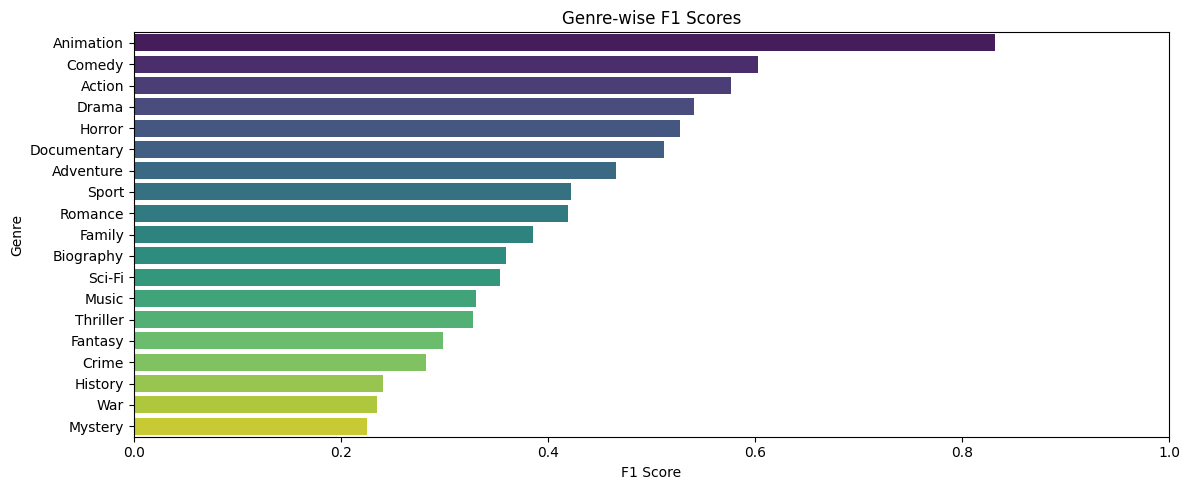

In [ ]:
from sklearn.metrics import f1_score

f1_per_class = f1_score(y_true, y_pred, average=None)
df_f1 = pd.DataFrame({
    'Genre': genre_labels,
    'F1 Score': f1_per_class
}).sort_values("F1 Score", ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(data=df_f1, x="F1 Score", y="Genre", palette="viridis")
plt.title("Genre-wise F1 Scores")
plt.xlabel("F1 Score")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


**Threshold Tuning** - For the predictions, ideally we can't really use 0.5 threshold for all genres, since its an imbalanced dataset, we have to consider that aspect so we try to tune accordingly

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

def find_best_thresholds(y_true, y_probs, thresholds=np.linspace(0.1, 0.9, 17)):
    best_thresholds = []
    for i in range(y_true.shape[1]):
        best_f1 = 0
        best_t = 0.5
        for t in thresholds:
            f1 = f1_score(y_true[:, i], (y_probs[:, i] >= t).astype(int), zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t
        best_thresholds.append(best_t)
    return np.array(best_thresholds)


In [ ]:
# Step 1: Get raw predictions
y_true_raw, y_probs_raw = get_predictions(baseline_model, val_loader, device)

# Step 2: Find best per-class thresholds
best_thresholds = find_best_thresholds(y_true_raw, y_probs_raw)

# Step 3: Binarize using tuned thresholds
y_pred_tuned = (y_probs_raw >= best_thresholds).astype(int)


In [ ]:
# Step 1: Get raw predictions
y_true_raw, y_probs_raw = get_predictions(baseline_model, val_loader, device)

# Step 2: Find best per-class thresholds
best_thresholds = find_best_thresholds(y_true_raw, y_probs_raw)

# Step 3: Binarize using tuned thresholds
y_pred_tuned = (y_probs_raw >= best_thresholds).astype(int)
from sklearn.metrics import classification_report

print(classification_report(y_true_raw, y_pred_tuned, target_names=genre_labels, zero_division=0))


              precision    recall  f1-score   support

      Action       0.57      0.61      0.59      1254
   Adventure       0.47      0.47      0.47       891
   Animation       0.92      0.75      0.83       562
   Biography       0.39      0.33      0.36       453
      Comedy       0.62      0.57      0.59      1085
       Crime       0.33      0.38      0.35       263
 Documentary       0.51      0.53      0.52       824
       Drama       0.53      0.63      0.58      1508
      Family       0.43      0.42      0.42       452
     Fantasy       0.29      0.31      0.30       480
     History       0.23      0.27      0.25       307
      Horror       0.56      0.55      0.55       859
       Music       0.33      0.28      0.31       463
     Mystery       0.34      0.25      0.29       535
     Romance       0.38      0.46      0.42       301
      Sci-Fi       0.43      0.34      0.38       450
       Sport       0.53      0.34      0.41       180
    Thriller       0.36    

**Tuned Results** - Here we see in the predictions a solid increase in the results, we have more balanced and better results for the genres, this is the result of our best baseline model.

In [ ]:
# Print each genre's optimal threshold
for genre, thr in zip(genre_labels, best_thresholds):
    print(f"{genre:12} → threshold: {thr:.2f}")


Action       → threshold: 0.10
Adventure    → threshold: 0.10
Animation    → threshold: 0.65
Biography    → threshold: 0.55
Comedy       → threshold: 0.50
Crime        → threshold: 0.20
Documentary  → threshold: 0.20
Drama        → threshold: 0.30
Family       → threshold: 0.15
Fantasy      → threshold: 0.20
History      → threshold: 0.15
Horror       → threshold: 0.15
Music        → threshold: 0.20
Mystery      → threshold: 0.20
Romance      → threshold: 0.10
Sci-Fi       → threshold: 0.20
Sport        → threshold: 0.50
Thriller     → threshold: 0.15
War          → threshold: 0.25


In [ ]:
np.save("best_thresholds.npy", best_thresholds)

In [ ]:
thresholds = np.load("best_thresholds.npy")

#Balanced Model for Resnet50(Pos_weights)

Now obviously we want a more balanced output, instead of having too much imbalanced results, in the initial baseline runs we had, we were reaching like 0.01 F1 values for the rare genres.

We ran it like this for 50 epochs.

In [ ]:
# === TRAIN BALANCED MODEL ===
balanced_train_losses = []
balanced_val_losses = []
balanced_f1s = []

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(balanced_model, train_loader, balanced_optimizer, balanced_criterion, device)
    val_loss, val_f1 = evaluate(balanced_model, val_loader, balanced_criterion, device)

    balanced_train_losses.append(train_loss)
    balanced_val_losses.append(val_loss)
    balanced_f1s.append(val_f1)

    print(f"[BALANCED] Epoch {epoch+1}/{EPOCHS} → Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")


    if balanced_scheduler: #scheduler
        balanced_scheduler.step()


[BALANCED] Epoch 1/50 → Train Loss: 0.5842 | Val Loss: 0.5114 | Val F1: 0.0420


[BALANCED] Epoch 2/50 → Train Loss: 0.4928 | Val Loss: 0.4676 | Val F1: 0.1332


[BALANCED] Epoch 3/50 → Train Loss: 0.4603 | Val Loss: 0.4488 | Val F1: 0.1945


[BALANCED] Epoch 4/50 → Train Loss: 0.4415 | Val Loss: 0.4376 | Val F1: 0.2354


[BALANCED] Epoch 5/50 → Train Loss: 0.4276 | Val Loss: 0.4299 | Val F1: 0.2671


[BALANCED] Epoch 6/50 → Train Loss: 0.4134 | Val Loss: 0.4247 | Val F1: 0.2843


[BALANCED] Epoch 7/50 → Train Loss: 0.4017 | Val Loss: 0.4206 | Val F1: 0.2966


[BALANCED] Epoch 8/50 → Train Loss: 0.3892 | Val Loss: 0.4177 | Val F1: 0.3089


[BALANCED] Epoch 9/50 → Train Loss: 0.3778 | Val Loss: 0.4166 | Val F1: 0.3174


[BALANCED] Epoch 10/50 → Train Loss: 0.3659 | Val Loss: 0.4160 | Val F1: 0.3283


[BALANCED] Epoch 11/50 → Train Loss: 0.3556 | Val Loss: 0.4147 | Val F1: 0.3386


[BALANCED] Epoch 12/50 → Train Loss: 0.3435 | Val Loss: 0.4175 | Val F1: 0.3381


[BALANCED] Epoch 13/50 → Train Loss: 0.3329 | Val Loss: 0.4185 | Val F1: 0.3489


[BALANCED] Epoch 14/50 → Train Loss: 0.3211 | Val Loss: 0.4224 | Val F1: 0.3442


[BALANCED] Epoch 15/50 → Train Loss: 0.3103 | Val Loss: 0.4233 | Val F1: 0.3467


[BALANCED] Epoch 16/50 → Train Loss: 0.2998 | Val Loss: 0.4312 | Val F1: 0.3528


[BALANCED] Epoch 17/50 → Train Loss: 0.2897 | Val Loss: 0.4370 | Val F1: 0.3628


[BALANCED] Epoch 18/50 → Train Loss: 0.2783 | Val Loss: 0.4410 | Val F1: 0.3567


[BALANCED] Epoch 19/50 → Train Loss: 0.2680 | Val Loss: 0.4465 | Val F1: 0.3646


[BALANCED] Epoch 20/50 → Train Loss: 0.2587 | Val Loss: 0.4551 | Val F1: 0.3694


[BALANCED] Epoch 21/50 → Train Loss: 0.2491 | Val Loss: 0.4584 | Val F1: 0.3712


[BALANCED] Epoch 22/50 → Train Loss: 0.2389 | Val Loss: 0.4748 | Val F1: 0.3694


[BALANCED] Epoch 23/50 → Train Loss: 0.2308 | Val Loss: 0.4777 | Val F1: 0.3694


[BALANCED] Epoch 24/50 → Train Loss: 0.2213 | Val Loss: 0.4948 | Val F1: 0.3628


[BALANCED] Epoch 25/50 → Train Loss: 0.2132 | Val Loss: 0.4964 | Val F1: 0.3728


[BALANCED] Epoch 26/50 → Train Loss: 0.2020 | Val Loss: 0.5100 | Val F1: 0.3735


[BALANCED] Epoch 27/50 → Train Loss: 0.1980 | Val Loss: 0.5081 | Val F1: 0.3776


[BALANCED] Epoch 28/50 → Train Loss: 0.1932 | Val Loss: 0.5105 | Val F1: 0.3812


[BALANCED] Epoch 29/50 → Train Loss: 0.1894 | Val Loss: 0.5188 | Val F1: 0.3780


[BALANCED] Epoch 30/50 → Train Loss: 0.1854 | Val Loss: 0.5264 | Val F1: 0.3777


[BALANCED] Epoch 31/50 → Train Loss: 0.1809 | Val Loss: 0.5327 | Val F1: 0.3755


[BALANCED] Epoch 32/50 → Train Loss: 0.1773 | Val Loss: 0.5342 | Val F1: 0.3784


[BALANCED] Epoch 33/50 → Train Loss: 0.1733 | Val Loss: 0.5427 | Val F1: 0.3736


[BALANCED] Epoch 34/50 → Train Loss: 0.1690 | Val Loss: 0.5527 | Val F1: 0.3802


[BALANCED] Epoch 35/50 → Train Loss: 0.1646 | Val Loss: 0.5580 | Val F1: 0.3763


[BALANCED] Epoch 36/50 → Train Loss: 0.1610 | Val Loss: 0.5627 | Val F1: 0.3772


[BALANCED] Epoch 37/50 → Train Loss: 0.1590 | Val Loss: 0.5655 | Val F1: 0.3805


[BALANCED] Epoch 38/50 → Train Loss: 0.1547 | Val Loss: 0.5693 | Val F1: 0.3803


[BALANCED] Epoch 39/50 → Train Loss: 0.1509 | Val Loss: 0.5774 | Val F1: 0.3836


[BALANCED] Epoch 40/50 → Train Loss: 0.1487 | Val Loss: 0.5883 | Val F1: 0.3837


[BALANCED] Epoch 41/50 → Train Loss: 0.1451 | Val Loss: 0.5888 | Val F1: 0.3801


[BALANCED] Epoch 42/50 → Train Loss: 0.1425 | Val Loss: 0.5851 | Val F1: 0.3825


[BALANCED] Epoch 43/50 → Train Loss: 0.1373 | Val Loss: 0.6020 | Val F1: 0.3840


[BALANCED] Epoch 44/50 → Train Loss: 0.1347 | Val Loss: 0.6144 | Val F1: 0.3859


[BALANCED] Epoch 45/50 → Train Loss: 0.1315 | Val Loss: 0.6158 | Val F1: 0.3864


[BALANCED] Epoch 46/50 → Train Loss: 0.1289 | Val Loss: 0.6158 | Val F1: 0.3867


[BALANCED] Epoch 47/50 → Train Loss: 0.1259 | Val Loss: 0.6265 | Val F1: 0.3843


[BALANCED] Epoch 48/50 → Train Loss: 0.1241 | Val Loss: 0.6285 | Val F1: 0.3887


[BALANCED] Epoch 49/50 → Train Loss: 0.1210 | Val Loss: 0.6330 | Val F1: 0.3877


[BALANCED] Epoch 50/50 → Train Loss: 0.1182 | Val Loss: 0.6383 | Val F1: 0.3906


In [ ]:
from sklearn.metrics import f1_score

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device).float()

            outputs = model(images)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * images.size(0)

            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(targets.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)

    # Compute F1 scores
    y_true = np.array(all_labels)
    y_pred = (np.array(all_preds) >= 0.5).astype(int)
    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    micro_f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)
    samples_f1 = f1_score(y_true, y_pred, average="samples", zero_division=0)

    return epoch_loss, macro_f1, micro_f1, samples_f1


In [ ]:
import copy  #same thing but we run for 100 epochs
best_val_f1 = 0.0
best_epoch = 0
best_model_wts = copy.deepcopy(balanced_model.state_dict())

EPOCHS = 100
balanced_train_losses = []
balanced_val_losses = []
balanced_macro_f1s = []
balanced_micro_f1s = []
balanced_samples_f1s = []

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(balanced_model, train_loader, balanced_optimizer, balanced_criterion, device)
    val_loss, macro_f1, micro_f1, samples_f1 = evaluate(balanced_model, val_loader, balanced_criterion, device)

    # Save metrics
    balanced_train_losses.append(train_loss)
    balanced_val_losses.append(val_loss)
    balanced_macro_f1s.append(macro_f1)
    balanced_micro_f1s.append(micro_f1)
    balanced_samples_f1s.append(samples_f1)

    # Save best model
    if macro_f1 > best_val_f1:
        best_val_f1 = macro_f1
        best_epoch = epoch + 1
        best_model_wts = copy.deepcopy(balanced_model.state_dict())
        torch.save(balanced_model.state_dict(), "best_balanced_model.pth")

    # Step scheduler
    balanced_scheduler.step()

    print(f"[BALANCED] Epoch {epoch+1}/{EPOCHS} → Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Macro F1: {macro_f1:.4f} | Micro F1: {micro_f1:.4f} | Samples F1: {samples_f1:.4f}")

# Load best model after training
balanced_model.load_state_dict(best_model_wts)
print(f"✅ Best model at epoch {best_epoch} with Macro F1: {best_val_f1:.4f}")


[BALANCED] Epoch 1/100 → Train Loss: 0.5854 | Val Loss: 0.5174 | Macro F1: 0.0426 | Micro F1: 0.0544 | Samples F1: 0.0426


[BALANCED] Epoch 2/100 → Train Loss: 0.4920 | Val Loss: 0.4699 | Macro F1: 0.1531 | Micro F1: 0.2054 | Samples F1: 0.1304


[BALANCED] Epoch 3/100 → Train Loss: 0.4597 | Val Loss: 0.4484 | Macro F1: 0.2210 | Micro F1: 0.2867 | Samples F1: 0.1948


[BALANCED] Epoch 4/100 → Train Loss: 0.4414 | Val Loss: 0.4380 | Macro F1: 0.2557 | Micro F1: 0.3208 | Samples F1: 0.2272


[BALANCED] Epoch 5/100 → Train Loss: 0.4268 | Val Loss: 0.4295 | Macro F1: 0.2876 | Micro F1: 0.3465 | Samples F1: 0.2558


[BALANCED] Epoch 6/100 → Train Loss: 0.4135 | Val Loss: 0.4234 | Macro F1: 0.3053 | Micro F1: 0.3630 | Samples F1: 0.2764


[BALANCED] Epoch 7/100 → Train Loss: 0.4007 | Val Loss: 0.4192 | Macro F1: 0.3232 | Micro F1: 0.3751 | Samples F1: 0.2932


[BALANCED] Epoch 8/100 → Train Loss: 0.3886 | Val Loss: 0.4167 | Macro F1: 0.3397 | Micro F1: 0.3885 | Samples F1: 0.3102


[BALANCED] Epoch 9/100 → Train Loss: 0.3780 | Val Loss: 0.4144 | Macro F1: 0.3526 | Micro F1: 0.4003 | Samples F1: 0.3209


[BALANCED] Epoch 10/100 → Train Loss: 0.3675 | Val Loss: 0.4139 | Macro F1: 0.3624 | Micro F1: 0.4000 | Samples F1: 0.3247


[BALANCED] Epoch 11/100 → Train Loss: 0.3563 | Val Loss: 0.4130 | Macro F1: 0.3736 | Micro F1: 0.4132 | Samples F1: 0.3382


[BALANCED] Epoch 12/100 → Train Loss: 0.3440 | Val Loss: 0.4147 | Macro F1: 0.3757 | Micro F1: 0.4146 | Samples F1: 0.3423


[BALANCED] Epoch 13/100 → Train Loss: 0.3329 | Val Loss: 0.4159 | Macro F1: 0.3846 | Micro F1: 0.4174 | Samples F1: 0.3466


[BALANCED] Epoch 14/100 → Train Loss: 0.3214 | Val Loss: 0.4199 | Macro F1: 0.3857 | Micro F1: 0.4180 | Samples F1: 0.3507


[BALANCED] Epoch 15/100 → Train Loss: 0.3121 | Val Loss: 0.4256 | Macro F1: 0.3901 | Micro F1: 0.4231 | Samples F1: 0.3554


[BALANCED] Epoch 16/100 → Train Loss: 0.3001 | Val Loss: 0.4329 | Macro F1: 0.3892 | Micro F1: 0.4189 | Samples F1: 0.3530


[BALANCED] Epoch 17/100 → Train Loss: 0.2889 | Val Loss: 0.4362 | Macro F1: 0.3940 | Micro F1: 0.4278 | Samples F1: 0.3622


[BALANCED] Epoch 18/100 → Train Loss: 0.2782 | Val Loss: 0.4400 | Macro F1: 0.3950 | Micro F1: 0.4285 | Samples F1: 0.3640


[BALANCED] Epoch 19/100 → Train Loss: 0.2681 | Val Loss: 0.4498 | Macro F1: 0.3983 | Micro F1: 0.4278 | Samples F1: 0.3677


[BALANCED] Epoch 20/100 → Train Loss: 0.2583 | Val Loss: 0.4618 | Macro F1: 0.3992 | Micro F1: 0.4305 | Samples F1: 0.3662


[BALANCED] Epoch 21/100 → Train Loss: 0.2489 | Val Loss: 0.4556 | Macro F1: 0.4060 | Micro F1: 0.4348 | Samples F1: 0.3710


[BALANCED] Epoch 22/100 → Train Loss: 0.2401 | Val Loss: 0.4716 | Macro F1: 0.4008 | Micro F1: 0.4303 | Samples F1: 0.3694


[BALANCED] Epoch 23/100 → Train Loss: 0.2323 | Val Loss: 0.4800 | Macro F1: 0.3998 | Micro F1: 0.4312 | Samples F1: 0.3691


[BALANCED] Epoch 24/100 → Train Loss: 0.2213 | Val Loss: 0.4958 | Macro F1: 0.4029 | Micro F1: 0.4334 | Samples F1: 0.3730


[BALANCED] Epoch 25/100 → Train Loss: 0.2133 | Val Loss: 0.4995 | Macro F1: 0.4013 | Micro F1: 0.4316 | Samples F1: 0.3733


[BALANCED] Epoch 26/100 → Train Loss: 0.2038 | Val Loss: 0.5106 | Macro F1: 0.4032 | Micro F1: 0.4359 | Samples F1: 0.3743


[BALANCED] Epoch 27/100 → Train Loss: 0.1991 | Val Loss: 0.5183 | Macro F1: 0.3996 | Micro F1: 0.4327 | Samples F1: 0.3725


[BALANCED] Epoch 28/100 → Train Loss: 0.1951 | Val Loss: 0.5247 | Macro F1: 0.4024 | Micro F1: 0.4358 | Samples F1: 0.3751


[BALANCED] Epoch 29/100 → Train Loss: 0.1901 | Val Loss: 0.5270 | Macro F1: 0.3984 | Micro F1: 0.4333 | Samples F1: 0.3720


[BALANCED] Epoch 30/100 → Train Loss: 0.1851 | Val Loss: 0.5281 | Macro F1: 0.3996 | Micro F1: 0.4336 | Samples F1: 0.3703


[BALANCED] Epoch 31/100 → Train Loss: 0.1802 | Val Loss: 0.5462 | Macro F1: 0.3980 | Micro F1: 0.4348 | Samples F1: 0.3740


[BALANCED] Epoch 32/100 → Train Loss: 0.1781 | Val Loss: 0.5474 | Macro F1: 0.4027 | Micro F1: 0.4356 | Samples F1: 0.3759


[BALANCED] Epoch 33/100 → Train Loss: 0.1732 | Val Loss: 0.5516 | Macro F1: 0.4004 | Micro F1: 0.4368 | Samples F1: 0.3773


[BALANCED] Epoch 34/100 → Train Loss: 0.1697 | Val Loss: 0.5523 | Macro F1: 0.4025 | Micro F1: 0.4350 | Samples F1: 0.3760


[BALANCED] Epoch 35/100 → Train Loss: 0.1660 | Val Loss: 0.5580 | Macro F1: 0.4002 | Micro F1: 0.4362 | Samples F1: 0.3747


[BALANCED] Epoch 36/100 → Train Loss: 0.1623 | Val Loss: 0.5696 | Macro F1: 0.4010 | Micro F1: 0.4375 | Samples F1: 0.3762


[BALANCED] Epoch 37/100 → Train Loss: 0.1589 | Val Loss: 0.5743 | Macro F1: 0.4043 | Micro F1: 0.4384 | Samples F1: 0.3811


[BALANCED] Epoch 38/100 → Train Loss: 0.1543 | Val Loss: 0.5797 | Macro F1: 0.4049 | Micro F1: 0.4394 | Samples F1: 0.3812


[BALANCED] Epoch 39/100 → Train Loss: 0.1524 | Val Loss: 0.5889 | Macro F1: 0.4028 | Micro F1: 0.4399 | Samples F1: 0.3811


[BALANCED] Epoch 40/100 → Train Loss: 0.1490 | Val Loss: 0.5894 | Macro F1: 0.3984 | Micro F1: 0.4368 | Samples F1: 0.3787


[BALANCED] Epoch 41/100 → Train Loss: 0.1456 | Val Loss: 0.5953 | Macro F1: 0.4050 | Micro F1: 0.4415 | Samples F1: 0.3831


[BALANCED] Epoch 42/100 → Train Loss: 0.1417 | Val Loss: 0.5976 | Macro F1: 0.4008 | Micro F1: 0.4366 | Samples F1: 0.3789


[BALANCED] Epoch 43/100 → Train Loss: 0.1381 | Val Loss: 0.6136 | Macro F1: 0.4015 | Micro F1: 0.4396 | Samples F1: 0.3804


[BALANCED] Epoch 44/100 → Train Loss: 0.1360 | Val Loss: 0.6117 | Macro F1: 0.4016 | Micro F1: 0.4434 | Samples F1: 0.3838


[BALANCED] Epoch 45/100 → Train Loss: 0.1328 | Val Loss: 0.6240 | Macro F1: 0.4037 | Micro F1: 0.4426 | Samples F1: 0.3820


[BALANCED] Epoch 46/100 → Train Loss: 0.1303 | Val Loss: 0.6229 | Macro F1: 0.4029 | Micro F1: 0.4422 | Samples F1: 0.3848


[BALANCED] Epoch 47/100 → Train Loss: 0.1274 | Val Loss: 0.6330 | Macro F1: 0.4045 | Micro F1: 0.4431 | Samples F1: 0.3847


[BALANCED] Epoch 48/100 → Train Loss: 0.1239 | Val Loss: 0.6310 | Macro F1: 0.3990 | Micro F1: 0.4391 | Samples F1: 0.3792


[BALANCED] Epoch 49/100 → Train Loss: 0.1206 | Val Loss: 0.6477 | Macro F1: 0.4012 | Micro F1: 0.4417 | Samples F1: 0.3834


[BALANCED] Epoch 50/100 → Train Loss: 0.1183 | Val Loss: 0.6379 | Macro F1: 0.4013 | Micro F1: 0.4381 | Samples F1: 0.3784


[BALANCED] Epoch 51/100 → Train Loss: 0.1157 | Val Loss: 0.6460 | Macro F1: 0.4038 | Micro F1: 0.4438 | Samples F1: 0.3846


[BALANCED] Epoch 52/100 → Train Loss: 0.1130 | Val Loss: 0.6463 | Macro F1: 0.3998 | Micro F1: 0.4387 | Samples F1: 0.3790


[BALANCED] Epoch 53/100 → Train Loss: 0.1128 | Val Loss: 0.6650 | Macro F1: 0.4001 | Micro F1: 0.4434 | Samples F1: 0.3851


[BALANCED] Epoch 54/100 → Train Loss: 0.1110 | Val Loss: 0.6677 | Macro F1: 0.4021 | Micro F1: 0.4419 | Samples F1: 0.3813


[BALANCED] Epoch 55/100 → Train Loss: 0.1097 | Val Loss: 0.6635 | Macro F1: 0.4043 | Micro F1: 0.4432 | Samples F1: 0.3826


[BALANCED] Epoch 56/100 → Train Loss: 0.1079 | Val Loss: 0.6777 | Macro F1: 0.3997 | Micro F1: 0.4413 | Samples F1: 0.3803


[BALANCED] Epoch 57/100 → Train Loss: 0.1071 | Val Loss: 0.6788 | Macro F1: 0.4056 | Micro F1: 0.4445 | Samples F1: 0.3832


[BALANCED] Epoch 58/100 → Train Loss: 0.1051 | Val Loss: 0.6743 | Macro F1: 0.4004 | Micro F1: 0.4404 | Samples F1: 0.3817


[BALANCED] Epoch 59/100 → Train Loss: 0.1051 | Val Loss: 0.6689 | Macro F1: 0.4055 | Micro F1: 0.4457 | Samples F1: 0.3872


[BALANCED] Epoch 60/100 → Train Loss: 0.1032 | Val Loss: 0.6730 | Macro F1: 0.4039 | Micro F1: 0.4413 | Samples F1: 0.3800


[BALANCED] Epoch 61/100 → Train Loss: 0.1010 | Val Loss: 0.6754 | Macro F1: 0.4081 | Micro F1: 0.4475 | Samples F1: 0.3877


[BALANCED] Epoch 62/100 → Train Loss: 0.1000 | Val Loss: 0.6858 | Macro F1: 0.4049 | Micro F1: 0.4453 | Samples F1: 0.3852


[BALANCED] Epoch 63/100 → Train Loss: 0.0992 | Val Loss: 0.6876 | Macro F1: 0.4040 | Micro F1: 0.4452 | Samples F1: 0.3858


[BALANCED] Epoch 64/100 → Train Loss: 0.0976 | Val Loss: 0.6929 | Macro F1: 0.4024 | Micro F1: 0.4436 | Samples F1: 0.3846


[BALANCED] Epoch 65/100 → Train Loss: 0.0967 | Val Loss: 0.6987 | Macro F1: 0.4047 | Micro F1: 0.4449 | Samples F1: 0.3870


[BALANCED] Epoch 66/100 → Train Loss: 0.0957 | Val Loss: 0.7041 | Macro F1: 0.4041 | Micro F1: 0.4451 | Samples F1: 0.3861


[BALANCED] Epoch 67/100 → Train Loss: 0.0948 | Val Loss: 0.6985 | Macro F1: 0.4028 | Micro F1: 0.4441 | Samples F1: 0.3856


[BALANCED] Epoch 68/100 → Train Loss: 0.0934 | Val Loss: 0.7032 | Macro F1: 0.4052 | Micro F1: 0.4451 | Samples F1: 0.3864


[BALANCED] Epoch 69/100 → Train Loss: 0.0925 | Val Loss: 0.7041 | Macro F1: 0.4062 | Micro F1: 0.4449 | Samples F1: 0.3878


[BALANCED] Epoch 70/100 → Train Loss: 0.0913 | Val Loss: 0.7059 | Macro F1: 0.4050 | Micro F1: 0.4457 | Samples F1: 0.3852


[BALANCED] Epoch 71/100 → Train Loss: 0.0900 | Val Loss: 0.7235 | Macro F1: 0.4006 | Micro F1: 0.4441 | Samples F1: 0.3859


[BALANCED] Epoch 72/100 → Train Loss: 0.0886 | Val Loss: 0.7184 | Macro F1: 0.4011 | Micro F1: 0.4465 | Samples F1: 0.3893


[BALANCED] Epoch 73/100 → Train Loss: 0.0878 | Val Loss: 0.7086 | Macro F1: 0.4057 | Micro F1: 0.4480 | Samples F1: 0.3883


[BALANCED] Epoch 74/100 → Train Loss: 0.0868 | Val Loss: 0.7237 | Macro F1: 0.4032 | Micro F1: 0.4444 | Samples F1: 0.3873


[BALANCED] Epoch 75/100 → Train Loss: 0.0850 | Val Loss: 0.7192 | Macro F1: 0.4049 | Micro F1: 0.4460 | Samples F1: 0.3870


[BALANCED] Epoch 76/100 → Train Loss: 0.0847 | Val Loss: 0.7324 | Macro F1: 0.4036 | Micro F1: 0.4469 | Samples F1: 0.3890


[BALANCED] Epoch 77/100 → Train Loss: 0.0843 | Val Loss: 0.7313 | Macro F1: 0.4022 | Micro F1: 0.4467 | Samples F1: 0.3880


[BALANCED] Epoch 78/100 → Train Loss: 0.0840 | Val Loss: 0.7300 | Macro F1: 0.4020 | Micro F1: 0.4453 | Samples F1: 0.3864


[BALANCED] Epoch 79/100 → Train Loss: 0.0832 | Val Loss: 0.7215 | Macro F1: 0.4000 | Micro F1: 0.4437 | Samples F1: 0.3860


[BALANCED] Epoch 80/100 → Train Loss: 0.0821 | Val Loss: 0.7316 | Macro F1: 0.4004 | Micro F1: 0.4468 | Samples F1: 0.3874


[BALANCED] Epoch 81/100 → Train Loss: 0.0819 | Val Loss: 0.7288 | Macro F1: 0.3995 | Micro F1: 0.4409 | Samples F1: 0.3814


[BALANCED] Epoch 82/100 → Train Loss: 0.0817 | Val Loss: 0.7164 | Macro F1: 0.4006 | Micro F1: 0.4476 | Samples F1: 0.3873


[BALANCED] Epoch 83/100 → Train Loss: 0.0808 | Val Loss: 0.7417 | Macro F1: 0.4048 | Micro F1: 0.4482 | Samples F1: 0.3898


[BALANCED] Epoch 84/100 → Train Loss: 0.0796 | Val Loss: 0.7482 | Macro F1: 0.4041 | Micro F1: 0.4462 | Samples F1: 0.3891


[BALANCED] Epoch 85/100 → Train Loss: 0.0793 | Val Loss: 0.7364 | Macro F1: 0.4050 | Micro F1: 0.4483 | Samples F1: 0.3901


[BALANCED] Epoch 86/100 → Train Loss: 0.0788 | Val Loss: 0.7405 | Macro F1: 0.4024 | Micro F1: 0.4454 | Samples F1: 0.3865


[BALANCED] Epoch 87/100 → Train Loss: 0.0788 | Val Loss: 0.7469 | Macro F1: 0.4043 | Micro F1: 0.4481 | Samples F1: 0.3906


[BALANCED] Epoch 88/100 → Train Loss: 0.0786 | Val Loss: 0.7428 | Macro F1: 0.4061 | Micro F1: 0.4497 | Samples F1: 0.3917


[BALANCED] Epoch 89/100 → Train Loss: 0.0772 | Val Loss: 0.7494 | Macro F1: 0.4015 | Micro F1: 0.4487 | Samples F1: 0.3898


[BALANCED] Epoch 90/100 → Train Loss: 0.0768 | Val Loss: 0.7521 | Macro F1: 0.4033 | Micro F1: 0.4466 | Samples F1: 0.3902


[BALANCED] Epoch 91/100 → Train Loss: 0.0763 | Val Loss: 0.7497 | Macro F1: 0.4038 | Micro F1: 0.4471 | Samples F1: 0.3895


[BALANCED] Epoch 92/100 → Train Loss: 0.0767 | Val Loss: 0.7464 | Macro F1: 0.4021 | Micro F1: 0.4468 | Samples F1: 0.3886


[BALANCED] Epoch 93/100 → Train Loss: 0.0759 | Val Loss: 0.7520 | Macro F1: 0.4022 | Micro F1: 0.4461 | Samples F1: 0.3873


[BALANCED] Epoch 94/100 → Train Loss: 0.0745 | Val Loss: 0.7531 | Macro F1: 0.3958 | Micro F1: 0.4412 | Samples F1: 0.3844


[BALANCED] Epoch 95/100 → Train Loss: 0.0744 | Val Loss: 0.7492 | Macro F1: 0.4027 | Micro F1: 0.4465 | Samples F1: 0.3883


[BALANCED] Epoch 96/100 → Train Loss: 0.0741 | Val Loss: 0.7543 | Macro F1: 0.4032 | Micro F1: 0.4489 | Samples F1: 0.3919


[BALANCED] Epoch 97/100 → Train Loss: 0.0740 | Val Loss: 0.7505 | Macro F1: 0.4039 | Micro F1: 0.4455 | Samples F1: 0.3883


[BALANCED] Epoch 98/100 → Train Loss: 0.0725 | Val Loss: 0.7674 | Macro F1: 0.4036 | Micro F1: 0.4512 | Samples F1: 0.3937


[BALANCED] Epoch 99/100 → Train Loss: 0.0727 | Val Loss: 0.7601 | Macro F1: 0.4058 | Micro F1: 0.4488 | Samples F1: 0.3913


[BALANCED] Epoch 100/100 → Train Loss: 0.0721 | Val Loss: 0.7573 | Macro F1: 0.4048 | Micro F1: 0.4494 | Samples F1: 0.3923
✅ Best model at epoch 61 with Macro F1: 0.4081


**Best Epochs** - After running it a couple times, we figured that the epoch 61 is probably the best epoch because we don't really improve that much, so we ran it for 61 epochs as well to get those results. Here we didn't actually need to do this but its google collab and we didn't figure out a way to save them before it restarted and ran into problems, later we realize we can use google drive and handle it better. But this was just a waste of time and computational cost essentially because it ran but couldn't save for 100 epochs

In [ ]:
import copy  #FOR THE BEST EPOCHS
best_val_f1 = 0.0
best_epoch = 0
best_model_wts = copy.deepcopy(balanced_model.state_dict())

EPOCHS = 61
balanced_train_losses = []
balanced_val_losses = []
balanced_macro_f1s = []
balanced_micro_f1s = []
balanced_samples_f1s = []

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(balanced_model, train_loader, balanced_optimizer, balanced_criterion, device)
    val_loss, macro_f1, micro_f1, samples_f1 = evaluate(balanced_model, val_loader, balanced_criterion, device)

    # Save metrics
    balanced_train_losses.append(train_loss)
    balanced_val_losses.append(val_loss)
    balanced_macro_f1s.append(macro_f1)
    balanced_micro_f1s.append(micro_f1)
    balanced_samples_f1s.append(samples_f1)

    # Save best model
    if macro_f1 > best_val_f1:
        best_val_f1 = macro_f1
        best_epoch = epoch + 1
        best_model_wts = copy.deepcopy(balanced_model.state_dict())
        torch.save(balanced_model.state_dict(), "best_balanced_model.pth")

    # Step scheduler
    balanced_scheduler.step()

    print(f"[BALANCED] Epoch {epoch+1}/{EPOCHS} → Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Macro F1: {macro_f1:.4f} | Micro F1: {micro_f1:.4f} | Samples F1: {samples_f1:.4f}")

# Load best model after training
balanced_model.load_state_dict(best_model_wts)
print(f"✅ Best model at epoch {best_epoch} with Macro F1: {best_val_f1:.4f}")


[BALANCED] Epoch 1/61 → Train Loss: 0.4588 | Val Loss: 0.4526 | Macro F1: 0.2183 | Micro F1: 0.2725 | Samples F1: 0.1780


[BALANCED] Epoch 2/61 → Train Loss: 0.4397 | Val Loss: 0.4407 | Macro F1: 0.2523 | Micro F1: 0.3104 | Samples F1: 0.2169


[BALANCED] Epoch 3/61 → Train Loss: 0.4256 | Val Loss: 0.4315 | Macro F1: 0.2845 | Micro F1: 0.3421 | Samples F1: 0.2502


[BALANCED] Epoch 4/61 → Train Loss: 0.4118 | Val Loss: 0.4261 | Macro F1: 0.3018 | Micro F1: 0.3579 | Samples F1: 0.2696


[BALANCED] Epoch 5/61 → Train Loss: 0.3994 | Val Loss: 0.4220 | Macro F1: 0.3162 | Micro F1: 0.3661 | Samples F1: 0.2811


[BALANCED] Epoch 6/61 → Train Loss: 0.3887 | Val Loss: 0.4188 | Macro F1: 0.3312 | Micro F1: 0.3830 | Samples F1: 0.3018


[BALANCED] Epoch 7/61 → Train Loss: 0.3772 | Val Loss: 0.4185 | Macro F1: 0.3381 | Micro F1: 0.3836 | Samples F1: 0.3046


[BALANCED] Epoch 8/61 → Train Loss: 0.3659 | Val Loss: 0.4163 | Macro F1: 0.3539 | Micro F1: 0.3973 | Samples F1: 0.3182


[BALANCED] Epoch 9/61 → Train Loss: 0.3541 | Val Loss: 0.4162 | Macro F1: 0.3572 | Micro F1: 0.4001 | Samples F1: 0.3233


[BALANCED] Epoch 10/61 → Train Loss: 0.3435 | Val Loss: 0.4192 | Macro F1: 0.3609 | Micro F1: 0.3986 | Samples F1: 0.3250


[BALANCED] Epoch 11/61 → Train Loss: 0.3332 | Val Loss: 0.4198 | Macro F1: 0.3748 | Micro F1: 0.4145 | Samples F1: 0.3422


[BALANCED] Epoch 12/61 → Train Loss: 0.3210 | Val Loss: 0.4245 | Macro F1: 0.3822 | Micro F1: 0.4194 | Samples F1: 0.3520


[BALANCED] Epoch 13/61 → Train Loss: 0.3109 | Val Loss: 0.4298 | Macro F1: 0.3780 | Micro F1: 0.4137 | Samples F1: 0.3442


[BALANCED] Epoch 14/61 → Train Loss: 0.2998 | Val Loss: 0.4349 | Macro F1: 0.3821 | Micro F1: 0.4160 | Samples F1: 0.3512


[BALANCED] Epoch 15/61 → Train Loss: 0.2883 | Val Loss: 0.4399 | Macro F1: 0.3847 | Micro F1: 0.4196 | Samples F1: 0.3568


[BALANCED] Epoch 16/61 → Train Loss: 0.2779 | Val Loss: 0.4550 | Macro F1: 0.3873 | Micro F1: 0.4231 | Samples F1: 0.3611


[BALANCED] Epoch 17/61 → Train Loss: 0.2680 | Val Loss: 0.4595 | Macro F1: 0.3960 | Micro F1: 0.4302 | Samples F1: 0.3691


[BALANCED] Epoch 18/61 → Train Loss: 0.2580 | Val Loss: 0.4684 | Macro F1: 0.3936 | Micro F1: 0.4267 | Samples F1: 0.3670


[BALANCED] Epoch 19/61 → Train Loss: 0.2483 | Val Loss: 0.4650 | Macro F1: 0.3992 | Micro F1: 0.4293 | Samples F1: 0.3705


[BALANCED] Epoch 20/61 → Train Loss: 0.2389 | Val Loss: 0.4842 | Macro F1: 0.3999 | Micro F1: 0.4358 | Samples F1: 0.3775


[BALANCED] Epoch 21/61 → Train Loss: 0.2300 | Val Loss: 0.4930 | Macro F1: 0.4012 | Micro F1: 0.4324 | Samples F1: 0.3737


[BALANCED] Epoch 22/61 → Train Loss: 0.2220 | Val Loss: 0.5086 | Macro F1: 0.3992 | Micro F1: 0.4352 | Samples F1: 0.3759


[BALANCED] Epoch 23/61 → Train Loss: 0.2134 | Val Loss: 0.5117 | Macro F1: 0.3999 | Micro F1: 0.4348 | Samples F1: 0.3777


[BALANCED] Epoch 24/61 → Train Loss: 0.2046 | Val Loss: 0.5183 | Macro F1: 0.3993 | Micro F1: 0.4331 | Samples F1: 0.3751


[BALANCED] Epoch 25/61 → Train Loss: 0.1967 | Val Loss: 0.5372 | Macro F1: 0.4048 | Micro F1: 0.4385 | Samples F1: 0.3825


[BALANCED] Epoch 26/61 → Train Loss: 0.1875 | Val Loss: 0.5350 | Macro F1: 0.4013 | Micro F1: 0.4363 | Samples F1: 0.3793


[BALANCED] Epoch 27/61 → Train Loss: 0.1835 | Val Loss: 0.5428 | Macro F1: 0.4005 | Micro F1: 0.4379 | Samples F1: 0.3797


[BALANCED] Epoch 28/61 → Train Loss: 0.1785 | Val Loss: 0.5495 | Macro F1: 0.3971 | Micro F1: 0.4349 | Samples F1: 0.3765


[BALANCED] Epoch 29/61 → Train Loss: 0.1751 | Val Loss: 0.5585 | Macro F1: 0.4042 | Micro F1: 0.4398 | Samples F1: 0.3826


[BALANCED] Epoch 30/61 → Train Loss: 0.1704 | Val Loss: 0.5541 | Macro F1: 0.4051 | Micro F1: 0.4422 | Samples F1: 0.3857


[BALANCED] Epoch 31/61 → Train Loss: 0.1673 | Val Loss: 0.5688 | Macro F1: 0.3994 | Micro F1: 0.4373 | Samples F1: 0.3797


[BALANCED] Epoch 32/61 → Train Loss: 0.1629 | Val Loss: 0.5697 | Macro F1: 0.4035 | Micro F1: 0.4422 | Samples F1: 0.3848


[BALANCED] Epoch 33/61 → Train Loss: 0.1595 | Val Loss: 0.5741 | Macro F1: 0.4088 | Micro F1: 0.4471 | Samples F1: 0.3916


[BALANCED] Epoch 34/61 → Train Loss: 0.1555 | Val Loss: 0.5823 | Macro F1: 0.4013 | Micro F1: 0.4397 | Samples F1: 0.3843


[BALANCED] Epoch 35/61 → Train Loss: 0.1519 | Val Loss: 0.5892 | Macro F1: 0.4038 | Micro F1: 0.4411 | Samples F1: 0.3853


[BALANCED] Epoch 36/61 → Train Loss: 0.1492 | Val Loss: 0.5926 | Macro F1: 0.4052 | Micro F1: 0.4455 | Samples F1: 0.3894


[BALANCED] Epoch 37/61 → Train Loss: 0.1455 | Val Loss: 0.5954 | Macro F1: 0.4054 | Micro F1: 0.4427 | Samples F1: 0.3865


[BALANCED] Epoch 38/61 → Train Loss: 0.1422 | Val Loss: 0.6114 | Macro F1: 0.4068 | Micro F1: 0.4432 | Samples F1: 0.3880


[BALANCED] Epoch 39/61 → Train Loss: 0.1399 | Val Loss: 0.6109 | Macro F1: 0.4061 | Micro F1: 0.4461 | Samples F1: 0.3873


[BALANCED] Epoch 40/61 → Train Loss: 0.1356 | Val Loss: 0.6135 | Macro F1: 0.4065 | Micro F1: 0.4447 | Samples F1: 0.3910


[BALANCED] Epoch 41/61 → Train Loss: 0.1344 | Val Loss: 0.6248 | Macro F1: 0.4039 | Micro F1: 0.4462 | Samples F1: 0.3914


[BALANCED] Epoch 42/61 → Train Loss: 0.1294 | Val Loss: 0.6297 | Macro F1: 0.4047 | Micro F1: 0.4449 | Samples F1: 0.3904


[BALANCED] Epoch 43/61 → Train Loss: 0.1273 | Val Loss: 0.6334 | Macro F1: 0.4068 | Micro F1: 0.4482 | Samples F1: 0.3922


[BALANCED] Epoch 44/61 → Train Loss: 0.1252 | Val Loss: 0.6352 | Macro F1: 0.4064 | Micro F1: 0.4466 | Samples F1: 0.3922


[BALANCED] Epoch 45/61 → Train Loss: 0.1222 | Val Loss: 0.6531 | Macro F1: 0.4055 | Micro F1: 0.4464 | Samples F1: 0.3923


[BALANCED] Epoch 46/61 → Train Loss: 0.1190 | Val Loss: 0.6570 | Macro F1: 0.4056 | Micro F1: 0.4474 | Samples F1: 0.3942


[BALANCED] Epoch 47/61 → Train Loss: 0.1158 | Val Loss: 0.6534 | Macro F1: 0.4052 | Micro F1: 0.4463 | Samples F1: 0.3915


[BALANCED] Epoch 48/61 → Train Loss: 0.1135 | Val Loss: 0.6554 | Macro F1: 0.4059 | Micro F1: 0.4483 | Samples F1: 0.3935


[BALANCED] Epoch 49/61 → Train Loss: 0.1118 | Val Loss: 0.6618 | Macro F1: 0.4079 | Micro F1: 0.4476 | Samples F1: 0.3921


[BALANCED] Epoch 50/61 → Train Loss: 0.1092 | Val Loss: 0.6771 | Macro F1: 0.4042 | Micro F1: 0.4460 | Samples F1: 0.3928


[BALANCED] Epoch 51/61 → Train Loss: 0.1054 | Val Loss: 0.6769 | Macro F1: 0.4040 | Micro F1: 0.4455 | Samples F1: 0.3905


[BALANCED] Epoch 52/61 → Train Loss: 0.1039 | Val Loss: 0.6770 | Macro F1: 0.4058 | Micro F1: 0.4469 | Samples F1: 0.3915


[BALANCED] Epoch 53/61 → Train Loss: 0.1028 | Val Loss: 0.6844 | Macro F1: 0.4083 | Micro F1: 0.4489 | Samples F1: 0.3947


[BALANCED] Epoch 54/61 → Train Loss: 0.1021 | Val Loss: 0.6446 | Macro F1: 0.4051 | Micro F1: 0.4450 | Samples F1: 0.3876


[BALANCED] Epoch 55/61 → Train Loss: 0.1003 | Val Loss: 0.6943 | Macro F1: 0.4072 | Micro F1: 0.4507 | Samples F1: 0.3965


[BALANCED] Epoch 56/61 → Train Loss: 0.0983 | Val Loss: 0.6806 | Macro F1: 0.4070 | Micro F1: 0.4464 | Samples F1: 0.3905


[BALANCED] Epoch 57/61 → Train Loss: 0.0981 | Val Loss: 0.6955 | Macro F1: 0.4078 | Micro F1: 0.4472 | Samples F1: 0.3932


[BALANCED] Epoch 58/61 → Train Loss: 0.0961 | Val Loss: 0.6982 | Macro F1: 0.4060 | Micro F1: 0.4481 | Samples F1: 0.3930


[BALANCED] Epoch 59/61 → Train Loss: 0.0951 | Val Loss: 0.7106 | Macro F1: 0.4063 | Micro F1: 0.4474 | Samples F1: 0.3941


[BALANCED] Epoch 60/61 → Train Loss: 0.0937 | Val Loss: 0.7084 | Macro F1: 0.4029 | Micro F1: 0.4439 | Samples F1: 0.3875


[BALANCED] Epoch 61/61 → Train Loss: 0.0925 | Val Loss: 0.7009 | Macro F1: 0.4109 | Micro F1: 0.4493 | Samples F1: 0.3957
✅ Best model at epoch 61 with Macro F1: 0.4109


In [ ]:
# === Create directory for saving, if it doesn't exist ===
import os
save_dir = "/content/drive/MyDrive/movie_model_checkpoints"
os.makedirs(save_dir, exist_ok=True)

# === Save best model weights ===
model_path = os.path.join(save_dir, "best_balanced_model.pth")
torch.save(balanced_model.state_dict(), model_path)
print(f"✅ Best balanced model saved to: {model_path}")

# === Save training history metrics ===
import numpy as np

np.save(os.path.join(save_dir, "balanced_train_losses.npy"), np.array(balanced_train_losses))
np.save(os.path.join(save_dir, "balanced_val_losses.npy"), np.array(balanced_val_losses))
np.save(os.path.join(save_dir, "balanced_macro_f1s.npy"), np.array(balanced_macro_f1s))
np.save(os.path.join(save_dir, "balanced_micro_f1s.npy"), np.array(balanced_micro_f1s))
np.save(os.path.join(save_dir, "balanced_samples_f1s.npy"), np.array(balanced_samples_f1s))

print("✅ Training metrics saved successfully.")

✅ Best balanced model saved to: /content/drive/MyDrive/movie_model_checkpoints/best_balanced_model.pth
✅ Training metrics saved successfully.


In [ ]:
from sklearn.metrics import classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_predictions(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.cpu().numpy()
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()

            all_labels.extend(labels)
            all_preds.extend(preds)

    return np.array(all_labels), np.array(all_preds)
def binarize_predictions(preds, threshold=0.5):
    return (preds >= threshold).astype(int)
import pandas as pd                                        #changed this
from sklearn.metrics import classification_report

# Confirm it looks right
print("Genre labels:", genre_labels)

# Step 1: Get model predictions
y_true_raw, y_pred_raw = get_predictions(balanced_model, val_loader, device)

# Step 2: Binarize the outputs
y_true = y_true_raw
y_pred = binarize_predictions(y_pred_raw, threshold=0.5)

# Step 3: Load genre names
df = pd.read_csv("train_labels.csv")  # or multilabel_posters.csv
genre_labels = df.columns.tolist()[1:]

# Step 4: Show report
print(classification_report(y_true, y_pred, target_names=genre_labels, zero_division=0))

# Print classification report
print(classification_report(y_true, y_pred, target_names=genre_labels, zero_division=0))

Genre labels: ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War']
              precision    recall  f1-score   support

      Action       0.55      0.47      0.51      1215
   Adventure       0.44      0.45      0.44       839
   Animation       0.85      0.77      0.81       542
   Biography       0.39      0.28      0.33       468
      Comedy       0.59      0.55      0.57      1130
       Crime       0.35      0.36      0.35       240
 Documentary       0.51      0.48      0.50       824
       Drama       0.59      0.48      0.53      1501
      Family       0.40      0.38      0.39       452
     Fantasy       0.28      0.24      0.26       456
     History       0.29      0.19      0.23       319
      Horror       0.60      0.40      0.48       868
       Music       0.36      0.31      0.33       491
     Mystery       0.25  

In [ ]:
# Save trained balanced model
torch.save(balanced_model.state_dict(), "balanced_epoch12.pth")
print("✅ Balanced model saved as balanced_model_epoch12.pth")


✅ Balanced model saved as balanced_model_epoch12.pth


<ipython-input-42-fdc98f317c99>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_f1, x="F1 Score", y="Genre", palette="viridis")


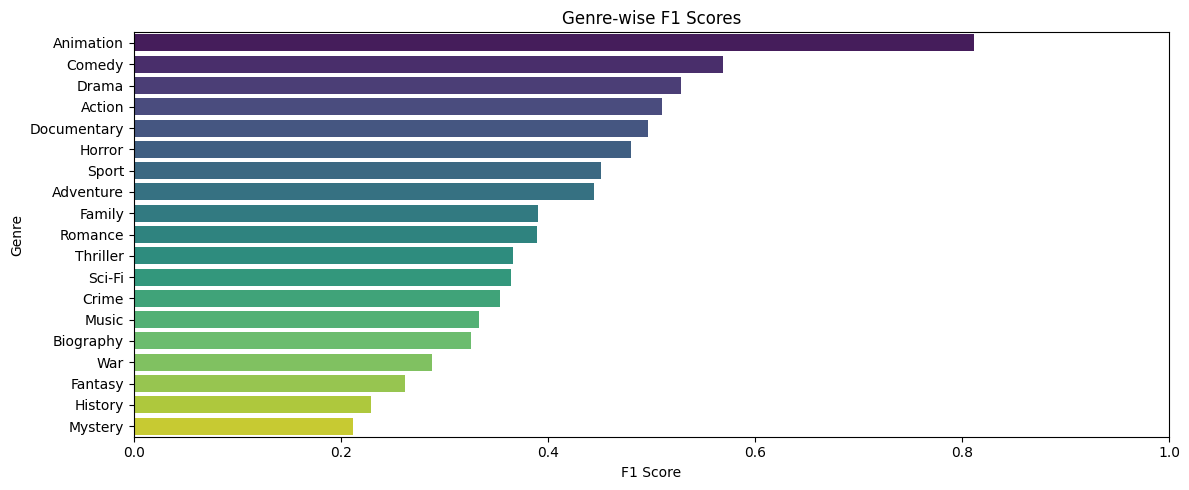

In [ ]:
from sklearn.metrics import f1_score

f1_per_class = f1_score(y_true, y_pred, average=None)
df_f1 = pd.DataFrame({
    'Genre': genre_labels,
    'F1 Score': f1_per_class
}).sort_values("F1 Score", ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(data=df_f1, x="F1 Score", y="Genre", palette="viridis")
plt.title("Genre-wise F1 Scores")
plt.xlabel("F1 Score")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

def find_best_thresholds(y_true, y_probs, thresholds=np.linspace(0.1, 0.9, 17)):
    best_thresholds = []
    for i in range(y_true.shape[1]):
        best_f1 = 0
        best_t = 0.5
        for t in thresholds:
            f1 = f1_score(y_true[:, i], (y_probs[:, i] >= t).astype(int), zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t
        best_thresholds.append(best_t)
    return np.array(best_thresholds)


In [ ]:
# Step 1: Get raw predictions
y_true_raw, y_probs_raw = get_predictions(balanced_model, val_loader, device)

# Step 2: Find best per-class thresholds
best_thresholds = find_best_thresholds(y_true_raw, y_probs_raw)

# Step 3: Binarize using tuned thresholds
y_pred_tuned = (y_probs_raw >= best_thresholds).astype(int)
from sklearn.metrics import classification_report

print(classification_report(y_true_raw, y_pred_tuned, target_names=genre_labels, zero_division=0))


              precision    recall  f1-score   support

      Action       0.48      0.60      0.53      1215
   Adventure       0.42      0.47      0.45       839
   Animation       0.88      0.75      0.81       542
   Biography       0.39      0.28      0.33       468
      Comedy       0.52      0.65      0.58      1130
       Crime       0.30      0.47      0.37       240
 Documentary       0.48      0.53      0.50       824
       Drama       0.50      0.60      0.55      1501
      Family       0.39      0.40      0.39       452
     Fantasy       0.21      0.41      0.28       456
     History       0.20      0.34      0.25       319
      Horror       0.45      0.63      0.53       868
       Music       0.34      0.33      0.34       491
     Mystery       0.23      0.30      0.26       501
     Romance       0.30      0.59      0.40       273
      Sci-Fi       0.37      0.40      0.38       447
       Sport       0.63      0.36      0.46       198
    Thriller       0.37    

**Best Balanced** - This is the best result we get with this balanced Resnet50 model, after threshold tuning.

In [ ]:
# Print each genre's optimal threshold
for genre, thr in zip(genre_labels, best_thresholds):
    print(f"{genre:12} → threshold: {thr:.2f}")


Action       → threshold: 0.30
Adventure    → threshold: 0.45
Animation    → threshold: 0.65
Biography    → threshold: 0.50
Comedy       → threshold: 0.30
Crime        → threshold: 0.20
Documentary  → threshold: 0.35
Drama        → threshold: 0.30
Family       → threshold: 0.45
Fantasy      → threshold: 0.15
History      → threshold: 0.10
Horror       → threshold: 0.10
Music        → threshold: 0.40
Mystery      → threshold: 0.25
Romance      → threshold: 0.15
Sci-Fi       → threshold: 0.25
Sport        → threshold: 0.75
Thriller     → threshold: 0.20
War          → threshold: 0.80


In [ ]:
# Save tuned predictions and true labels to Drive
np.save("/content/drive/MyDrive/movie_model_checkpoints/y_true_balanced.npy", y_true_raw)
np.save("/content/drive/MyDrive/movie_model_checkpoints/y_pred_balanced_tuned.npy", y_pred_tuned)
np.save("/content/drive/MyDrive/movie_model_checkpoints/best_thresholds_balanced.npy", best_thresholds)
print("✅ Saved y_true, y_pred_tuned, and best_thresholds to Drive.")

✅ Saved y_true, y_pred_tuned, and best_thresholds to Drive.


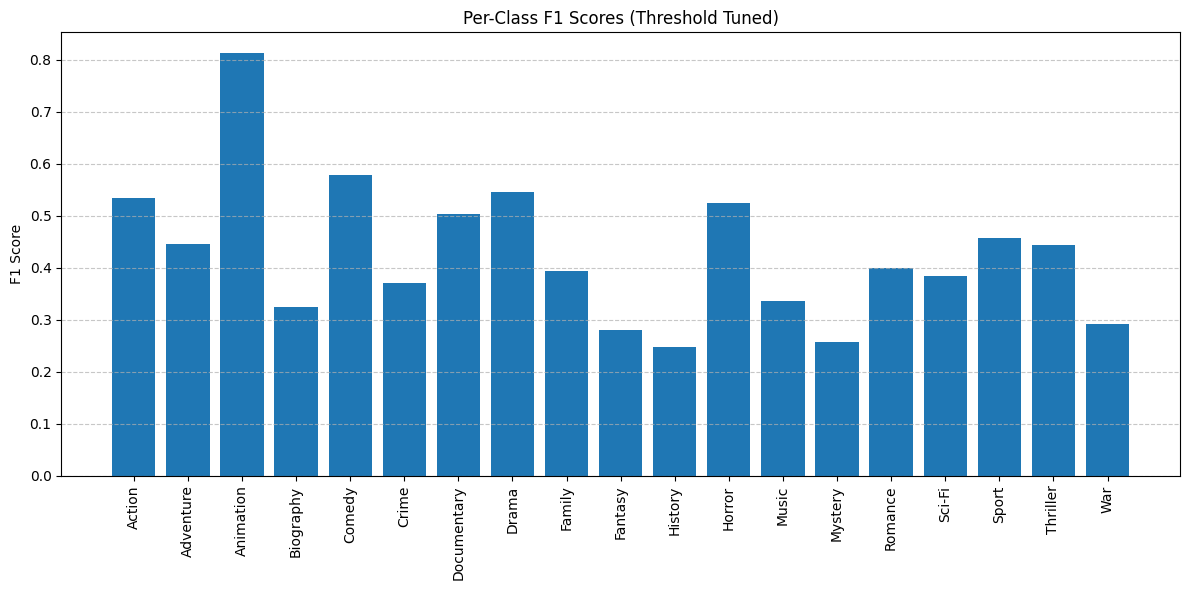

In [ ]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming `genre_labels`, `y_true_raw`, and `y_pred_tuned` already exist
f1_scores = f1_score(y_true_raw, y_pred_tuned, average=None, zero_division=0)

plt.figure(figsize=(12, 6))
plt.bar(genre_labels, f1_scores)
plt.xticks(rotation=90)
plt.ylabel("F1 Score")
plt.title("Per-Class F1 Scores (Threshold Tuned)")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

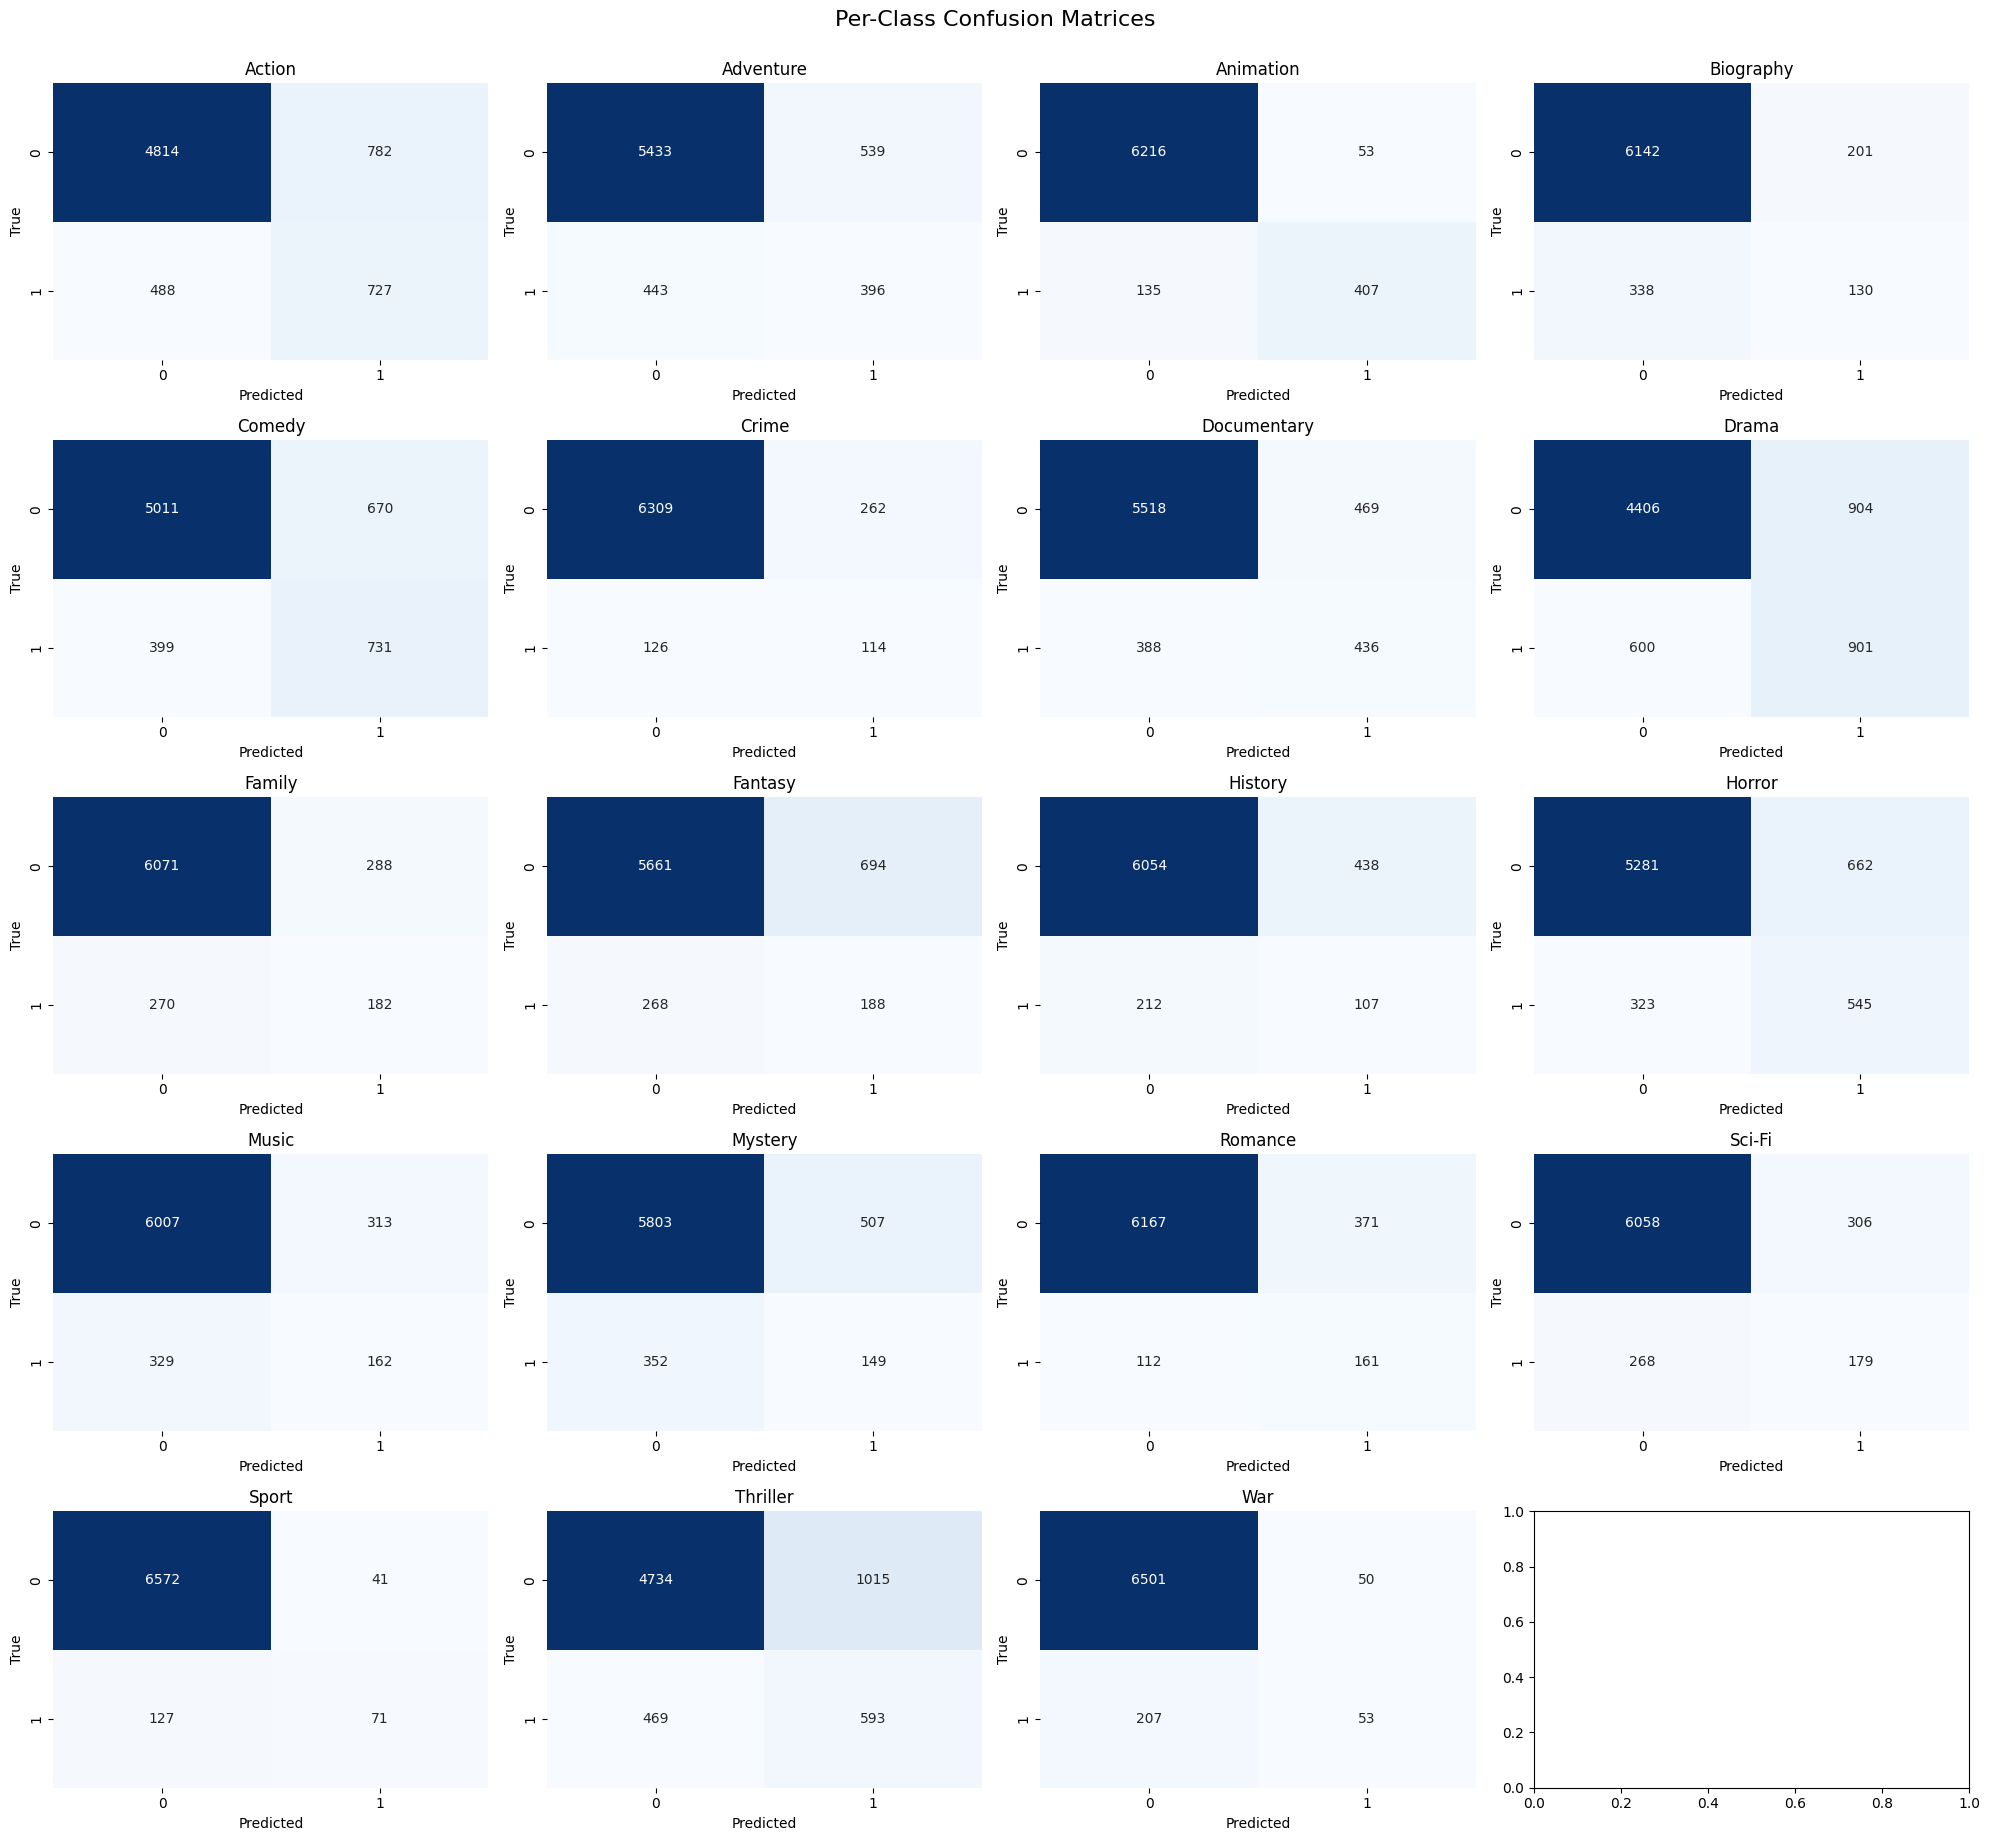

In [ ]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 18))
axes = axes.flatten()

mcm = multilabel_confusion_matrix(y_true_raw, y_pred_tuned)

for i, cm in enumerate(mcm):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
    axes[i].set_title(genre_labels[i])
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

plt.tight_layout()
plt.suptitle("Per-Class Confusion Matrices", y=1.02, fontsize=16)
plt.show()

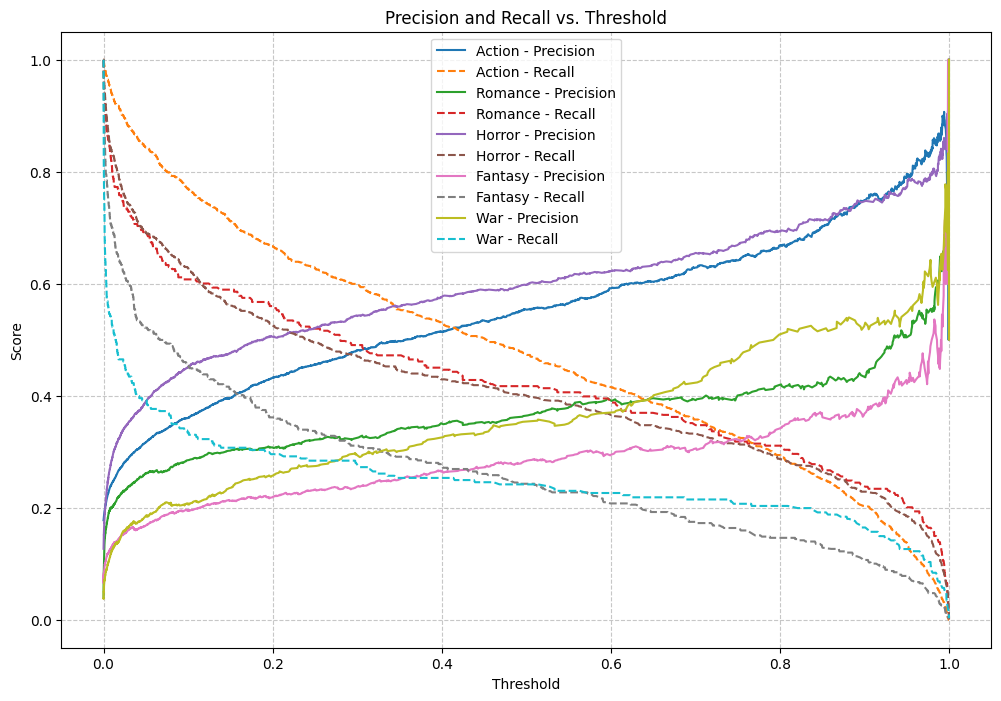

In [ ]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(12, 8))

for i, genre in enumerate(["Action", "Romance", "Horror", "Fantasy", "War"]):  # Pick any
    y_true_i = y_true_raw[:, genre_labels.index(genre)]
    y_probs_i = y_probs_raw[:, genre_labels.index(genre)]

    precision, recall, thresholds = precision_recall_curve(y_true_i, y_probs_i)
    plt.plot(thresholds, precision[:-1], label=f'{genre} - Precision')
    plt.plot(thresholds, recall[:-1], linestyle='--', label=f'{genre} - Recall')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

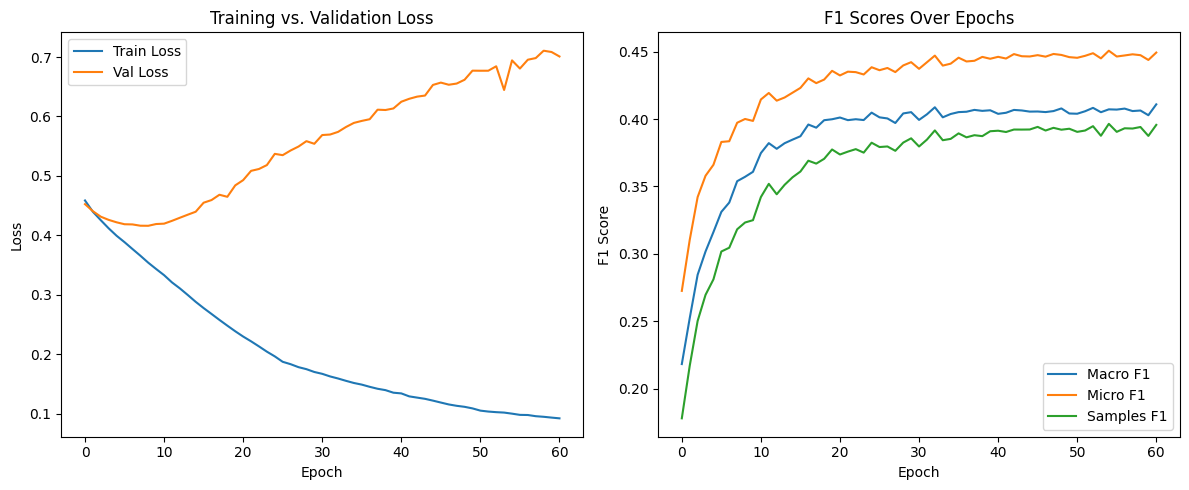

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load metrics
train_losses = np.load("/content/drive/MyDrive/movie_model_checkpoints/balanced_train_losses.npy")
val_losses = np.load("/content/drive/MyDrive/movie_model_checkpoints/balanced_val_losses.npy")
macro_f1s = np.load("/content/drive/MyDrive/movie_model_checkpoints/balanced_macro_f1s.npy")
micro_f1s = np.load("/content/drive/MyDrive/movie_model_checkpoints/balanced_micro_f1s.npy")
samples_f1s = np.load("/content/drive/MyDrive/movie_model_checkpoints/balanced_samples_f1s.npy")

# Plot
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()

# F1
plt.subplot(1, 2, 2)
plt.plot(macro_f1s, label="Macro F1")
plt.plot(micro_f1s, label="Micro F1")
plt.plot(samples_f1s, label="Samples F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Scores Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


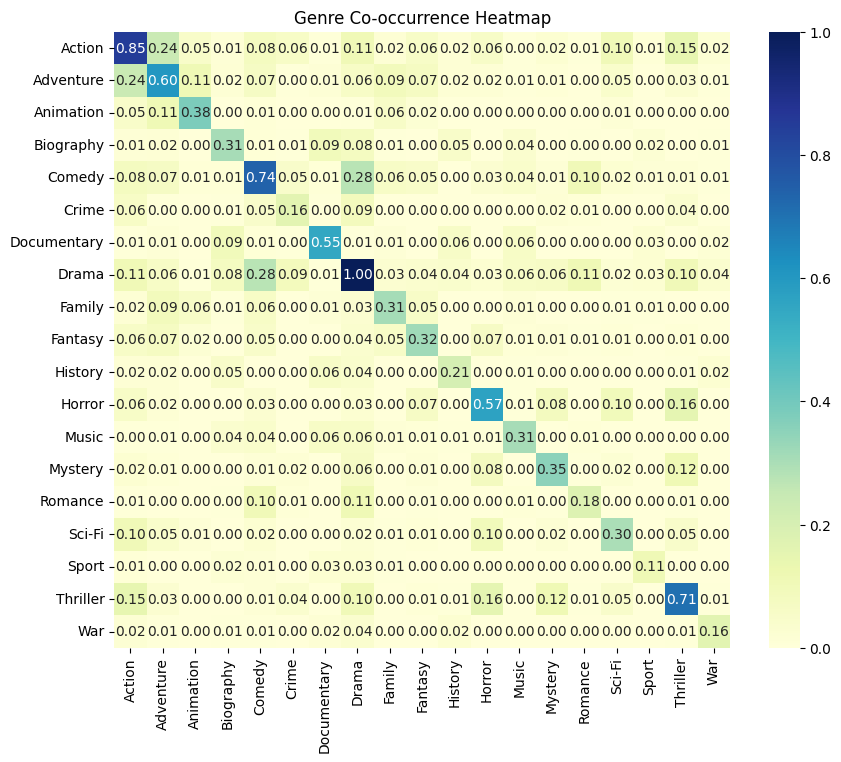

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your label dataframe (ground truth)
df = pd.read_csv("train_labels.csv")  # or val_labels.csv
genre_labels = df.columns[1:]
label_matrix = df[genre_labels].values

# Compute co-occurrence
co_occurrence = np.dot(label_matrix.T, label_matrix)

# Normalize
co_occurrence_normalized = co_occurrence / co_occurrence.max()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_normalized, xticklabels=genre_labels, yticklabels=genre_labels, cmap="YlGnBu", square=True, annot=True, fmt=".2f")
plt.title("Genre Co-occurrence Heatmap")
plt.show()


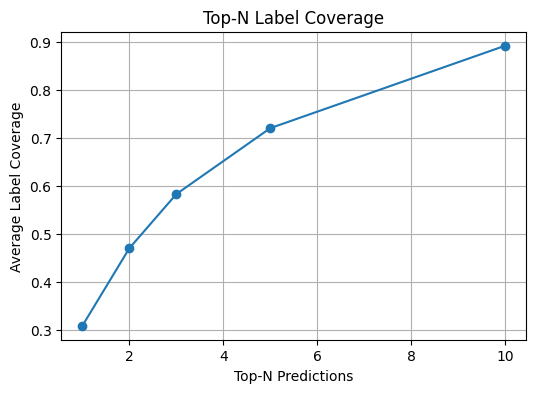

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def top_n_coverage(y_true, y_probs, top_n=3):
    coverages = []
    for i in range(y_true.shape[0]):
        top_indices = np.argsort(y_probs[i])[::-1][:top_n]
        true_indices = np.where(y_true[i] == 1)[0]
        hits = len(set(top_indices) & set(true_indices))
        coverages.append(hits / len(true_indices) if len(true_indices) > 0 else 0)
    return np.mean(coverages)

# Calculate for different N
top_ns = [1, 2, 3, 5, 10]
coverage_scores = [top_n_coverage(y_true_raw, y_probs_raw, n) for n in top_ns]

# Plot
plt.figure(figsize=(6, 4))
plt.plot(top_ns, coverage_scores, marker='o')
plt.xlabel("Top-N Predictions")
plt.ylabel("Average Label Coverage")
plt.title("Top-N Label Coverage")
plt.grid(True)
plt.show()


#EfficientNetV2-S Model

- This is a pretty strong model to consider, here we could have used the larger V2 model but ran into some computational issues so we had to take V2-S for our model

In [ ]:
# Load training labels
import pandas as pd
df = pd.read_csv("train_labels.csv")
genre_labels = df.columns.tolist()[1:]
label_counts = df[genre_labels].sum(axis=0)

# Compute pos_weights as inverse frequency scaling
pos_weights = label_counts.max() / (label_counts + 1e-6)
pos_weights = torch.tensor(pos_weights.values, dtype=torch.float32).to(device)

In [ ]:
# === EfficientNetV2-S Multi-Label Training Setup === #JUST DID A SMALL RUN TO SEE

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torch.optim.lr_scheduler import StepLR
import os

# --- 1. Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. Load Model ---
efficientnet_v2 = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
for param in efficientnet_v2.parameters():
    param.requires_grad = False  # freeze backbone initially

NUM_CLASSES = len(genre_labels)
efficientnet_v2.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(efficientnet_v2.classifier[1].in_features, NUM_CLASSES)
)
efficientnet_v2 = efficientnet_v2.to(device)

# --- 3. Optimizer + Loss (pos_weight recommended) ---
# Compute pos_weights_array externally like in ResNet setup, then pass it here
pos_weights = torch.tensor(pos_weights, dtype=torch.float32).to(device)
total_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = optim.Adam(efficientnet_v2.classifier.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)

# --- 4. Train Frozen Head ---
import copy
EPOCHS = 10  # first stage
train_losses, val_losses = [], []
macro_f1s, micro_f1s, samples_f1s = [], [], []
best_macro_f1 = 0.0
best_model_wts = copy.deepcopy(efficientnet_v2.state_dict())

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(efficientnet_v2, train_loader, optimizer, total_criterion, device)
    val_loss, macro_f1, micro_f1, samples_f1 = evaluate(efficientnet_v2, val_loader, total_criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    macro_f1s.append(macro_f1)
    micro_f1s.append(micro_f1)
    samples_f1s.append(samples_f1)

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_model_wts = copy.deepcopy(efficientnet_v2.state_dict())

    scheduler.step()

    print(f"[EFFv2-FROZEN] Epoch {epoch+1}/{EPOCHS} → "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Macro F1: {macro_f1:.4f} | Micro F1: {micro_f1:.4f} | Samples F1: {samples_f1:.4f}")

# --- 5. Unfreeze last blocks for fine-tuning ---
for name, param in efficientnet_v2.features.named_parameters():
    if "6" in name or "7" in name:
        param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, efficientnet_v2.parameters()), lr=1e-5)
scheduler = StepLR(optimizer, step_size=25, gamma=0.5)

# --- 6. Fine-tune Unfrozen ---
EPOCHS_FINE = 10  # adjust as needed
for epoch in range(EPOCHS_FINE):
    train_loss = train_one_epoch(efficientnet_v2, train_loader, optimizer, total_criterion, device)
    val_loss, macro_f1, micro_f1, samples_f1 = evaluate(efficientnet_v2, val_loader, total_criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    macro_f1s.append(macro_f1)
    micro_f1s.append(micro_f1)
    samples_f1s.append(samples_f1)

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_model_wts = copy.deepcopy(efficientnet_v2.state_dict())

    scheduler.step()

    print(f"[EFFv2-FTUNE] Epoch {epoch+1}/{EPOCHS_FINE} → "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Macro F1: {macro_f1:.4f} | Micro F1: {micro_f1:.4f} | Samples F1: {samples_f1:.4f}")

# --- 7. Save model + metrics ---
save_dir = "/content/drive/MyDrive/movie_model_checkpoints"
os.makedirs(save_dir, exist_ok=True)

torch.save(best_model_wts, os.path.join(save_dir, "efficientnetv2_best.pth"))
np.save(os.path.join(save_dir, "efficientnetv2_train_losses.npy"), np.array(train_losses))
np.save(os.path.join(save_dir, "efficientnetv2_val_losses.npy"), np.array(val_losses))
np.save(os.path.join(save_dir, "efficientnetv2_macro_f1s.npy"), np.array(macro_f1s))
np.save(os.path.join(save_dir, "efficientnetv2_micro_f1s.npy"), np.array(micro_f1s))
np.save(os.path.join(save_dir, "efficientnetv2_samples_f1s.npy"), np.array(samples_f1s))

print("✅ EfficientNetV2-S model and metrics saved!")


<ipython-input-78-ec90512d8004>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weights = torch.tensor(pos_weights, dtype=torch.float32).to(device)


[EFFv2-FROZEN] Epoch 1/10 → Train Loss: 0.5805 | Val Loss: 0.5668 | Macro F1: 0.0908 | Micro F1: 0.1085 | Samples F1: 0.0647


[EFFv2-FROZEN] Epoch 2/10 → Train Loss: 0.5427 | Val Loss: 0.5483 | Macro F1: 0.1403 | Micro F1: 0.1726 | Samples F1: 0.1172


[EFFv2-FROZEN] Epoch 3/10 → Train Loss: 0.5290 | Val Loss: 0.5361 | Macro F1: 0.1779 | Micro F1: 0.2169 | Samples F1: 0.1548


[EFFv2-FROZEN] Epoch 4/10 → Train Loss: 0.5200 | Val Loss: 0.5275 | Macro F1: 0.2015 | Micro F1: 0.2395 | Samples F1: 0.1749


[EFFv2-FROZEN] Epoch 5/10 → Train Loss: 0.5155 | Val Loss: 0.5236 | Macro F1: 0.2104 | Micro F1: 0.2476 | Samples F1: 0.1835


[EFFv2-FROZEN] Epoch 6/10 → Train Loss: 0.5110 | Val Loss: 0.5160 | Macro F1: 0.2057 | Micro F1: 0.2447 | Samples F1: 0.1831


[EFFv2-FROZEN] Epoch 7/10 → Train Loss: 0.5072 | Val Loss: 0.5147 | Macro F1: 0.2190 | Micro F1: 0.2597 | Samples F1: 0.1965


[EFFv2-FROZEN] Epoch 8/10 → Train Loss: 0.5035 | Val Loss: 0.5115 | Macro F1: 0.2209 | Micro F1: 0.2587 | Samples F1: 0.1958


[EFFv2-FROZEN] Epoch 9/10 → Train Loss: 0.5030 | Val Loss: 0.5094 | Macro F1: 0.2264 | Micro F1: 0.2655 | Samples F1: 0.2031


[EFFv2-FROZEN] Epoch 10/10 → Train Loss: 0.4995 | Val Loss: 0.5072 | Macro F1: 0.2274 | Micro F1: 0.2657 | Samples F1: 0.2032


[EFFv2-FTUNE] Epoch 1/10 → Train Loss: 0.4767 | Val Loss: 0.4606 | Macro F1: 0.2314 | Micro F1: 0.2837 | Samples F1: 0.2055


[EFFv2-FTUNE] Epoch 2/10 → Train Loss: 0.4554 | Val Loss: 0.4468 | Macro F1: 0.2675 | Micro F1: 0.3249 | Samples F1: 0.2401


[EFFv2-FTUNE] Epoch 3/10 → Train Loss: 0.4419 | Val Loss: 0.4387 | Macro F1: 0.2935 | Micro F1: 0.3460 | Samples F1: 0.2622


[EFFv2-FTUNE] Epoch 4/10 → Train Loss: 0.4315 | Val Loss: 0.4322 | Macro F1: 0.3073 | Micro F1: 0.3578 | Samples F1: 0.2782


[EFFv2-FTUNE] Epoch 5/10 → Train Loss: 0.4215 | Val Loss: 0.4281 | Macro F1: 0.3192 | Micro F1: 0.3685 | Samples F1: 0.2894


[EFFv2-FTUNE] Epoch 6/10 → Train Loss: 0.4121 | Val Loss: 0.4238 | Macro F1: 0.3259 | Micro F1: 0.3730 | Samples F1: 0.2949


[EFFv2-FTUNE] Epoch 7/10 → Train Loss: 0.4041 | Val Loss: 0.4204 | Macro F1: 0.3388 | Micro F1: 0.3874 | Samples F1: 0.3121


[EFFv2-FTUNE] Epoch 8/10 → Train Loss: 0.3955 | Val Loss: 0.4190 | Macro F1: 0.3552 | Micro F1: 0.3961 | Samples F1: 0.3248


[EFFv2-FTUNE] Epoch 9/10 → Train Loss: 0.3870 | Val Loss: 0.4161 | Macro F1: 0.3507 | Micro F1: 0.3947 | Samples F1: 0.3192


[EFFv2-FTUNE] Epoch 10/10 → Train Loss: 0.3794 | Val Loss: 0.4140 | Macro F1: 0.3688 | Micro F1: 0.4059 | Samples F1: 0.3354
✅ EfficientNetV2-S model and metrics saved!


**First Run** - We try out the model for a small run, first 10 epochs had the frozen model, then the next 10 we tune out the 6 and 7 blocks for the weights. Now we try out 60 epochs (10 frozen)

In [ ]:
# === EfficientNetV2-S Full Training Setup (Best Configuration) === #THIS IS THE ONE WE DID FOR 6-7  unfrozen

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torch.optim.lr_scheduler import StepLR
import os
import numpy as np

# === Device and Data ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 1. Load pretrained EfficientNetV2-S ===
efficientnet_v2 = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

# === 2. Modify classifier ===
NUM_CLASSES = len(genre_labels)  # should already be defined
in_features = efficientnet_v2.classifier[1].in_features
efficientnet_v2.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, NUM_CLASSES)
)

# === 3. Freeze base initially ===
for param in efficientnet_v2.features.parameters():
    param.requires_grad = False

# === 4. Define pos_weight loss ===
label_counts = df[genre_labels].sum(axis=0)
pos_weights_array = label_counts.max() / (label_counts + 1e-6)
pos_weights = torch.tensor(pos_weights_array.values, dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)


# === 5. Optimizer & scheduler ===
optimizer = optim.Adam(efficientnet_v2.classifier.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=15, gamma=0.5)

# === 6. Move to device ===
efficientnet_v2 = efficientnet_v2.to(device)

# === 7. Train frozen classifier for a few epochs ===
EPOCHS_FROZEN = 5
for epoch in range(EPOCHS_FROZEN):
    train_loss = train_one_epoch(efficientnet_v2, train_loader, optimizer, criterion, device)
    val_loss, macro_f1, micro_f1, samples_f1 = evaluate(efficientnet_v2, val_loader, criterion, device)
    print(f"[EFFv2-FROZEN] Epoch {epoch+1}/{EPOCHS_FROZEN} → Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Macro F1: {macro_f1:.4f} | Micro F1: {micro_f1:.4f} | Samples F1: {samples_f1:.4f}")

# === 8. Unfreeze last few blocks for fine-tuning ===
for name, param in efficientnet_v2.features.named_parameters():
    if any(block in name for block in ["6", "7"]):
        param.requires_grad = True

# === 9. Update optimizer to train more params ===
optimizer = optim.Adam(filter(lambda p: p.requires_grad, efficientnet_v2.parameters()), lr=1e-5)
scheduler = StepLR(optimizer, step_size=15, gamma=0.5)

# === 10. Fine-tune for longer ===
EPOCHS_FINE = 50
best_macro_f1 = 0.0
best_model_wts = efficientnet_v2.state_dict()

# For saving history
train_losses = []
val_losses = []
macro_f1s = []
micro_f1s = []
samples_f1s = []

for epoch in range(EPOCHS_FINE):
    train_loss = train_one_epoch(efficientnet_v2, train_loader, optimizer, criterion, device)
    val_loss, macro_f1, micro_f1, samples_f1 = evaluate(efficientnet_v2, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    macro_f1s.append(macro_f1)
    micro_f1s.append(micro_f1)
    samples_f1s.append(samples_f1)

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_model_wts = efficientnet_v2.state_dict()
        torch.save(best_model_wts, "/content/drive/MyDrive/movie_model_checkpoints/efficientnetv2_best.pth")

    scheduler.step()

    print(f"[EFFv2-FTUNE] Epoch {epoch+1}/{EPOCHS_FINE} → Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Macro F1: {macro_f1:.4f} | Micro F1: {micro_f1:.4f} | Samples F1: {samples_f1:.4f}")

# === Save training metrics ===
save_dir = "/content/drive/MyDrive/movie_model_checkpoints"
os.makedirs(save_dir, exist_ok=True)
np.save(os.path.join(save_dir, "effv2_train_losses.npy"), np.array(train_losses))
np.save(os.path.join(save_dir, "effv2_val_losses.npy"), np.array(val_losses))
np.save(os.path.join(save_dir, "effv2_macro_f1s.npy"), np.array(macro_f1s))
np.save(os.path.join(save_dir, "effv2_micro_f1s.npy"), np.array(micro_f1s))
np.save(os.path.join(save_dir, "effv2_samples_f1s.npy"), np.array(samples_f1s))

print("✅ EfficientNetV2-S full training done and saved.")


[EFFv2-FROZEN] Epoch 1/5 → Train Loss: 0.5804 | Val Loss: 0.5677 | Macro F1: 0.0940 | Micro F1: 0.1125 | Samples F1: 0.0679


[EFFv2-FROZEN] Epoch 2/5 → Train Loss: 0.5429 | Val Loss: 0.5475 | Macro F1: 0.1462 | Micro F1: 0.1776 | Samples F1: 0.1193


[EFFv2-FROZEN] Epoch 3/5 → Train Loss: 0.5289 | Val Loss: 0.5353 | Macro F1: 0.1801 | Micro F1: 0.2146 | Samples F1: 0.1520


[EFFv2-FROZEN] Epoch 4/5 → Train Loss: 0.5208 | Val Loss: 0.5255 | Macro F1: 0.1917 | Micro F1: 0.2292 | Samples F1: 0.1653


[EFFv2-FROZEN] Epoch 5/5 → Train Loss: 0.5155 | Val Loss: 0.5241 | Macro F1: 0.2132 | Micro F1: 0.2510 | Samples F1: 0.1871


[EFFv2-FTUNE] Epoch 1/50 → Train Loss: 0.4856 | Val Loss: 0.4668 | Macro F1: 0.2100 | Micro F1: 0.2600 | Samples F1: 0.1838


[EFFv2-FTUNE] Epoch 2/50 → Train Loss: 0.4618 | Val Loss: 0.4517 | Macro F1: 0.2539 | Micro F1: 0.3143 | Samples F1: 0.2279


[EFFv2-FTUNE] Epoch 3/50 → Train Loss: 0.4467 | Val Loss: 0.4414 | Macro F1: 0.2843 | Micro F1: 0.3443 | Samples F1: 0.2587


[EFFv2-FTUNE] Epoch 4/50 → Train Loss: 0.4351 | Val Loss: 0.4344 | Macro F1: 0.2989 | Micro F1: 0.3581 | Samples F1: 0.2729


[EFFv2-FTUNE] Epoch 5/50 → Train Loss: 0.4246 | Val Loss: 0.4291 | Macro F1: 0.3075 | Micro F1: 0.3621 | Samples F1: 0.2800


[EFFv2-FTUNE] Epoch 6/50 → Train Loss: 0.4170 | Val Loss: 0.4247 | Macro F1: 0.3313 | Micro F1: 0.3809 | Samples F1: 0.2999


[EFFv2-FTUNE] Epoch 7/50 → Train Loss: 0.4069 | Val Loss: 0.4200 | Macro F1: 0.3421 | Micro F1: 0.3882 | Samples F1: 0.3112


[EFFv2-FTUNE] Epoch 8/50 → Train Loss: 0.3990 | Val Loss: 0.4184 | Macro F1: 0.3458 | Micro F1: 0.3904 | Samples F1: 0.3168


[EFFv2-FTUNE] Epoch 9/50 → Train Loss: 0.3904 | Val Loss: 0.4165 | Macro F1: 0.3547 | Micro F1: 0.3968 | Samples F1: 0.3233


[EFFv2-FTUNE] Epoch 10/50 → Train Loss: 0.3815 | Val Loss: 0.4143 | Macro F1: 0.3616 | Micro F1: 0.4022 | Samples F1: 0.3313


[EFFv2-FTUNE] Epoch 11/50 → Train Loss: 0.3732 | Val Loss: 0.4135 | Macro F1: 0.3705 | Micro F1: 0.4091 | Samples F1: 0.3426


[EFFv2-FTUNE] Epoch 12/50 → Train Loss: 0.3652 | Val Loss: 0.4136 | Macro F1: 0.3687 | Micro F1: 0.4062 | Samples F1: 0.3377


[EFFv2-FTUNE] Epoch 13/50 → Train Loss: 0.3564 | Val Loss: 0.4144 | Macro F1: 0.3740 | Micro F1: 0.4106 | Samples F1: 0.3445


[EFFv2-FTUNE] Epoch 14/50 → Train Loss: 0.3500 | Val Loss: 0.4126 | Macro F1: 0.3793 | Micro F1: 0.4170 | Samples F1: 0.3476


[EFFv2-FTUNE] Epoch 15/50 → Train Loss: 0.3394 | Val Loss: 0.4140 | Macro F1: 0.3870 | Micro F1: 0.4179 | Samples F1: 0.3534


[EFFv2-FTUNE] Epoch 16/50 → Train Loss: 0.3322 | Val Loss: 0.4150 | Macro F1: 0.3900 | Micro F1: 0.4243 | Samples F1: 0.3600


[EFFv2-FTUNE] Epoch 17/50 → Train Loss: 0.3279 | Val Loss: 0.4155 | Macro F1: 0.3900 | Micro F1: 0.4213 | Samples F1: 0.3622


[EFFv2-FTUNE] Epoch 18/50 → Train Loss: 0.3241 | Val Loss: 0.4165 | Macro F1: 0.3992 | Micro F1: 0.4286 | Samples F1: 0.3702


[EFFv2-FTUNE] Epoch 19/50 → Train Loss: 0.3194 | Val Loss: 0.4198 | Macro F1: 0.3981 | Micro F1: 0.4278 | Samples F1: 0.3692


[EFFv2-FTUNE] Epoch 20/50 → Train Loss: 0.3163 | Val Loss: 0.4194 | Macro F1: 0.4011 | Micro F1: 0.4290 | Samples F1: 0.3732


[EFFv2-FTUNE] Epoch 21/50 → Train Loss: 0.3131 | Val Loss: 0.4206 | Macro F1: 0.4038 | Micro F1: 0.4346 | Samples F1: 0.3771


[EFFv2-FTUNE] Epoch 22/50 → Train Loss: 0.3077 | Val Loss: 0.4218 | Macro F1: 0.4045 | Micro F1: 0.4345 | Samples F1: 0.3768


[EFFv2-FTUNE] Epoch 23/50 → Train Loss: 0.3052 | Val Loss: 0.4250 | Macro F1: 0.4019 | Micro F1: 0.4294 | Samples F1: 0.3735


[EFFv2-FTUNE] Epoch 24/50 → Train Loss: 0.3003 | Val Loss: 0.4247 | Macro F1: 0.4043 | Micro F1: 0.4321 | Samples F1: 0.3754


[EFFv2-FTUNE] Epoch 25/50 → Train Loss: 0.2966 | Val Loss: 0.4252 | Macro F1: 0.4067 | Micro F1: 0.4366 | Samples F1: 0.3808


[EFFv2-FTUNE] Epoch 26/50 → Train Loss: 0.2928 | Val Loss: 0.4275 | Macro F1: 0.4036 | Micro F1: 0.4342 | Samples F1: 0.3788


[EFFv2-FTUNE] Epoch 27/50 → Train Loss: 0.2897 | Val Loss: 0.4306 | Macro F1: 0.4106 | Micro F1: 0.4414 | Samples F1: 0.3863


[EFFv2-FTUNE] Epoch 28/50 → Train Loss: 0.2861 | Val Loss: 0.4294 | Macro F1: 0.4083 | Micro F1: 0.4353 | Samples F1: 0.3832


[EFFv2-FTUNE] Epoch 29/50 → Train Loss: 0.2836 | Val Loss: 0.4319 | Macro F1: 0.4061 | Micro F1: 0.4327 | Samples F1: 0.3808


[EFFv2-FTUNE] Epoch 30/50 → Train Loss: 0.2794 | Val Loss: 0.4330 | Macro F1: 0.4067 | Micro F1: 0.4364 | Samples F1: 0.3836


[EFFv2-FTUNE] Epoch 31/50 → Train Loss: 0.2761 | Val Loss: 0.4375 | Macro F1: 0.4055 | Micro F1: 0.4349 | Samples F1: 0.3795


[EFFv2-FTUNE] Epoch 32/50 → Train Loss: 0.2756 | Val Loss: 0.4368 | Macro F1: 0.4075 | Micro F1: 0.4332 | Samples F1: 0.3805


[EFFv2-FTUNE] Epoch 33/50 → Train Loss: 0.2716 | Val Loss: 0.4381 | Macro F1: 0.4101 | Micro F1: 0.4405 | Samples F1: 0.3872


[EFFv2-FTUNE] Epoch 34/50 → Train Loss: 0.2706 | Val Loss: 0.4397 | Macro F1: 0.4072 | Micro F1: 0.4358 | Samples F1: 0.3841


[EFFv2-FTUNE] Epoch 35/50 → Train Loss: 0.2679 | Val Loss: 0.4387 | Macro F1: 0.4085 | Micro F1: 0.4411 | Samples F1: 0.3868


[EFFv2-FTUNE] Epoch 36/50 → Train Loss: 0.2671 | Val Loss: 0.4416 | Macro F1: 0.4083 | Micro F1: 0.4378 | Samples F1: 0.3840


[EFFv2-FTUNE] Epoch 37/50 → Train Loss: 0.2648 | Val Loss: 0.4439 | Macro F1: 0.4161 | Micro F1: 0.4406 | Samples F1: 0.3928


[EFFv2-FTUNE] Epoch 38/50 → Train Loss: 0.2638 | Val Loss: 0.4423 | Macro F1: 0.4119 | Micro F1: 0.4370 | Samples F1: 0.3864


[EFFv2-FTUNE] Epoch 39/50 → Train Loss: 0.2625 | Val Loss: 0.4456 | Macro F1: 0.4117 | Micro F1: 0.4403 | Samples F1: 0.3909


[EFFv2-FTUNE] Epoch 40/50 → Train Loss: 0.2608 | Val Loss: 0.4470 | Macro F1: 0.4103 | Micro F1: 0.4359 | Samples F1: 0.3840


[EFFv2-FTUNE] Epoch 41/50 → Train Loss: 0.2593 | Val Loss: 0.4470 | Macro F1: 0.4156 | Micro F1: 0.4431 | Samples F1: 0.3946


[EFFv2-FTUNE] Epoch 42/50 → Train Loss: 0.2561 | Val Loss: 0.4481 | Macro F1: 0.4128 | Micro F1: 0.4418 | Samples F1: 0.3920


[EFFv2-FTUNE] Epoch 43/50 → Train Loss: 0.2561 | Val Loss: 0.4495 | Macro F1: 0.4143 | Micro F1: 0.4420 | Samples F1: 0.3929


[EFFv2-FTUNE] Epoch 44/50 → Train Loss: 0.2541 | Val Loss: 0.4492 | Macro F1: 0.4158 | Micro F1: 0.4435 | Samples F1: 0.3948


[EFFv2-FTUNE] Epoch 45/50 → Train Loss: 0.2520 | Val Loss: 0.4526 | Macro F1: 0.4128 | Micro F1: 0.4401 | Samples F1: 0.3892


[EFFv2-FTUNE] Epoch 46/50 → Train Loss: 0.2514 | Val Loss: 0.4519 | Macro F1: 0.4144 | Micro F1: 0.4405 | Samples F1: 0.3941


[EFFv2-FTUNE] Epoch 47/50 → Train Loss: 0.2486 | Val Loss: 0.4521 | Macro F1: 0.4169 | Micro F1: 0.4447 | Samples F1: 0.3955


[EFFv2-FTUNE] Epoch 48/50 → Train Loss: 0.2475 | Val Loss: 0.4512 | Macro F1: 0.4164 | Micro F1: 0.4448 | Samples F1: 0.3949


[EFFv2-FTUNE] Epoch 49/50 → Train Loss: 0.2487 | Val Loss: 0.4496 | Macro F1: 0.4167 | Micro F1: 0.4432 | Samples F1: 0.3949


[EFFv2-FTUNE] Epoch 50/50 → Train Loss: 0.2467 | Val Loss: 0.4506 | Macro F1: 0.4088 | Micro F1: 0.4411 | Samples F1: 0.3922
✅ EfficientNetV2-S full training done and saved.


**50 epochs** - This is what we get for 50 epochs, we will get the criteria but instead skip straight to the threshold tuned version of this model for the best results

In [ ]:
# Get raw predicted probabilities
y_true_raw, y_probs_raw = get_predictions(efficientnet_v2, val_loader, device)

# Threshold tuning
def find_best_thresholds(y_true, y_probs, thresholds=np.linspace(0.1, 0.9, 17)):
    best_thresholds = []
    for i in range(y_true.shape[1]):
        best_f1 = 0
        best_t = 0.5
        for t in thresholds:
            f1 = f1_score(y_true[:, i], (y_probs[:, i] >= t).astype(int), zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t
        best_thresholds.append(best_t)
    return np.array(best_thresholds)

best_thresholds_v2s = find_best_thresholds(y_true_raw, y_probs_raw)
y_pred_tuned = (y_probs_raw >= best_thresholds_v2s).astype(int)

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Load genre names
df = pd.read_csv("train_labels.csv")
genre_labels = df.columns.tolist()[1:]

# Print detailed per-class F1/Precision/Recall
print(classification_report(y_true_raw, y_pred_tuned, target_names=genre_labels, zero_division=0))

              precision    recall  f1-score   support

      Action       0.49      0.58      0.53      1215
   Adventure       0.37      0.54      0.44       839
   Animation       0.87      0.79      0.83       542
   Biography       0.21      0.47      0.29       468
      Comedy       0.60      0.57      0.59      1130
       Crime       0.32      0.47      0.38       240
 Documentary       0.48      0.60      0.53       824
       Drama       0.51      0.61      0.56      1501
      Family       0.33      0.52      0.40       452
     Fantasy       0.21      0.43      0.28       456
     History       0.17      0.34      0.23       319
      Horror       0.51      0.62      0.56       868
       Music       0.30      0.38      0.33       491
     Mystery       0.18      0.48      0.27       501
     Romance       0.32      0.63      0.43       273
      Sci-Fi       0.39      0.37      0.38       447
       Sport       0.56      0.44      0.50       198
    Thriller       0.35    

**50 Epoch, 6-7 Unfrozen V2-s Run** - We obtain promising results with this model. It is considered that we might get even better numbers if we can unfreeze 4 and 5 as well, and run for 100 epochs instead, we try that below

In [ ]:
np.save("/content/drive/MyDrive/movie_model_checkpoints/thresholds_v2s.npy", best_thresholds_v2s)

In [ ]:
# Print each genre's optimal threshold
for genre, thr in zip(genre_labels, best_thresholds_v2s):
    print(f"{genre:12} → threshold: {thr:.2f}")


Action       → threshold: 0.35
Adventure    → threshold: 0.30
Animation    → threshold: 0.80
Biography    → threshold: 0.35
Comedy       → threshold: 0.40
Crime        → threshold: 0.60
Documentary  → threshold: 0.50
Drama        → threshold: 0.30
Family       → threshold: 0.35
Fantasy      → threshold: 0.30
History      → threshold: 0.40
Horror       → threshold: 0.35
Music        → threshold: 0.45
Mystery      → threshold: 0.30
Romance      → threshold: 0.40
Sci-Fi       → threshold: 0.55
Sport        → threshold: 0.80
Thriller     → threshold: 0.30
War          → threshold: 0.60


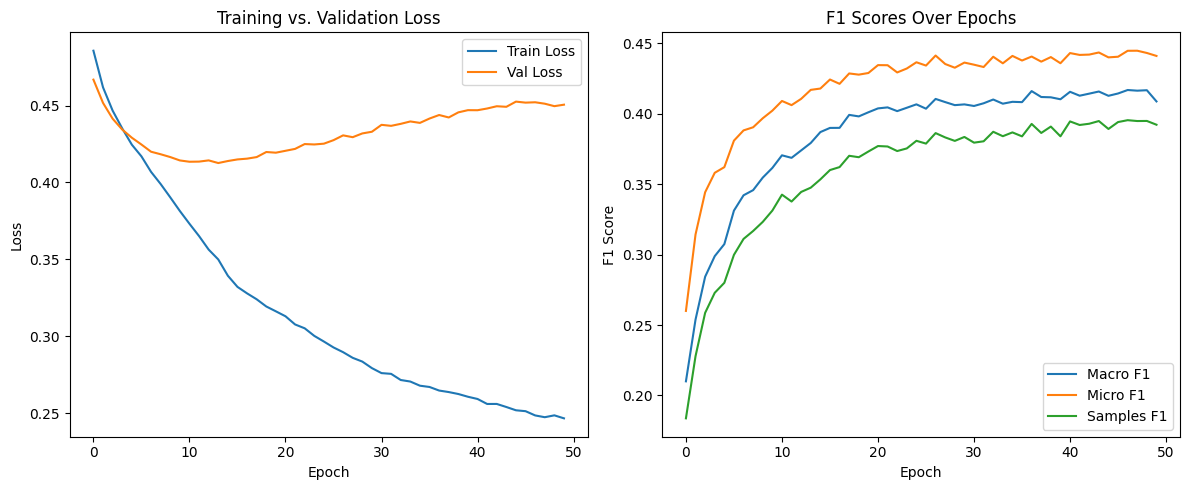

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load metrics
train_losses = np.load("/content/drive/MyDrive/movie_model_checkpoints/effv2_train_losses.npy")
val_losses = np.load("/content/drive/MyDrive/movie_model_checkpoints/effv2_val_losses.npy")
macro_f1s = np.load("/content/drive/MyDrive/movie_model_checkpoints/effv2_macro_f1s.npy")
micro_f1s = np.load("/content/drive/MyDrive/movie_model_checkpoints/effv2_micro_f1s.npy")
samples_f1s = np.load("/content/drive/MyDrive/movie_model_checkpoints/effv2_samples_f1s.npy")

# Plot
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()

# F1
plt.subplot(1, 2, 2)
plt.plot(macro_f1s, label="Macro F1")
plt.plot(micro_f1s, label="Micro F1")
plt.plot(samples_f1s, label="Samples F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Scores Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


**100 epochs, 4-5-6-7 blocks Trained, V2-S** - This is the run we were looking forward to trying

In [ ]:
# === EfficientNetV2-S Full Training Setup (Best Configuration) === #THE BEST ONE WE DID, NOW 4-5-6-7 UNFROZEN, 100 EPOCHS

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torch.optim.lr_scheduler import StepLR
import os
import numpy as np

# === Device and Data ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 1. Load pretrained EfficientNetV2-S ===
efficientnet_v2 = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

# === 2. Modify classifier ===
NUM_CLASSES = len(genre_labels)  # should already be defined
in_features = efficientnet_v2.classifier[1].in_features
efficientnet_v2.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, NUM_CLASSES)
)

# === 3. Freeze base initially ===
for param in efficientnet_v2.features.parameters():
    param.requires_grad = False

# === 4. Define pos_weight loss ===
label_counts = df[genre_labels].sum(axis=0)
pos_weights_array = label_counts.max() / (label_counts + 1e-6)
pos_weights = torch.tensor(pos_weights_array.values, dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)


# === 5. Optimizer & scheduler ===
optimizer = optim.Adam(efficientnet_v2.classifier.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=15, gamma=0.5)

# === 6. Move to device ===
efficientnet_v2 = efficientnet_v2.to(device)

# === 7. Train frozen classifier for a few epochs ===
EPOCHS_FROZEN = 10
for epoch in range(EPOCHS_FROZEN):
    train_loss = train_one_epoch(efficientnet_v2, train_loader, optimizer, criterion, device)
    val_loss, macro_f1, micro_f1, samples_f1 = evaluate(efficientnet_v2, val_loader, criterion, device)
    print(f"[EFFv2-FROZEN] Epoch {epoch+1}/{EPOCHS_FROZEN} → Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Macro F1: {macro_f1:.4f} | Micro F1: {micro_f1:.4f} | Samples F1: {samples_f1:.4f}")

# === 8. Unfreeze last few blocks for fine-tuning ===
for name, param in efficientnet_v2.features.named_parameters():
    if any(block in name for block in ["4","5","6", "7"]):
        param.requires_grad = True

# === 9. Update optimizer to train more params ===
optimizer = optim.Adam(filter(lambda p: p.requires_grad, efficientnet_v2.parameters()), lr=1e-5)
scheduler = StepLR(optimizer, step_size=15, gamma=0.5)

# === 10. Fine-tune for longer ===
EPOCHS_FINE = 90
best_macro_f1 = 0.0
best_model_wts = efficientnet_v2.state_dict()

# For saving history
train_losses = []
val_losses = []
macro_f1s = []
micro_f1s = []
samples_f1s = []

for epoch in range(EPOCHS_FINE):
    train_loss = train_one_epoch(efficientnet_v2, train_loader, optimizer, criterion, device)
    val_loss, macro_f1, micro_f1, samples_f1 = evaluate(efficientnet_v2, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    macro_f1s.append(macro_f1)
    micro_f1s.append(micro_f1)
    samples_f1s.append(samples_f1)

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_model_wts = efficientnet_v2.state_dict()
        torch.save(best_model_wts, "/content/drive/MyDrive/movie_model_checkpoints/efficientnetv245_best.pth")

    scheduler.step()

    print(f"[EFFv2-FTUNE] Epoch {epoch+1}/{EPOCHS_FINE} → Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Macro F1: {macro_f1:.4f} | Micro F1: {micro_f1:.4f} | Samples F1: {samples_f1:.4f}")

# === Save training metrics ===
save_dir = "/content/drive/MyDrive/movie_model_checkpoints"
os.makedirs(save_dir, exist_ok=True)
np.save(os.path.join(save_dir, "effv245_train_losses.npy"), np.array(train_losses))
np.save(os.path.join(save_dir, "effv245_val_losses.npy"), np.array(val_losses))
np.save(os.path.join(save_dir, "effv245_macro_f1s.npy"), np.array(macro_f1s))
np.save(os.path.join(save_dir, "effv245_micro_f1s.npy"), np.array(micro_f1s))
np.save(os.path.join(save_dir, "effv245_samples_f1s.npy"), np.array(samples_f1s))

print("✅ EfficientNetV2-S45 full training done and saved.")


[EFFv2-FROZEN] Epoch 1/10 → Train Loss: 0.5806 | Val Loss: 0.5685 | Macro F1: 0.0954 | Micro F1: 0.1102 | Samples F1: 0.0658


[EFFv2-FROZEN] Epoch 2/10 → Train Loss: 0.5423 | Val Loss: 0.5435 | Macro F1: 0.1409 | Micro F1: 0.1701 | Samples F1: 0.1142


[EFFv2-FROZEN] Epoch 3/10 → Train Loss: 0.5289 | Val Loss: 0.5351 | Macro F1: 0.1719 | Micro F1: 0.2074 | Samples F1: 0.1469


[EFFv2-FROZEN] Epoch 4/10 → Train Loss: 0.5205 | Val Loss: 0.5294 | Macro F1: 0.1980 | Micro F1: 0.2370 | Samples F1: 0.1743


[EFFv2-FROZEN] Epoch 5/10 → Train Loss: 0.5143 | Val Loss: 0.5224 | Macro F1: 0.2088 | Micro F1: 0.2466 | Samples F1: 0.1824


[EFFv2-FROZEN] Epoch 6/10 → Train Loss: 0.5120 | Val Loss: 0.5189 | Macro F1: 0.2127 | Micro F1: 0.2471 | Samples F1: 0.1834


[EFFv2-FROZEN] Epoch 7/10 → Train Loss: 0.5075 | Val Loss: 0.5131 | Macro F1: 0.2198 | Micro F1: 0.2580 | Samples F1: 0.1942


[EFFv2-FROZEN] Epoch 8/10 → Train Loss: 0.5056 | Val Loss: 0.5113 | Macro F1: 0.2291 | Micro F1: 0.2662 | Samples F1: 0.2027


[EFFv2-FROZEN] Epoch 9/10 → Train Loss: 0.5030 | Val Loss: 0.5085 | Macro F1: 0.2234 | Micro F1: 0.2608 | Samples F1: 0.1958


[EFFv2-FROZEN] Epoch 10/10 → Train Loss: 0.4993 | Val Loss: 0.5033 | Macro F1: 0.2278 | Micro F1: 0.2652 | Samples F1: 0.1988


[EFFv2-FTUNE] Epoch 1/90 → Train Loss: 0.4733 | Val Loss: 0.4549 | Macro F1: 0.2558 | Micro F1: 0.3093 | Samples F1: 0.2268


[EFFv2-FTUNE] Epoch 2/90 → Train Loss: 0.4480 | Val Loss: 0.4424 | Macro F1: 0.2885 | Micro F1: 0.3444 | Samples F1: 0.2597


[EFFv2-FTUNE] Epoch 3/90 → Train Loss: 0.4339 | Val Loss: 0.4324 | Macro F1: 0.3155 | Micro F1: 0.3666 | Samples F1: 0.2847


[EFFv2-FTUNE] Epoch 4/90 → Train Loss: 0.4218 | Val Loss: 0.4252 | Macro F1: 0.3280 | Micro F1: 0.3791 | Samples F1: 0.2981


[EFFv2-FTUNE] Epoch 5/90 → Train Loss: 0.4095 | Val Loss: 0.4205 | Macro F1: 0.3378 | Micro F1: 0.3838 | Samples F1: 0.3071


[EFFv2-FTUNE] Epoch 6/90 → Train Loss: 0.3995 | Val Loss: 0.4154 | Macro F1: 0.3537 | Micro F1: 0.3998 | Samples F1: 0.3261


[EFFv2-FTUNE] Epoch 7/90 → Train Loss: 0.3888 | Val Loss: 0.4128 | Macro F1: 0.3628 | Micro F1: 0.4028 | Samples F1: 0.3308


[EFFv2-FTUNE] Epoch 8/90 → Train Loss: 0.3772 | Val Loss: 0.4100 | Macro F1: 0.3743 | Micro F1: 0.4139 | Samples F1: 0.3443


[EFFv2-FTUNE] Epoch 9/90 → Train Loss: 0.3668 | Val Loss: 0.4087 | Macro F1: 0.3738 | Micro F1: 0.4118 | Samples F1: 0.3396


[EFFv2-FTUNE] Epoch 10/90 → Train Loss: 0.3561 | Val Loss: 0.4079 | Macro F1: 0.3848 | Micro F1: 0.4216 | Samples F1: 0.3580


[EFFv2-FTUNE] Epoch 11/90 → Train Loss: 0.3457 | Val Loss: 0.4077 | Macro F1: 0.3884 | Micro F1: 0.4237 | Samples F1: 0.3572


[EFFv2-FTUNE] Epoch 12/90 → Train Loss: 0.3354 | Val Loss: 0.4073 | Macro F1: 0.3950 | Micro F1: 0.4273 | Samples F1: 0.3657


[EFFv2-FTUNE] Epoch 13/90 → Train Loss: 0.3253 | Val Loss: 0.4087 | Macro F1: 0.3991 | Micro F1: 0.4309 | Samples F1: 0.3746


[EFFv2-FTUNE] Epoch 14/90 → Train Loss: 0.3150 | Val Loss: 0.4106 | Macro F1: 0.4053 | Micro F1: 0.4356 | Samples F1: 0.3768


[EFFv2-FTUNE] Epoch 15/90 → Train Loss: 0.3051 | Val Loss: 0.4136 | Macro F1: 0.4038 | Micro F1: 0.4372 | Samples F1: 0.3802


[EFFv2-FTUNE] Epoch 16/90 → Train Loss: 0.2949 | Val Loss: 0.4152 | Macro F1: 0.4036 | Micro F1: 0.4365 | Samples F1: 0.3785


[EFFv2-FTUNE] Epoch 17/90 → Train Loss: 0.2894 | Val Loss: 0.4169 | Macro F1: 0.4110 | Micro F1: 0.4423 | Samples F1: 0.3839


[EFFv2-FTUNE] Epoch 18/90 → Train Loss: 0.2844 | Val Loss: 0.4184 | Macro F1: 0.4077 | Micro F1: 0.4364 | Samples F1: 0.3811


[EFFv2-FTUNE] Epoch 19/90 → Train Loss: 0.2803 | Val Loss: 0.4202 | Macro F1: 0.4090 | Micro F1: 0.4403 | Samples F1: 0.3833


[EFFv2-FTUNE] Epoch 20/90 → Train Loss: 0.2756 | Val Loss: 0.4222 | Macro F1: 0.4144 | Micro F1: 0.4420 | Samples F1: 0.3872


[EFFv2-FTUNE] Epoch 21/90 → Train Loss: 0.2704 | Val Loss: 0.4251 | Macro F1: 0.4187 | Micro F1: 0.4519 | Samples F1: 0.3967


[EFFv2-FTUNE] Epoch 22/90 → Train Loss: 0.2659 | Val Loss: 0.4263 | Macro F1: 0.4177 | Micro F1: 0.4465 | Samples F1: 0.3933


[EFFv2-FTUNE] Epoch 23/90 → Train Loss: 0.2607 | Val Loss: 0.4289 | Macro F1: 0.4162 | Micro F1: 0.4469 | Samples F1: 0.3933


[EFFv2-FTUNE] Epoch 24/90 → Train Loss: 0.2564 | Val Loss: 0.4317 | Macro F1: 0.4209 | Micro F1: 0.4501 | Samples F1: 0.4001


[EFFv2-FTUNE] Epoch 25/90 → Train Loss: 0.2522 | Val Loss: 0.4331 | Macro F1: 0.4227 | Micro F1: 0.4504 | Samples F1: 0.3986


[EFFv2-FTUNE] Epoch 26/90 → Train Loss: 0.2488 | Val Loss: 0.4369 | Macro F1: 0.4197 | Micro F1: 0.4521 | Samples F1: 0.3962


[EFFv2-FTUNE] Epoch 27/90 → Train Loss: 0.2444 | Val Loss: 0.4393 | Macro F1: 0.4190 | Micro F1: 0.4487 | Samples F1: 0.3977


[EFFv2-FTUNE] Epoch 28/90 → Train Loss: 0.2397 | Val Loss: 0.4403 | Macro F1: 0.4239 | Micro F1: 0.4549 | Samples F1: 0.4032


[EFFv2-FTUNE] Epoch 29/90 → Train Loss: 0.2358 | Val Loss: 0.4430 | Macro F1: 0.4236 | Micro F1: 0.4571 | Samples F1: 0.4038


[EFFv2-FTUNE] Epoch 30/90 → Train Loss: 0.2317 | Val Loss: 0.4455 | Macro F1: 0.4236 | Micro F1: 0.4532 | Samples F1: 0.4027


[EFFv2-FTUNE] Epoch 31/90 → Train Loss: 0.2262 | Val Loss: 0.4443 | Macro F1: 0.4225 | Micro F1: 0.4550 | Samples F1: 0.4048


[EFFv2-FTUNE] Epoch 32/90 → Train Loss: 0.2257 | Val Loss: 0.4497 | Macro F1: 0.4266 | Micro F1: 0.4599 | Samples F1: 0.4101


[EFFv2-FTUNE] Epoch 33/90 → Train Loss: 0.2220 | Val Loss: 0.4522 | Macro F1: 0.4262 | Micro F1: 0.4591 | Samples F1: 0.4096


[EFFv2-FTUNE] Epoch 34/90 → Train Loss: 0.2193 | Val Loss: 0.4525 | Macro F1: 0.4274 | Micro F1: 0.4582 | Samples F1: 0.4060


[EFFv2-FTUNE] Epoch 35/90 → Train Loss: 0.2179 | Val Loss: 0.4579 | Macro F1: 0.4282 | Micro F1: 0.4598 | Samples F1: 0.4084


[EFFv2-FTUNE] Epoch 36/90 → Train Loss: 0.2162 | Val Loss: 0.4574 | Macro F1: 0.4271 | Micro F1: 0.4570 | Samples F1: 0.4061


[EFFv2-FTUNE] Epoch 37/90 → Train Loss: 0.2140 | Val Loss: 0.4560 | Macro F1: 0.4276 | Micro F1: 0.4562 | Samples F1: 0.4062


[EFFv2-FTUNE] Epoch 38/90 → Train Loss: 0.2123 | Val Loss: 0.4574 | Macro F1: 0.4268 | Micro F1: 0.4573 | Samples F1: 0.4115


[EFFv2-FTUNE] Epoch 39/90 → Train Loss: 0.2103 | Val Loss: 0.4642 | Macro F1: 0.4303 | Micro F1: 0.4597 | Samples F1: 0.4125


[EFFv2-FTUNE] Epoch 40/90 → Train Loss: 0.2080 | Val Loss: 0.4599 | Macro F1: 0.4326 | Micro F1: 0.4598 | Samples F1: 0.4107


[EFFv2-FTUNE] Epoch 41/90 → Train Loss: 0.2066 | Val Loss: 0.4626 | Macro F1: 0.4281 | Micro F1: 0.4594 | Samples F1: 0.4133


[EFFv2-FTUNE] Epoch 42/90 → Train Loss: 0.2047 | Val Loss: 0.4658 | Macro F1: 0.4300 | Micro F1: 0.4560 | Samples F1: 0.4089


[EFFv2-FTUNE] Epoch 43/90 → Train Loss: 0.2014 | Val Loss: 0.4679 | Macro F1: 0.4306 | Micro F1: 0.4615 | Samples F1: 0.4113


[EFFv2-FTUNE] Epoch 44/90 → Train Loss: 0.2012 | Val Loss: 0.4707 | Macro F1: 0.4305 | Micro F1: 0.4602 | Samples F1: 0.4106


[EFFv2-FTUNE] Epoch 45/90 → Train Loss: 0.1987 | Val Loss: 0.4743 | Macro F1: 0.4307 | Micro F1: 0.4610 | Samples F1: 0.4138


[EFFv2-FTUNE] Epoch 46/90 → Train Loss: 0.1974 | Val Loss: 0.4764 | Macro F1: 0.4317 | Micro F1: 0.4635 | Samples F1: 0.4140


[EFFv2-FTUNE] Epoch 47/90 → Train Loss: 0.1953 | Val Loss: 0.4708 | Macro F1: 0.4303 | Micro F1: 0.4615 | Samples F1: 0.4134


[EFFv2-FTUNE] Epoch 48/90 → Train Loss: 0.1965 | Val Loss: 0.4736 | Macro F1: 0.4364 | Micro F1: 0.4654 | Samples F1: 0.4169


[EFFv2-FTUNE] Epoch 49/90 → Train Loss: 0.1960 | Val Loss: 0.4761 | Macro F1: 0.4334 | Micro F1: 0.4642 | Samples F1: 0.4166


[EFFv2-FTUNE] Epoch 50/90 → Train Loss: 0.1945 | Val Loss: 0.4761 | Macro F1: 0.4327 | Micro F1: 0.4639 | Samples F1: 0.4151


[EFFv2-FTUNE] Epoch 51/90 → Train Loss: 0.1922 | Val Loss: 0.4728 | Macro F1: 0.4310 | Micro F1: 0.4606 | Samples F1: 0.4129


[EFFv2-FTUNE] Epoch 52/90 → Train Loss: 0.1904 | Val Loss: 0.4755 | Macro F1: 0.4341 | Micro F1: 0.4642 | Samples F1: 0.4169


[EFFv2-FTUNE] Epoch 53/90 → Train Loss: 0.1900 | Val Loss: 0.4762 | Macro F1: 0.4315 | Micro F1: 0.4608 | Samples F1: 0.4154


[EFFv2-FTUNE] Epoch 54/90 → Train Loss: 0.1892 | Val Loss: 0.4779 | Macro F1: 0.4329 | Micro F1: 0.4646 | Samples F1: 0.4162


[EFFv2-FTUNE] Epoch 55/90 → Train Loss: 0.1896 | Val Loss: 0.4846 | Macro F1: 0.4332 | Micro F1: 0.4617 | Samples F1: 0.4141


[EFFv2-FTUNE] Epoch 56/90 → Train Loss: 0.1881 | Val Loss: 0.4794 | Macro F1: 0.4323 | Micro F1: 0.4625 | Samples F1: 0.4136


[EFFv2-FTUNE] Epoch 57/90 → Train Loss: 0.1870 | Val Loss: 0.4798 | Macro F1: 0.4314 | Micro F1: 0.4642 | Samples F1: 0.4182


[EFFv2-FTUNE] Epoch 58/90 → Train Loss: 0.1868 | Val Loss: 0.4809 | Macro F1: 0.4346 | Micro F1: 0.4647 | Samples F1: 0.4179


[EFFv2-FTUNE] Epoch 59/90 → Train Loss: 0.1838 | Val Loss: 0.4831 | Macro F1: 0.4339 | Micro F1: 0.4647 | Samples F1: 0.4180


[EFFv2-FTUNE] Epoch 60/90 → Train Loss: 0.1845 | Val Loss: 0.4851 | Macro F1: 0.4317 | Micro F1: 0.4611 | Samples F1: 0.4150


[EFFv2-FTUNE] Epoch 61/90 → Train Loss: 0.1837 | Val Loss: 0.4864 | Macro F1: 0.4369 | Micro F1: 0.4656 | Samples F1: 0.4201


[EFFv2-FTUNE] Epoch 62/90 → Train Loss: 0.1826 | Val Loss: 0.4865 | Macro F1: 0.4325 | Micro F1: 0.4630 | Samples F1: 0.4154


[EFFv2-FTUNE] Epoch 63/90 → Train Loss: 0.1820 | Val Loss: 0.4823 | Macro F1: 0.4353 | Micro F1: 0.4636 | Samples F1: 0.4169


[EFFv2-FTUNE] Epoch 64/90 → Train Loss: 0.1824 | Val Loss: 0.4893 | Macro F1: 0.4345 | Micro F1: 0.4631 | Samples F1: 0.4180


[EFFv2-FTUNE] Epoch 65/90 → Train Loss: 0.1820 | Val Loss: 0.4886 | Macro F1: 0.4352 | Micro F1: 0.4659 | Samples F1: 0.4171


[EFFv2-FTUNE] Epoch 66/90 → Train Loss: 0.1813 | Val Loss: 0.4880 | Macro F1: 0.4314 | Micro F1: 0.4634 | Samples F1: 0.4177


[EFFv2-FTUNE] Epoch 67/90 → Train Loss: 0.1809 | Val Loss: 0.4925 | Macro F1: 0.4341 | Micro F1: 0.4656 | Samples F1: 0.4172


[EFFv2-FTUNE] Epoch 68/90 → Train Loss: 0.1807 | Val Loss: 0.4870 | Macro F1: 0.4321 | Micro F1: 0.4630 | Samples F1: 0.4167


[EFFv2-FTUNE] Epoch 69/90 → Train Loss: 0.1801 | Val Loss: 0.4917 | Macro F1: 0.4332 | Micro F1: 0.4650 | Samples F1: 0.4161


[EFFv2-FTUNE] Epoch 70/90 → Train Loss: 0.1793 | Val Loss: 0.4897 | Macro F1: 0.4366 | Micro F1: 0.4660 | Samples F1: 0.4219


[EFFv2-FTUNE] Epoch 71/90 → Train Loss: 0.1788 | Val Loss: 0.4860 | Macro F1: 0.4371 | Micro F1: 0.4674 | Samples F1: 0.4222


[EFFv2-FTUNE] Epoch 72/90 → Train Loss: 0.1789 | Val Loss: 0.4945 | Macro F1: 0.4338 | Micro F1: 0.4653 | Samples F1: 0.4167


[EFFv2-FTUNE] Epoch 73/90 → Train Loss: 0.1789 | Val Loss: 0.4880 | Macro F1: 0.4361 | Micro F1: 0.4655 | Samples F1: 0.4194


[EFFv2-FTUNE] Epoch 74/90 → Train Loss: 0.1776 | Val Loss: 0.4937 | Macro F1: 0.4342 | Micro F1: 0.4647 | Samples F1: 0.4181


[EFFv2-FTUNE] Epoch 75/90 → Train Loss: 0.1781 | Val Loss: 0.4890 | Macro F1: 0.4354 | Micro F1: 0.4653 | Samples F1: 0.4191


[EFFv2-FTUNE] Epoch 76/90 → Train Loss: 0.1769 | Val Loss: 0.4936 | Macro F1: 0.4366 | Micro F1: 0.4651 | Samples F1: 0.4189


[EFFv2-FTUNE] Epoch 77/90 → Train Loss: 0.1758 | Val Loss: 0.4933 | Macro F1: 0.4346 | Micro F1: 0.4662 | Samples F1: 0.4192


[EFFv2-FTUNE] Epoch 78/90 → Train Loss: 0.1761 | Val Loss: 0.4981 | Macro F1: 0.4327 | Micro F1: 0.4639 | Samples F1: 0.4155


[EFFv2-FTUNE] Epoch 79/90 → Train Loss: 0.1766 | Val Loss: 0.4938 | Macro F1: 0.4364 | Micro F1: 0.4653 | Samples F1: 0.4208


[EFFv2-FTUNE] Epoch 80/90 → Train Loss: 0.1759 | Val Loss: 0.4893 | Macro F1: 0.4341 | Micro F1: 0.4641 | Samples F1: 0.4197


[EFFv2-FTUNE] Epoch 81/90 → Train Loss: 0.1757 | Val Loss: 0.4929 | Macro F1: 0.4362 | Micro F1: 0.4666 | Samples F1: 0.4186


[EFFv2-FTUNE] Epoch 82/90 → Train Loss: 0.1766 | Val Loss: 0.4943 | Macro F1: 0.4289 | Micro F1: 0.4623 | Samples F1: 0.4168


[EFFv2-FTUNE] Epoch 83/90 → Train Loss: 0.1753 | Val Loss: 0.4969 | Macro F1: 0.4344 | Micro F1: 0.4652 | Samples F1: 0.4196


[EFFv2-FTUNE] Epoch 84/90 → Train Loss: 0.1752 | Val Loss: 0.4943 | Macro F1: 0.4340 | Micro F1: 0.4653 | Samples F1: 0.4193


[EFFv2-FTUNE] Epoch 85/90 → Train Loss: 0.1756 | Val Loss: 0.4959 | Macro F1: 0.4355 | Micro F1: 0.4674 | Samples F1: 0.4198


[EFFv2-FTUNE] Epoch 86/90 → Train Loss: 0.1750 | Val Loss: 0.4934 | Macro F1: 0.4372 | Micro F1: 0.4684 | Samples F1: 0.4226


[EFFv2-FTUNE] Epoch 87/90 → Train Loss: 0.1745 | Val Loss: 0.4976 | Macro F1: 0.4350 | Micro F1: 0.4678 | Samples F1: 0.4216


[EFFv2-FTUNE] Epoch 88/90 → Train Loss: 0.1744 | Val Loss: 0.4944 | Macro F1: 0.4317 | Micro F1: 0.4619 | Samples F1: 0.4157


[EFFv2-FTUNE] Epoch 89/90 → Train Loss: 0.1748 | Val Loss: 0.4922 | Macro F1: 0.4347 | Micro F1: 0.4665 | Samples F1: 0.4213


[EFFv2-FTUNE] Epoch 90/90 → Train Loss: 0.1742 | Val Loss: 0.4971 | Macro F1: 0.4364 | Micro F1: 0.4689 | Samples F1: 0.4219
✅ EfficientNetV2-S45 full training done and saved.


In [ ]:
import numpy as np
import os

save_dir = "/content/drive/MyDrive/movie_model_checkpoints"

train_losses = np.load(os.path.join(save_dir, "effv245_train_losses.npy"))
val_losses = np.load(os.path.join(save_dir, "effv245_val_losses.npy"))
macro_f1s = np.load(os.path.join(save_dir, "effv245_macro_f1s.npy"))
micro_f1s = np.load(os.path.join(save_dir, "effv245_micro_f1s.npy"))
samples_f1s = np.load(os.path.join(save_dir, "effv245_samples_f1s.npy"))

print("✅ Metrics loaded.")

✅ Metrics loaded.


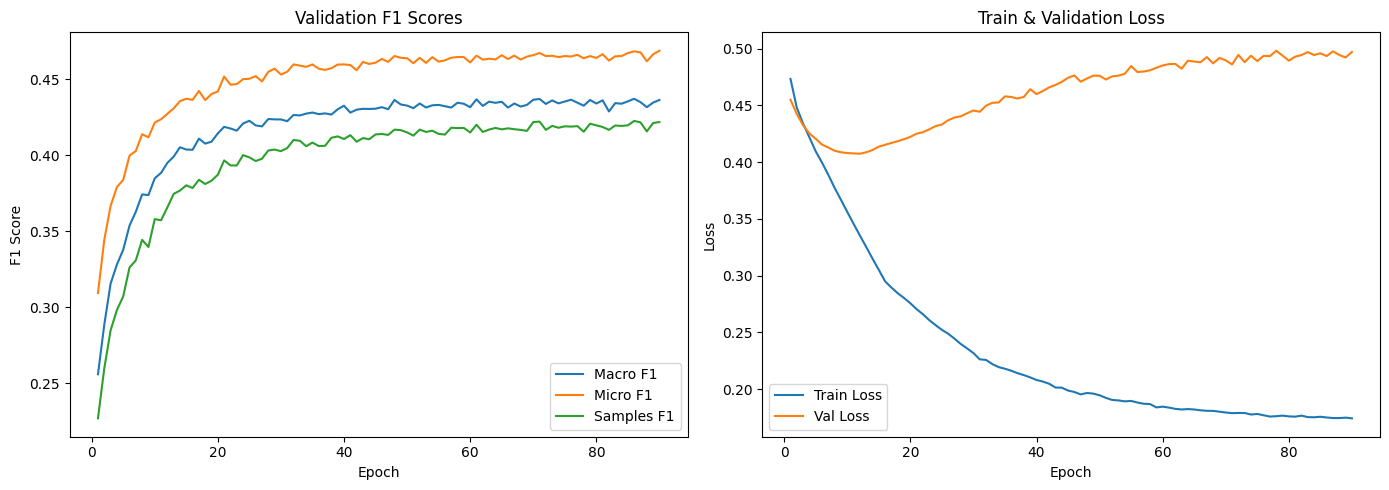

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(macro_f1s) + 1)

plt.figure(figsize=(14, 5))

# --- F1 scores ---
plt.subplot(1, 2, 1)
plt.plot(epochs, macro_f1s, label="Macro F1")
plt.plot(epochs, micro_f1s, label="Micro F1")
plt.plot(epochs, samples_f1s, label="Samples F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Scores")
plt.legend()

# --- Losses ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

# === Load genre labels from CSV ===
df = pd.read_csv("train_labels.csv")  # or multilabel_posters.csv
genre_labels = df.columns.tolist()[1:]
NUM_CLASSES = len(genre_labels)

# === Rebuild the model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_v2 = efficientnet_v2_s(weights=None)

in_features = efficientnet_v2.classifier[1].in_features
efficientnet_v2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.3),
    torch.nn.Linear(in_features, NUM_CLASSES)
)

efficientnet_v2.load_state_dict(torch.load("/content/drive/MyDrive/movie_model_checkpoints/efficientnetv245_best.pth"))
efficientnet_v2 = efficientnet_v2.to(device)
efficientnet_v2.eval()

# === Helper functions ===
def get_predictions(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.cpu().numpy()
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()

            all_labels.extend(labels)
            all_preds.extend(preds)

    return np.array(all_labels), np.array(all_preds)

def binarize_predictions(preds, threshold=0.5):
    return (preds >= threshold).astype(int)

# === Step 1: Get predictions ===
y_true_raw, y_probs_raw = get_predictions(efficientnet_v2, val_loader, device)

# === Step 2: Use best per-class thresholds (optional) ===
# You can load or recompute the best thresholds here if saved earlier:
# thresholds = np.load("/content/drive/MyDrive/movie_model_checkpoints/efficientnetv2_thresholds.npy")
# Otherwise, use a fixed threshold:
thresholds = 0.5
y_pred = binarize_predictions(y_probs_raw, thresholds)

# === Step 3: Print classification report ===
print(classification_report(y_true_raw, y_pred, target_names=genre_labels, zero_division=0))


              precision    recall  f1-score   support

      Action       0.78      0.66      0.72      1217
   Adventure       0.72      0.65      0.68       891
   Animation       0.93      0.94      0.94       562
   Biography       0.53      0.78      0.63       472
      Comedy       0.78      0.78      0.78      1125
       Crime       0.55      0.81      0.65       233
 Documentary       0.72      0.86      0.79       822
       Drama       0.74      0.64      0.69      1537
      Family       0.71      0.83      0.76       467
     Fantasy       0.63      0.75      0.68       485
     History       0.51      0.76      0.61       304
      Horror       0.79      0.82      0.81       860
       Music       0.66      0.79      0.72       470
     Mystery       0.51      0.77      0.61       533
     Romance       0.58      0.87      0.69       307
      Sci-Fi       0.70      0.82      0.75       458
       Sport       0.78      0.75      0.76       176
    Thriller       0.57    

In [ ]:
# Get raw predicted probabilities
y_true_raw, y_probs_raw = get_predictions(efficientnet_v2, val_loader, device)

# Threshold tuning
def find_best_thresholds(y_true, y_probs, thresholds=np.linspace(0.1, 0.9, 17)):
    best_thresholds = []
    for i in range(y_true.shape[1]):
        best_f1 = 0
        best_t = 0.5
        for t in thresholds:
            f1 = f1_score(y_true[:, i], (y_probs[:, i] >= t).astype(int), zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t
        best_thresholds.append(best_t)
    return np.array(best_thresholds)

best_thresholds_v2s = find_best_thresholds(y_true_raw, y_probs_raw)
y_pred_tuned = (y_probs_raw >= best_thresholds_v2s).astype(int)

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Load genre names
df = pd.read_csv("train_labels.csv")
genre_labels = df.columns.tolist()[1:]

# Print detailed per-class F1/Precision/Recall
print(classification_report(y_true_raw, y_pred_tuned, target_names=genre_labels, zero_division=0))

              precision    recall  f1-score   support

      Action       0.72      0.74      0.73      1217
   Adventure       0.65      0.72      0.68       891
   Animation       0.97      0.93      0.95       562
   Biography       0.77      0.65      0.70       472
      Comedy       0.78      0.78      0.78      1125
       Crime       0.84      0.71      0.77       233
 Documentary       0.81      0.82      0.81       822
       Drama       0.68      0.71      0.70      1537
      Family       0.86      0.75      0.81       467
     Fantasy       0.80      0.65      0.71       485
     History       0.82      0.67      0.74       304
      Horror       0.82      0.81      0.81       860
       Music       0.75      0.75      0.75       470
     Mystery       0.68      0.63      0.65       533
     Romance       0.84      0.76      0.80       307
      Sci-Fi       0.85      0.74      0.79       458
       Sport       0.90      0.73      0.81       176
    Thriller       0.55    

**BEST RESULTS FOR THE PROJECT**, 4-5-6-7 blocks trained, V2_S, 100 Epochs, threshold tuned.

We see here the best results we obtained yet, seems to be great numbers. V2-S model is of course a good model, certainly better than Resnet50. We also ran it for more epochs, and also opened up 4-5 blocks for training. We don't really want to do 1-2-3 as well, because we already know the later blocks are more important for what we want to do. And it will also be significantly more computationally expensive to try more blocks which is something we didn't have actually.

<ipython-input-33-da399dc9918c>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_f1, x="F1 Score", y="Genre", palette="viridis")


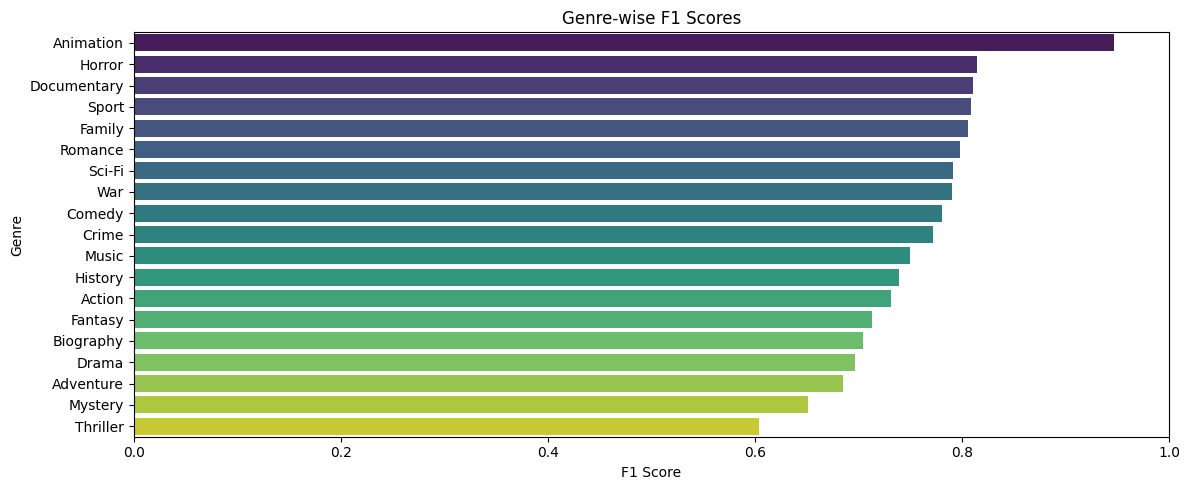

In [ ]:
from sklearn.metrics import f1_score

f1_per_class = f1_score(y_true_raw, y_pred_tuned, average=None)
df_f1 = pd.DataFrame({
    'Genre': genre_labels,
    'F1 Score': f1_per_class
}).sort_values("F1 Score", ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(data=df_f1, x="F1 Score", y="Genre", palette="viridis")
plt.title("Genre-wise F1 Scores")
plt.xlabel("F1 Score")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


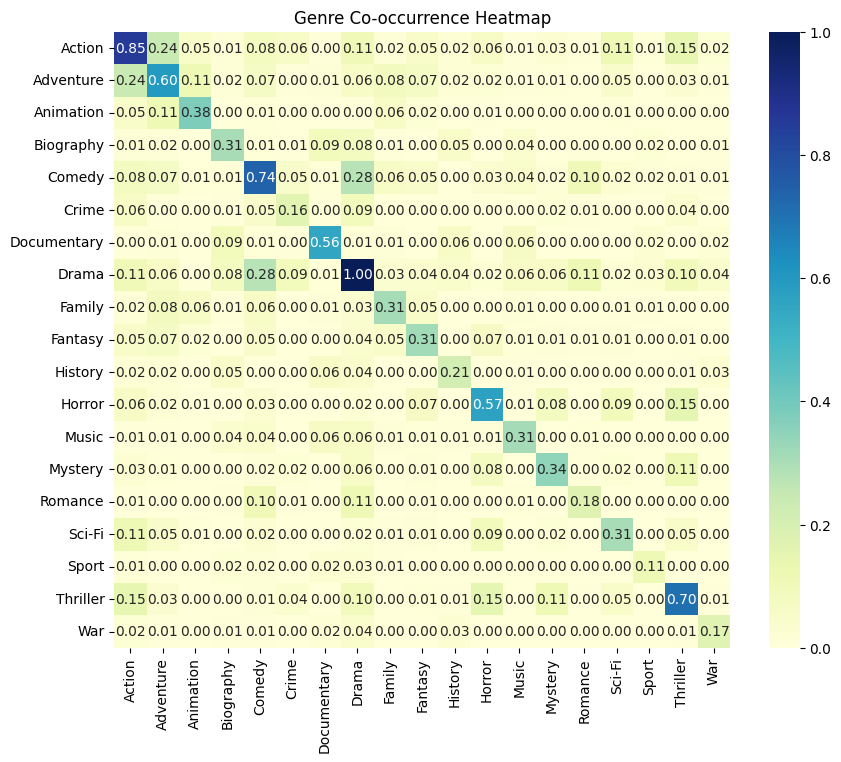

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your label dataframe (ground truth)
df = pd.read_csv("train_labels.csv")  # or val_labels.csv
genre_labels = df.columns[1:]
label_matrix = df[genre_labels].values

# Compute co-occurrence
co_occurrence = np.dot(label_matrix.T, label_matrix)

# Normalize
co_occurrence_normalized = co_occurrence / co_occurrence.max()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_normalized, xticklabels=genre_labels, yticklabels=genre_labels, cmap="YlGnBu", square=True, annot=True, fmt=".2f")
plt.title("Genre Co-occurrence Heatmap")
plt.show()


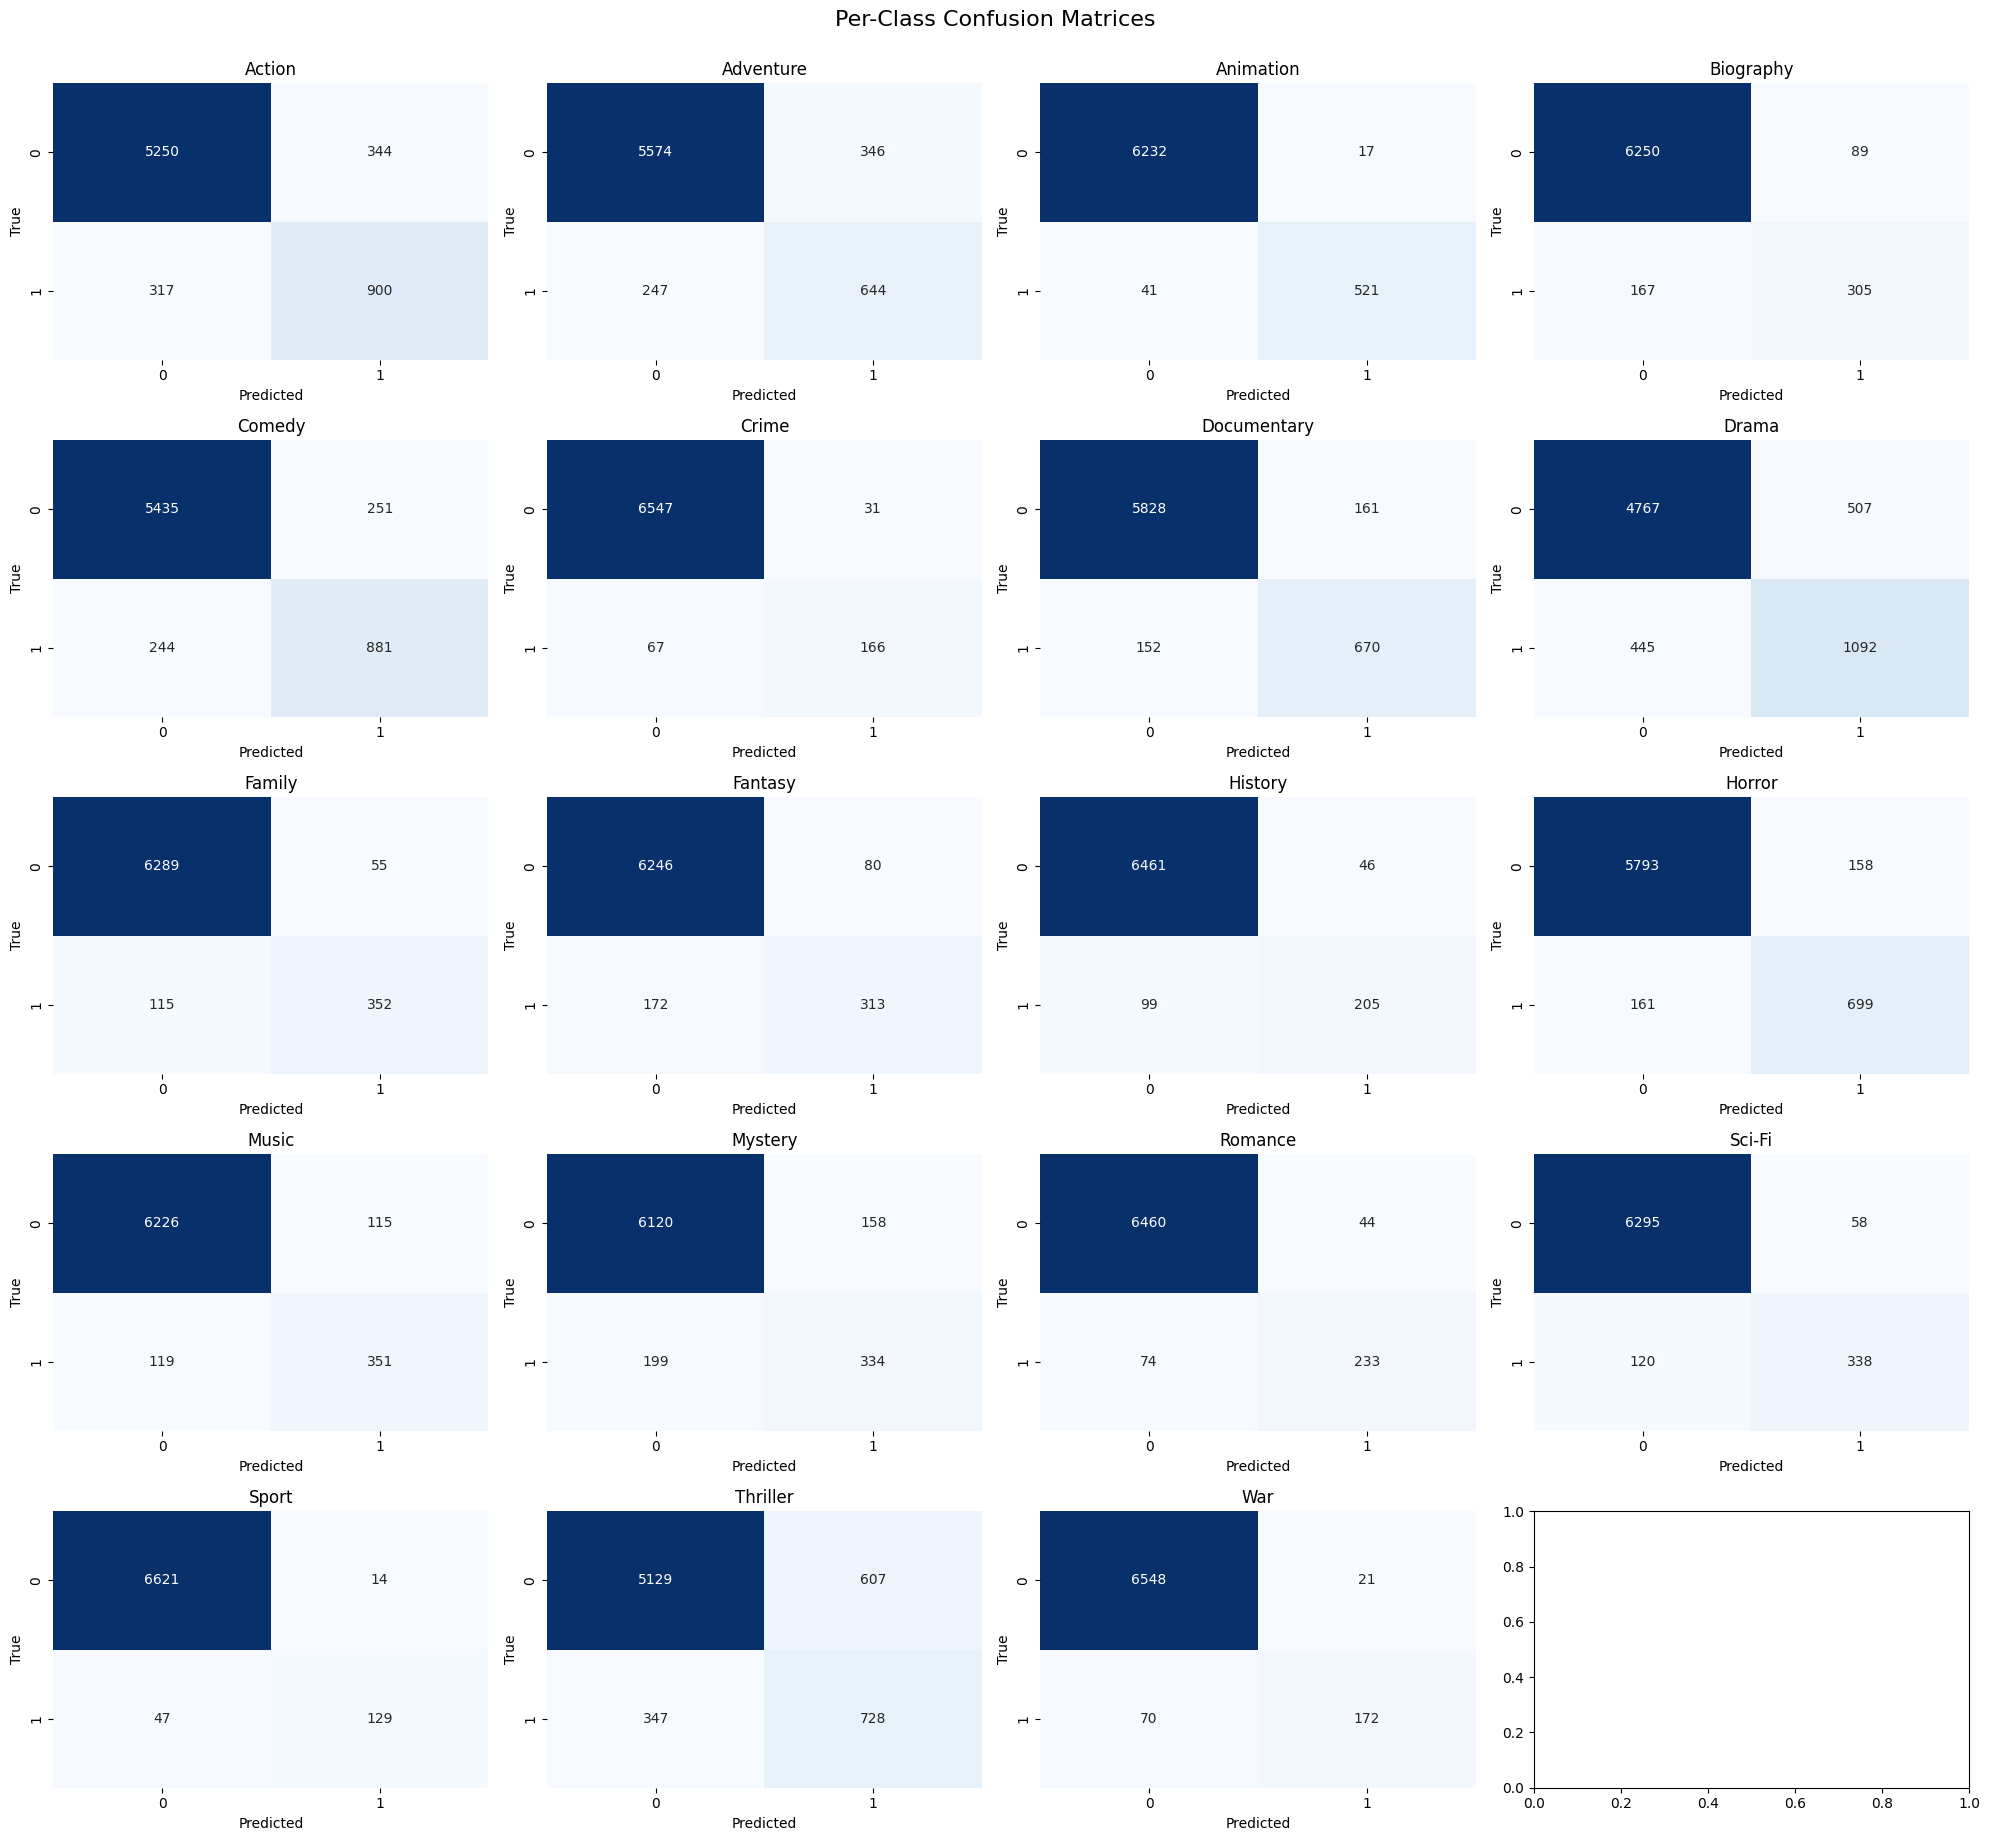

In [ ]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 18))
axes = axes.flatten()

mcm = multilabel_confusion_matrix(y_true_raw, y_pred_tuned)

for i, cm in enumerate(mcm):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
    axes[i].set_title(genre_labels[i])
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

plt.tight_layout()
plt.suptitle("Per-Class Confusion Matrices", y=1.02, fontsize=16)
plt.show()

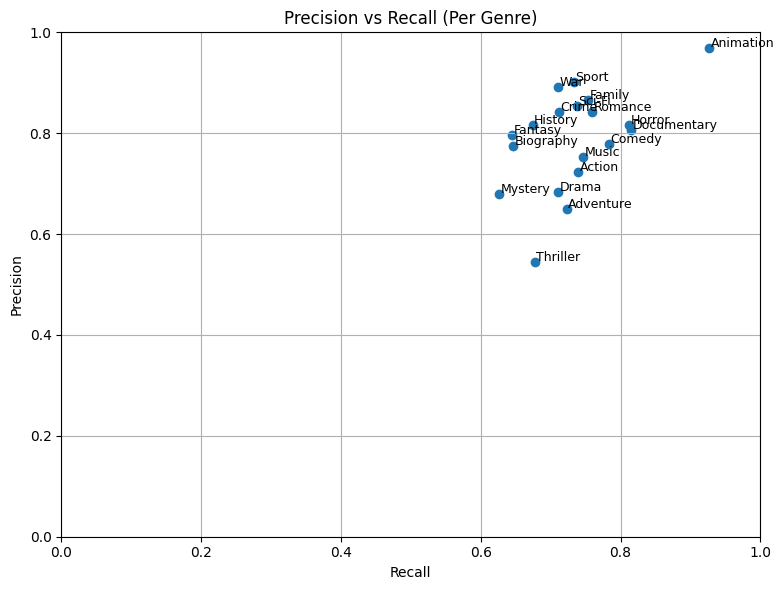

In [ ]:
from sklearn.metrics import precision_score, recall_score

precisions = precision_score(y_true_raw, y_pred_tuned, average=None, zero_division=0)
recalls = recall_score(y_true_raw, y_pred_tuned, average=None, zero_division=0)

plt.figure(figsize=(8, 6))
plt.scatter(recalls, precisions)

for i, label in enumerate(genre_labels):
    plt.text(recalls[i]+0.002, precisions[i]+0.002, label, fontsize=9)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall (Per Genre)")
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


#EfficientNet Setup - B0

In [ ]:
import torchvision.models as models
import torch.nn as nn

# Number of genres (columns in your label file minus 'filename')
NUM_CLASSES = len(genre_labels)

# Load pretrained EfficientNet-B0
efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Freeze all layers (optional)
for param in efficientnet.parameters():
    param.requires_grad = False

# Replace classifier with custom head for multi-label
efficientnet.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(efficientnet.classifier[1].in_features, NUM_CLASSES)
)

# Send to device
efficientnet = efficientnet.to(device)

print("✅ EfficientNet-B0 ready for training")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 205MB/s]

✅ EfficientNet-B0 ready for training


In [ ]:
import torch.optim as optim

# Loss for multi-label classification
criterion = nn.BCEWithLogitsLoss()

# Optimizer for classifier only (since rest is frozen)
optimizer = optim.Adam(efficientnet.classifier.parameters(), lr=1e-4)

print("✅ Loss and optimizer are set")

✅ Loss and optimizer are set


In [ ]:
from sklearn.metrics import f1_score

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.cpu().numpy()
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()

            loss = criterion(outputs, torch.tensor(labels).to(device).float())
            running_loss += loss.item() * images.size(0)

            all_labels.extend(labels)
            all_preds.extend(preds)

    val_loss = running_loss / len(dataloader.dataset)
    y_true = np.array(all_labels)
    y_pred = (np.array(all_preds) >= 0.5).astype(int)

    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    micro_f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)
    samples_f1 = f1_score(y_true, y_pred, average="samples", zero_division=0)

    return val_loss, macro_f1, micro_f1, samples_f1


In [ ]:
# Step 2: Unfreeze only blocks 6 and 7 (fine-tuning)
for name, param in efficientnet.features.named_parameters():
    if "6" in name or "7" in name:
        param.requires_grad = True

# Step 3: Set up optimizer with only the unfrozen parameters
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, efficientnet.parameters()),
    lr=1e-5
)

In [ ]:
import os
import copy
import numpy as np
import torch

# === 1. Setup Save Directory ===
save_dir = "/content/drive/MyDrive/movie_model_checkpoints/efficientnet_b0"
os.makedirs(save_dir, exist_ok=True)

# === 2. FREEZE all layers initially ===
for param in efficientnet.parameters():
    param.requires_grad = False

# Unfreeze the classifier head
for param in efficientnet.classifier.parameters():
    param.requires_grad = True

# === 3. Optimizer and Loss (use pos_weight if available) ===
# pos_weights should already be on device
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = optim.Adam(efficientnet.classifier.parameters(), lr=1e-4)

# === 4. Stage 1: Train only classifier (frozen backbone) ===
EPOCHS_FROZEN = 10
best_macro_f1 = 0.0
best_model_wts = copy.deepcopy(efficientnet.state_dict())

train_losses = []
val_losses = []
macro_f1s = []
micro_f1s = []
samples_f1s = []

for epoch in range(EPOCHS_FROZEN):
    train_loss = train_one_epoch(efficientnet, train_loader, optimizer, criterion, device)
    val_loss, macro_f1, micro_f1, samples_f1 = evaluate(efficientnet, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    macro_f1s.append(macro_f1)
    micro_f1s.append(micro_f1)
    samples_f1s.append(samples_f1)

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_model_wts = copy.deepcopy(efficientnet.state_dict())
        torch.save(best_model_wts, os.path.join(save_dir, "efficientnet_b0_best.pth"))

    print(f"[EFF-B0-FROZEN] Epoch {epoch+1}/{EPOCHS_FROZEN} → "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Macro F1: {macro_f1:.4f} | Micro F1: {micro_f1:.4f} | Samples F1: {samples_f1:.4f}")

# === 5. UNFREEZE last few blocks (e.g., blocks 6 and 7) ===
for name, param in efficientnet.features.named_parameters():
    if "6" in name or "7" in name:
        param.requires_grad = True

# === 6. Refine optimizer with lower learning rate ===
optimizer = optim.Adam(filter(lambda p: p.requires_grad, efficientnet.parameters()), lr=1e-5)

# === 7. Stage 2: Fine-tune entire top layers ===
EPOCHS_FTUNE = 20
for epoch in range(EPOCHS_FTUNE):
    train_loss = train_one_epoch(efficientnet, train_loader, optimizer, criterion, device)
    val_loss, macro_f1, micro_f1, samples_f1 = evaluate(efficientnet, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    macro_f1s.append(macro_f1)
    micro_f1s.append(micro_f1)
    samples_f1s.append(samples_f1)

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_model_wts = copy.deepcopy(efficientnet.state_dict())
        torch.save(best_model_wts, os.path.join(save_dir, "efficientnet_b0_best.pth"))

    print(f"[EFF-B0-FTUNE] Epoch {epoch+1}/{EPOCHS_FTUNE} → "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Macro F1: {macro_f1:.4f} | Micro F1: {micro_f1:.4f} | Samples F1: {samples_f1:.4f}")

# === 8. Save Metrics ===
np.save(os.path.join(save_dir, "train_losses.npy"), np.array(train_losses))
np.save(os.path.join(save_dir, "val_losses.npy"), np.array(val_losses))
np.save(os.path.join(save_dir, "macro_f1s.npy"), np.array(macro_f1s))
np.save(os.path.join(save_dir, "micro_f1s.npy"), np.array(micro_f1s))
np.save(os.path.join(save_dir, "samples_f1s.npy"), np.array(samples_f1s))

print("✅ EfficientNet-B0 (2-stage) training complete and saved.")



[EFF-B0-FROZEN] Epoch 1/10 → Train Loss: 0.3926 | Val Loss: 0.4302 | Macro F1: 0.3463 | Micro F1: 0.3968 | Samples F1: 0.3318


[EFF-B0-FROZEN] Epoch 2/10 → Train Loss: 0.3923 | Val Loss: 0.4294 | Macro F1: 0.3529 | Micro F1: 0.4051 | Samples F1: 0.3367


[EFF-B0-FROZEN] Epoch 3/10 → Train Loss: 0.3919 | Val Loss: 0.4300 | Macro F1: 0.3455 | Micro F1: 0.3955 | Samples F1: 0.3329


[EFF-B0-FROZEN] Epoch 4/10 → Train Loss: 0.3909 | Val Loss: 0.4291 | Macro F1: 0.3484 | Micro F1: 0.4039 | Samples F1: 0.3390


[EFF-B0-FROZEN] Epoch 5/10 → Train Loss: 0.3902 | Val Loss: 0.4269 | Macro F1: 0.3569 | Micro F1: 0.4034 | Samples F1: 0.3409


[EFF-B0-FROZEN] Epoch 6/10 → Train Loss: 0.3896 | Val Loss: 0.4289 | Macro F1: 0.3562 | Micro F1: 0.4034 | Samples F1: 0.3418


[EFF-B0-FROZEN] Epoch 7/10 → Train Loss: 0.3889 | Val Loss: 0.4278 | Macro F1: 0.3576 | Micro F1: 0.4068 | Samples F1: 0.3451


[EFF-B0-FROZEN] Epoch 8/10 → Train Loss: 0.3884 | Val Loss: 0.4295 | Macro F1: 0.3520 | Micro F1: 0.3981 | Samples F1: 0.3358


[EFF-B0-FROZEN] Epoch 9/10 → Train Loss: 0.3876 | Val Loss: 0.4303 | Macro F1: 0.3532 | Micro F1: 0.4008 | Samples F1: 0.3397


[EFF-B0-FROZEN] Epoch 10/10 → Train Loss: 0.3878 | Val Loss: 0.4301 | Macro F1: 0.3515 | Micro F1: 0.4014 | Samples F1: 0.3373


[EFF-B0-FTUNE] Epoch 1/20 → Train Loss: 0.3867 | Val Loss: 0.4297 | Macro F1: 0.3532 | Micro F1: 0.4013 | Samples F1: 0.3366


[EFF-B0-FTUNE] Epoch 2/20 → Train Loss: 0.3850 | Val Loss: 0.4289 | Macro F1: 0.3602 | Micro F1: 0.4035 | Samples F1: 0.3396


[EFF-B0-FTUNE] Epoch 3/20 → Train Loss: 0.3808 | Val Loss: 0.4285 | Macro F1: 0.3550 | Micro F1: 0.4028 | Samples F1: 0.3378


[EFF-B0-FTUNE] Epoch 4/20 → Train Loss: 0.3801 | Val Loss: 0.4275 | Macro F1: 0.3556 | Micro F1: 0.4011 | Samples F1: 0.3368


[EFF-B0-FTUNE] Epoch 5/20 → Train Loss: 0.3756 | Val Loss: 0.4290 | Macro F1: 0.3549 | Micro F1: 0.4014 | Samples F1: 0.3350


[EFF-B0-FTUNE] Epoch 6/20 → Train Loss: 0.3743 | Val Loss: 0.4278 | Macro F1: 0.3591 | Micro F1: 0.4049 | Samples F1: 0.3389


[EFF-B0-FTUNE] Epoch 7/20 → Train Loss: 0.3714 | Val Loss: 0.4273 | Macro F1: 0.3595 | Micro F1: 0.4037 | Samples F1: 0.3395


[EFF-B0-FTUNE] Epoch 8/20 → Train Loss: 0.3699 | Val Loss: 0.4300 | Macro F1: 0.3581 | Micro F1: 0.4013 | Samples F1: 0.3373


[EFF-B0-FTUNE] Epoch 9/20 → Train Loss: 0.3674 | Val Loss: 0.4278 | Macro F1: 0.3609 | Micro F1: 0.4067 | Samples F1: 0.3431


[EFF-B0-FTUNE] Epoch 10/20 → Train Loss: 0.3649 | Val Loss: 0.4296 | Macro F1: 0.3671 | Micro F1: 0.4099 | Samples F1: 0.3466


[EFF-B0-FTUNE] Epoch 11/20 → Train Loss: 0.3634 | Val Loss: 0.4323 | Macro F1: 0.3650 | Micro F1: 0.4077 | Samples F1: 0.3410


[EFF-B0-FTUNE] Epoch 12/20 → Train Loss: 0.3623 | Val Loss: 0.4256 | Macro F1: 0.3699 | Micro F1: 0.4119 | Samples F1: 0.3502


[EFF-B0-FTUNE] Epoch 13/20 → Train Loss: 0.3583 | Val Loss: 0.4283 | Macro F1: 0.3652 | Micro F1: 0.4115 | Samples F1: 0.3480


[EFF-B0-FTUNE] Epoch 14/20 → Train Loss: 0.3573 | Val Loss: 0.4310 | Macro F1: 0.3675 | Micro F1: 0.4091 | Samples F1: 0.3482


[EFF-B0-FTUNE] Epoch 15/20 → Train Loss: 0.3544 | Val Loss: 0.4308 | Macro F1: 0.3677 | Micro F1: 0.4111 | Samples F1: 0.3469


[EFF-B0-FTUNE] Epoch 16/20 → Train Loss: 0.3529 | Val Loss: 0.4294 | Macro F1: 0.3725 | Micro F1: 0.4127 | Samples F1: 0.3515


[EFF-B0-FTUNE] Epoch 17/20 → Train Loss: 0.3495 | Val Loss: 0.4334 | Macro F1: 0.3685 | Micro F1: 0.4091 | Samples F1: 0.3464


[EFF-B0-FTUNE] Epoch 18/20 → Train Loss: 0.3474 | Val Loss: 0.4315 | Macro F1: 0.3711 | Micro F1: 0.4135 | Samples F1: 0.3509


[EFF-B0-FTUNE] Epoch 19/20 → Train Loss: 0.3457 | Val Loss: 0.4326 | Macro F1: 0.3725 | Micro F1: 0.4094 | Samples F1: 0.3492


[EFF-B0-FTUNE] Epoch 20/20 → Train Loss: 0.3444 | Val Loss: 0.4319 | Macro F1: 0.3742 | Micro F1: 0.4119 | Samples F1: 0.3512
✅ EfficientNet-B0 (2-stage) training complete and saved.


**EfficientNet-B0 Initial Thoughts** - After obtaining a good result with the V2-S we wanted to see B0 as well, but it is actually a worse model than v2-s, so here we ran this for small epochs, but we did see that the results are not actually that good in comparison, around the same epochs. We were going to run for 100 epochs anyway but the GPU limitations made it difficult

In [ ]:
import numpy as np
save_dir = "/content/drive/MyDrive/movie_model_checkpoints/efficientnet_b0"

train_losses = np.load(os.path.join(save_dir, "train_losses.npy"))
val_losses = np.load(os.path.join(save_dir, "val_losses.npy"))
macro_f1s = np.load(os.path.join(save_dir, "macro_f1s.npy"))
micro_f1s = np.load(os.path.join(save_dir, "micro_f1s.npy"))
samples_f1s = np.load(os.path.join(save_dir, "samples_f1s.npy"))

print("✅ Training metrics loaded.")

✅ Training metrics loaded.


In [ ]:
# Step 1: Get model predictions
y_true_raw, y_pred_raw = get_predictions(efficientnet, val_loader, device)

# Step 2: Binarize the outputs
y_true = y_true_raw
y_pred = binarize_predictions(y_pred_raw, threshold=0.5)

# Step 3: Load genre names
df = pd.read_csv("train_labels.csv")  # or multilabel_posters.csv
genre_labels = df.columns.tolist()[1:]

# Step 4: Show report
print(classification_report(y_true, y_pred, target_names=genre_labels, zero_division=0))


              precision    recall  f1-score   support

      Action       0.69      0.49      0.57      1217
   Adventure       0.57      0.43      0.49       891
   Animation       0.85      0.89      0.87       562
   Biography       0.43      0.33      0.37       472
      Comedy       0.74      0.55      0.63      1125
       Crime       0.36      0.75      0.49       233
 Documentary       0.57      0.64      0.60       822
       Drama       0.75      0.40      0.52      1537
      Family       0.47      0.65      0.55       467
     Fantasy       0.42      0.24      0.31       485
     History       0.33      0.44      0.38       304
      Horror       0.65      0.64      0.64       860
       Music       0.44      0.33      0.38       470
     Mystery       0.37      0.33      0.35       533
     Romance       0.45      0.77      0.57       307
      Sci-Fi       0.47      0.47      0.47       458
       Sport       0.32      0.61      0.42       176
    Thriller       0.52    

In [ ]:
# Re-initialize model structure if session restarted
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn

efficientnet = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
in_features = efficientnet.classifier[1].in_features
NUM_CLASSES = len(genre_labels)
efficientnet.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, NUM_CLASSES)
)
efficientnet = efficientnet.to(device)

# Load best weights
efficientnet.load_state_dict(torch.load("/content/drive/MyDrive/movie_model_checkpoints/efficientnet_b0/efficientnet_b0_best.pth"))
efficientnet.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Get predictions on validation set
y_true_raw, y_probs_raw = get_predictions(efficientnet, val_loader, device)
best_thresholds_effnet = find_best_thresholds(y_true_raw, y_probs_raw)
y_pred_tuned = (y_probs_raw >= best_thresholds_effnet).astype(int)
df = pd.read_csv("train_labels.csv")
genre_labels = df.columns.tolist()[1:]

print(classification_report(y_true_raw, y_pred_tuned, target_names=genre_labels, zero_division=0))


              precision    recall  f1-score   support

      Action       0.58      0.64      0.61      1217
   Adventure       0.52      0.55      0.54       891
   Animation       0.90      0.84      0.87       562
   Biography       0.30      0.55      0.39       472
      Comedy       0.65      0.67      0.66      1125
       Crime       0.44      0.61      0.51       233
 Documentary       0.54      0.68      0.60       822
       Drama       0.56      0.70      0.62      1537
      Family       0.54      0.56      0.55       467
     Fantasy       0.32      0.38      0.35       485
     History       0.33      0.44      0.38       304
      Horror       0.62      0.68      0.65       860
       Music       0.43      0.42      0.42       470
     Mystery       0.35      0.43      0.39       533
     Romance       0.48      0.74      0.58       307
      Sci-Fi       0.47      0.47      0.47       458
       Sport       0.54      0.42      0.47       176
    Thriller       0.44    

**Results** - We do actually see some good results here, but the v2-s seems to be a better option regardless

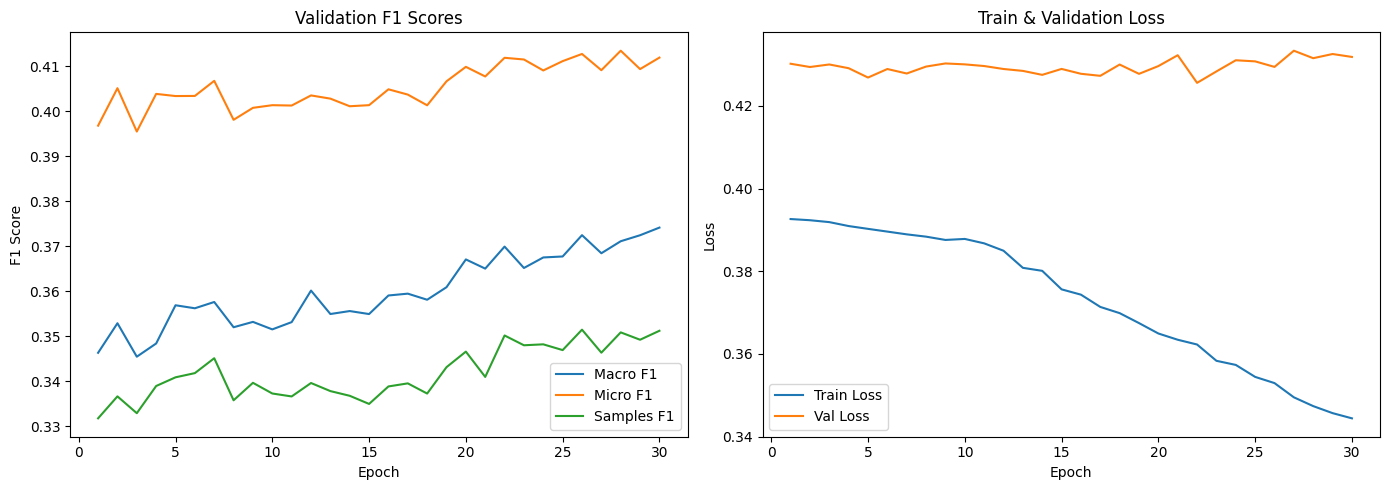

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(macro_f1s) + 1)

plt.figure(figsize=(14, 5))

# --- F1 scores ---
plt.subplot(1, 2, 1)
plt.plot(epochs, macro_f1s, label="Macro F1")
plt.plot(epochs, micro_f1s, label="Micro F1")
plt.plot(epochs, samples_f1s, label="Samples F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Scores")
plt.legend()

# --- Losses ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


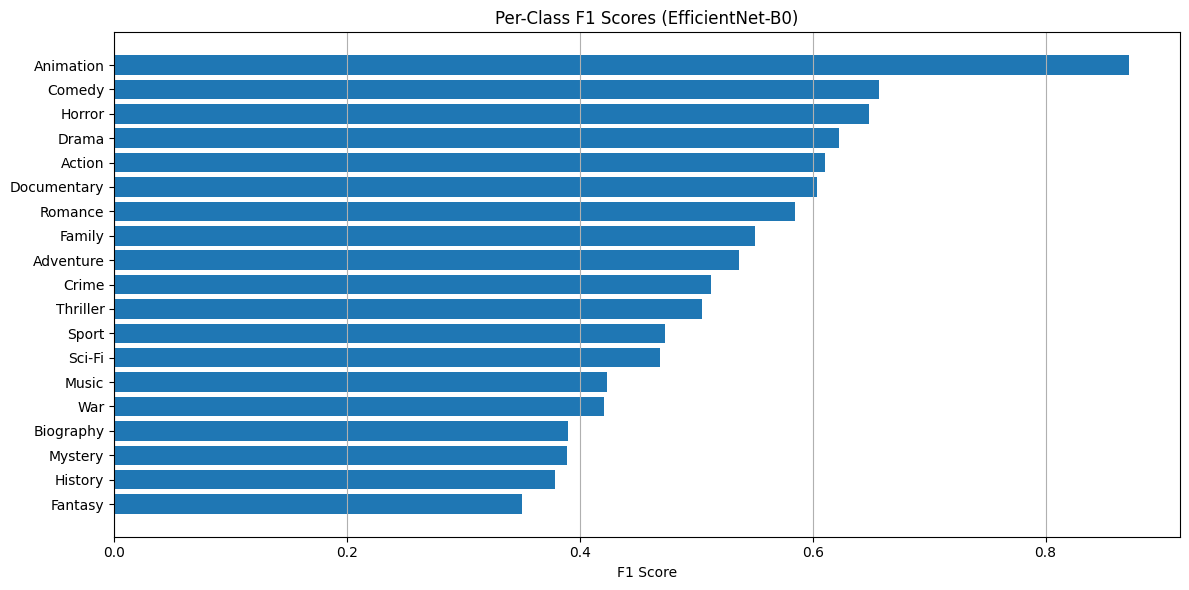

In [ ]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load genre labels
df = pd.read_csv("train_labels.csv")
genre_labels = df.columns.tolist()[1:]

# Compute per-class F1 scores
f1_per_class = f1_score(y_true_raw, y_pred_tuned, average=None, zero_division=0)

# Sort scores by descending value
sorted_idx = np.argsort(f1_per_class)[::-1]
sorted_labels = [genre_labels[i] for i in sorted_idx]
sorted_scores = f1_per_class[sorted_idx]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(sorted_labels[::-1], sorted_scores[::-1])  # Flip for highest on top
plt.xlabel("F1 Score")
plt.title("Per-Class F1 Scores (EfficientNet-B0)")
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()


In [ ]:
# Combine with support count
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1s, support = precision_recall_fscore_support(
    y_true_raw, y_pred_tuned, average=None, zero_division=0
)

import pandas as pd
metrics_df = pd.DataFrame({
    "Genre": genre_labels,
    "F1": f1s,
    "Precision": precision,
    "Recall": recall,
    "Support": support
}).sort_values(by="F1")

print("🔻 Worst-performing classes:")
print(metrics_df.head(5).to_string(index=False))

🔻 Worst-performing classes:
    Genre       F1  Precision   Recall  Support
  Fantasy 0.350047   0.323427 0.381443      485
  History 0.378682   0.330073 0.444079      304
  Mystery 0.388842   0.353846 0.431520      533
Biography 0.389805   0.301624 0.550847      472
      War 0.420677   0.369906 0.487603      242


#VGG Implementation (THE MAIN PART WE USE)

In [ ]:
import os
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# === 0. Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = "/content/drive/MyDrive/movie_model_checkpoints/vgg16"
os.makedirs(save_dir, exist_ok=True)

# === 1. Load Pretrained VGG16 ===
vgg = models.vgg16(pretrained=True)
vgg.classifier[6] = nn.Linear(4096, 19)  # Replace final layer
vgg = vgg.to(device)

# === 2. Freeze all layers initially ===
for param in vgg.features.parameters():
    param.requires_grad = False

# === 3. Loss and Optimizer (Stage 1) ===
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
optimizer = optim.Adam(vgg.classifier.parameters(), lr=1e-4)

# === 4. Train only classifier head (10 epochs) ===
EPOCHS_STAGE1 = 10
best_macro_f1 = 0.0
best_model_wts = copy.deepcopy(vgg.state_dict())

train_losses, val_losses = [], []
macro_f1s, micro_f1s, samples_f1s = [], [], []

for epoch in range(EPOCHS_STAGE1):
    train_loss = train_one_epoch(vgg, train_loader, optimizer, criterion, device)
    val_loss, macro_f1, micro_f1, samples_f1 = evaluate(vgg, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    macro_f1s.append(macro_f1)
    micro_f1s.append(micro_f1)
    samples_f1s.append(samples_f1)

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_model_wts = copy.deepcopy(vgg.state_dict())
        torch.save(best_model_wts, os.path.join(save_dir, "vgg16_best.pth"))

    print(f"[VGG16-FROZEN] Epoch {epoch+1}/{EPOCHS_STAGE1} → "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Macro F1: {macro_f1:.4f} | Micro F1: {micro_f1:.4f} | Samples F1: {samples_f1:.4f}")

# === 5. Unfreeze later convolution blocks (for fine-tuning) ===
for name, param in vgg.features.named_parameters():
    if "24" in name or "25" in name or "26" in name or "27" in name or "28" in name:  # Last conv block
        param.requires_grad = True

# === 6. Optimizer (Stage 2) ===
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vgg.parameters()), lr=1e-5)

# === 7. Fine-tuning (10 epochs) ===
EPOCHS_STAGE2 = 10

for epoch in range(EPOCHS_STAGE2):
    train_loss = train_one_epoch(vgg, train_loader, optimizer, criterion, device)
    val_loss, macro_f1, micro_f1, samples_f1 = evaluate(vgg, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    macro_f1s.append(macro_f1)
    micro_f1s.append(micro_f1)
    samples_f1s.append(samples_f1)

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_model_wts = copy.deepcopy(vgg.state_dict())
        torch.save(best_model_wts, os.path.join(save_dir, "vgg16_best.pth"))

    print(f"[VGG16-FINETUNE] Epoch {epoch+1}/{EPOCHS_STAGE2} → "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Macro F1: {macro_f1:.4f} | Micro F1: {micro_f1:.4f} | Samples F1: {samples_f1:.4f}")

# === 8. Save Metrics ===
np.save(os.path.join(save_dir, "train_losses.npy"), np.array(train_losses))
np.save(os.path.join(save_dir, "val_losses.npy"), np.array(val_losses))
np.save(os.path.join(save_dir, "macro_f1s.npy"), np.array(macro_f1s))
np.save(os.path.join(save_dir, "micro_f1s.npy"), np.array(micro_f1s))
np.save(os.path.join(save_dir, "samples_f1s.npy"), np.array(samples_f1s))

print("✅ VGG16 (2-stage) training complete and saved.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[VGG16-FROZEN] Epoch 1/10 → Train Loss: 0.4967 | Val Loss: 0.4638 | Macro F1: 0.2231 | Micro F1: 0.2753 | Samples F1: 0.1982


[VGG16-FROZEN] Epoch 2/10 → Train Loss: 0.4581 | Val Loss: 0.4523 | Macro F1: 0.2658 | Micro F1: 0.3218 | Samples F1: 0.2470


[VGG16-FROZEN] Epoch 3/10 → Train Loss: 0.4323 | Val Loss: 0.4539 | Macro F1: 0.2878 | Micro F1: 0.3096 | Samples F1: 0.2499


[VGG16-FROZEN] Epoch 4/10 → Train Loss: 0.4102 | Val Loss: 0.4477 | Macro F1: 0.3275 | Micro F1: 0.3551 | Samples F1: 0.2931


[VGG16-FROZEN] Epoch 5/10 → Train Loss: 0.3844 | Val Loss: 0.4490 | Macro F1: 0.3278 | Micro F1: 0.3522 | Samples F1: 0.3006


[VGG16-FROZEN] Epoch 6/10 → Train Loss: 0.3604 | Val Loss: 0.4534 | Macro F1: 0.3441 | Micro F1: 0.3792 | Samples F1: 0.3246


[VGG16-FROZEN] Epoch 7/10 → Train Loss: 0.3311 | Val Loss: 0.4626 | Macro F1: 0.3627 | Micro F1: 0.3843 | Samples F1: 0.3360


[VGG16-FROZEN] Epoch 8/10 → Train Loss: 0.3047 | Val Loss: 0.4823 | Macro F1: 0.3626 | Micro F1: 0.3933 | Samples F1: 0.3462


[VGG16-FROZEN] Epoch 9/10 → Train Loss: 0.2822 | Val Loss: 0.5024 | Macro F1: 0.3689 | Micro F1: 0.4091 | Samples F1: 0.3602


[VGG16-FROZEN] Epoch 10/10 → Train Loss: 0.2598 | Val Loss: 0.5233 | Macro F1: 0.3660 | Micro F1: 0.3977 | Samples F1: 0.3550


[VGG16-FINETUNE] Epoch 1/10 → Train Loss: 0.2124 | Val Loss: 0.5524 | Macro F1: 0.3857 | Micro F1: 0.4238 | Samples F1: 0.3763


[VGG16-FINETUNE] Epoch 2/10 → Train Loss: 0.1917 | Val Loss: 0.5694 | Macro F1: 0.3921 | Micro F1: 0.4291 | Samples F1: 0.3821


[VGG16-FINETUNE] Epoch 3/10 → Train Loss: 0.1795 | Val Loss: 0.5827 | Macro F1: 0.3896 | Micro F1: 0.4297 | Samples F1: 0.3802


[VGG16-FINETUNE] Epoch 4/10 → Train Loss: 0.1713 | Val Loss: 0.6041 | Macro F1: 0.3877 | Micro F1: 0.4262 | Samples F1: 0.3765


[VGG16-FINETUNE] Epoch 5/10 → Train Loss: 0.1633 | Val Loss: 0.6165 | Macro F1: 0.3913 | Micro F1: 0.4312 | Samples F1: 0.3829


[VGG16-FINETUNE] Epoch 6/10 → Train Loss: 0.1567 | Val Loss: 0.6382 | Macro F1: 0.3941 | Micro F1: 0.4356 | Samples F1: 0.3866


[VGG16-FINETUNE] Epoch 7/10 → Train Loss: 0.1494 | Val Loss: 0.6454 | Macro F1: 0.3955 | Micro F1: 0.4337 | Samples F1: 0.3844


[VGG16-FINETUNE] Epoch 8/10 → Train Loss: 0.1438 | Val Loss: 0.6506 | Macro F1: 0.3962 | Micro F1: 0.4355 | Samples F1: 0.3891


[VGG16-FINETUNE] Epoch 9/10 → Train Loss: 0.1374 | Val Loss: 0.6735 | Macro F1: 0.3972 | Micro F1: 0.4392 | Samples F1: 0.3882


[VGG16-FINETUNE] Epoch 10/10 → Train Loss: 0.1334 | Val Loss: 0.6955 | Macro F1: 0.3964 | Micro F1: 0.4426 | Samples F1: 0.3933
✅ VGG16 (2-stage) training complete and saved.


In [ ]:
# === 1. Set model to eval mode and move to device ===
vgg16.eval()
vgg16.to(device)

# === 2. Inference on val_loader ===
all_targets = []
all_outputs = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = vgg16(inputs)  # raw logits
        all_targets.append(targets.cpu())
        all_outputs.append(torch.sigmoid(outputs).cpu())  # apply sigmoid

# === 3. Concatenate predictions and targets ===
y_true = torch.cat(all_targets, dim=0).numpy()
y_scores = torch.cat(all_outputs, dim=0).numpy()

# === 4. Apply threshold (default 0.5 or tuned thresholds) ===
y_pred = (y_scores >= 0.5).astype(int)

# === 5. Get classification report ===
genre_names = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy',
               'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
               'History', 'Horror', 'Music', 'Mystery', 'Romance',
               'Sci-Fi', 'Sport', 'Thriller', 'War']

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=genre_names, digits=2))


              precision    recall  f1-score   support

      Action       0.59      0.23      0.33      1217
   Adventure       0.60      0.05      0.10       891
   Animation       0.88      0.64      0.74       562
   Biography       0.00      0.00      0.00       472
      Comedy       0.70      0.25      0.37      1125
       Crime       0.36      0.02      0.03       233
 Documentary       0.47      0.12      0.19       822
       Drama       0.67      0.21      0.32      1537
      Family       0.67      0.03      0.05       467
     Fantasy       0.00      0.00      0.00       485
     History       0.00      0.00      0.00       304
      Horror       0.54      0.29      0.38       860
       Music       0.00      0.00      0.00       470
     Mystery       0.00      0.00      0.00       533
     Romance       0.64      0.02      0.04       307
      Sci-Fi       1.00      0.00      0.01       458
       Sport       0.00      0.00      0.00       176
    Thriller       0.45    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Get raw predicted probabilities
y_true_raw, y_probs_raw = get_predictions(vgg16, val_loader, device)

# Threshold tuning
def find_best_thresholds(y_true, y_probs, thresholds=np.linspace(0.1, 0.9, 17)):
    best_thresholds = []
    for i in range(y_true.shape[1]):
        best_f1 = 0
        best_t = 0.5
        for t in thresholds:
            f1 = f1_score(y_true[:, i], (y_probs[:, i] >= t).astype(int), zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t
        best_thresholds.append(best_t)
    return np.array(best_thresholds)

best_thresholds_v2s = find_best_thresholds(y_true_raw, y_probs_raw)
y_pred_tuned = (y_probs_raw >= best_thresholds_v2s).astype(int)

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Load genre names
df = pd.read_csv("train_labels.csv")
genre_labels = df.columns.tolist()[1:]

# Print detailed per-class F1/Precision/Recall
print(classification_report(y_true_raw, y_pred_tuned, target_names=genre_labels, zero_division=0))

              precision    recall  f1-score   support

      Action       0.42      0.53      0.47      1217
   Adventure       0.30      0.55      0.38       891
   Animation       0.79      0.71      0.74       562
   Biography       0.13      0.53      0.21       472
      Comedy       0.50      0.56      0.53      1125
       Crime       0.34      0.25      0.29       233
 Documentary       0.33      0.49      0.40       822
       Drama       0.47      0.53      0.50      1537
      Family       0.29      0.48      0.36       467
     Fantasy       0.15      0.46      0.22       485
     History       0.10      0.18      0.13       304
      Horror       0.38      0.62      0.47       860
       Music       0.18      0.29      0.22       470
     Mystery       0.16      0.41      0.23       533
     Romance       0.38      0.42      0.40       307
      Sci-Fi       0.21      0.42      0.28       458
       Sport       0.11      0.02      0.04       176
    Thriller       0.28    

In [ ]:
from torchvision import models
import torch.nn as nn

# Load VGG16 with pretrained ImageNet weights
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Freeze the feature extractor (optional first step)
for param in vgg16.features.parameters():
    param.requires_grad = False

# Replace classifier with custom head for multi-label
NUM_CLASSES = 19

vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, NUM_CLASSES)
)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 245MB/s]


In [ ]:
vgg16 = vgg16.to(device)

In [ ]:
import torch.optim as optim

# Multi-label loss
criterion = nn.BCEWithLogitsLoss()

# Optimizer for just the classifier head (since we froze the features)
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=1e-4)

print("✅ Loss and optimizer ready for VGG16")

✅ Loss and optimizer ready for VGG16


#VGG Evaluation

✅ F1 (micro): 0.4058
✅ F1 (macro): 0.3354
✅ Precision (macro): 0.4829
✅ Recall (macro): 0.2770


<ipython-input-30-eff650badd23>:56: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


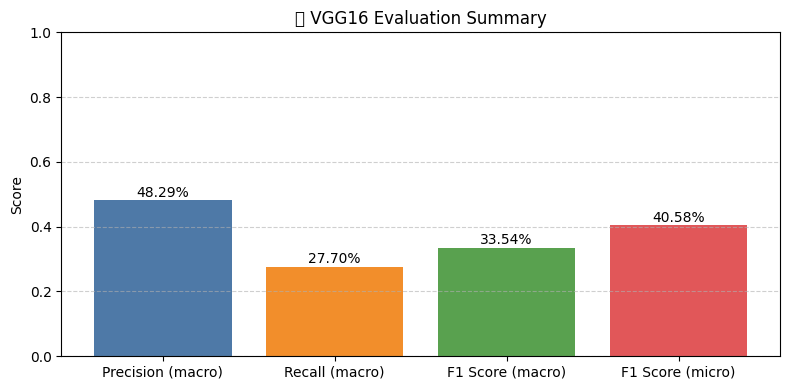

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Step 1: Get predictions and binarize
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.cpu().numpy()
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    return np.array(all_labels), np.array(all_preds)

# Step 2: Plot overall evaluation
def plot_overall_metrics(y_true, y_pred):
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    print(f"✅ F1 (micro): {f1_micro:.4f}")
    print(f"✅ F1 (macro): {f1_macro:.4f}")
    print(f"✅ Precision (macro): {precision:.4f}")
    print(f"✅ Recall (macro): {recall:.4f}")

    metrics = {
        'Precision (macro)': precision,
        'Recall (macro)': recall,
        'F1 Score (macro)': f1_macro,
        'F1 Score (micro)': f1_micro
    }

    df_metrics = pd.DataFrame(metrics.items(), columns=['Metric', 'Score'])

    plt.figure(figsize=(8, 4))
    bars = plt.bar(df_metrics['Metric'], df_metrics['Score'], color=['#4e79a7', '#f28e2b', '#59a14f', '#e15759'])

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2%}", ha='center', fontsize=10)

    plt.ylim(0, 1)
    plt.title("📊 VGG16 Evaluation Summary")
    plt.ylabel("Score")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Run evaluation
y_true_vgg, y_prob_vgg = get_predictions(vgg16, test_loader, device)
y_pred_vgg = (y_prob_vgg >= 0.5).astype(int)
plot_overall_metrics(y_true_vgg, y_pred_vgg)

#VGG Fine Tuning

Fine tuning by only unfreezing last layers

In [ ]:
# Unfreeze the last convolutional block (conv5)
for name, param in vgg16.features.named_parameters():
    if "28" in name or "26" in name or "24" in name:  # conv5_1, conv5_2, conv5_3 layers
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vgg16.parameters()), lr=1e-5)

In [ ]:
EPOCHS = 10  # Adjust as needed

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(vgg16, train_loader, optimizer, criterion, device)
    val_loss = evaluate(vgg16, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{EPOCHS} → Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/10 → Train Loss: 0.1256 | Val Loss: 0.2657


Epoch 2/10 → Train Loss: 0.1149 | Val Loss: 0.2692


Epoch 3/10 → Train Loss: 0.1076 | Val Loss: 0.2739


Epoch 4/10 → Train Loss: 0.1024 | Val Loss: 0.2794


Epoch 5/10 → Train Loss: 0.0985 | Val Loss: 0.2827


Epoch 6/10 → Train Loss: 0.0944 | Val Loss: 0.2841


Epoch 7/10 → Train Loss: 0.0898 | Val Loss: 0.2892


Epoch 8/10 → Train Loss: 0.0858 | Val Loss: 0.2935


Epoch 9/10 → Train Loss: 0.0817 | Val Loss: 0.2970


Epoch 10/10 → Train Loss: 0.0788 | Val Loss: 0.3030


✅ F1 (micro): 0.4372
✅ F1 (macro): 0.3739
✅ Precision (macro): 0.4777
✅ Recall (macro): 0.3204


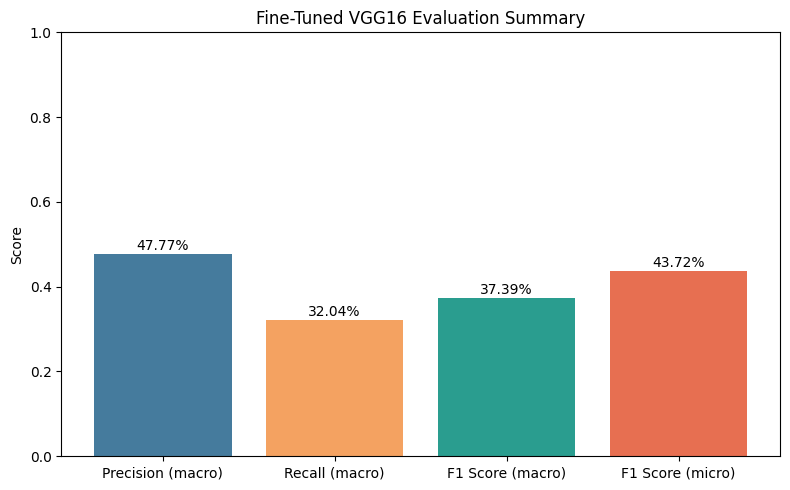

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# ⚠️ Replace with actual predictions and targets from test set
y_true_vgg, y_prob_vgg = get_predictions(vgg16, test_loader, device)
y_pred_vgg = (y_prob_vgg >= 0.5).astype(int)

# Compute scores
f1_micro = f1_score(y_true_vgg, y_pred_vgg, average='micro', zero_division=0)
f1_macro = f1_score(y_true_vgg, y_pred_vgg, average='macro', zero_division=0)
precision_macro = precision_score(y_true_vgg, y_pred_vgg, average='macro', zero_division=0)
recall_macro = recall_score(y_true_vgg, y_pred_vgg, average='macro', zero_division=0)

# Print raw scores
print(f"✅ F1 (micro): {f1_micro:.4f}")
print(f"✅ F1 (macro): {f1_macro:.4f}")
print(f"✅ Precision (macro): {precision_macro:.4f}")
print(f"✅ Recall (macro): {recall_macro:.4f}")

# Bar chart
labels = ["Precision (macro)", "Recall (macro)", "F1 Score (macro)", "F1 Score (micro)"]
scores = [precision_macro, recall_macro, f1_macro, f1_micro]
colors = ['#457b9d', '#f4a261', '#2a9d8f', '#e76f51']

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, scores, color=colors)
plt.ylim(0, 1)
plt.title("Fine-Tuned VGG16 Evaluation Summary")
plt.ylabel("Score")

# Annotate bars with %
for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f"{score*100:.2f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


#VGG Hyperparameter Tuning


🔁 Training with learning rate: 0.01


Epoch 1/5 ➝ Train Loss: 599028.4858 | Val Loss: 0.2942


Epoch 2/5 ➝ Train Loss: 39.7428 | Val Loss: 0.2935


Epoch 3/5 ➝ Train Loss: 129.5538 | Val Loss: 0.2935


Epoch 4/5 ➝ Train Loss: 0.2939 | Val Loss: 0.2935


Epoch 5/5 ➝ Train Loss: 938.7902 | Val Loss: 0.2936

🔁 Training with learning rate: 0.005


Epoch 1/5 ➝ Train Loss: 801.7918 | Val Loss: 0.2950


Epoch 2/5 ➝ Train Loss: 0.2982 | Val Loss: 0.2941


Epoch 3/5 ➝ Train Loss: 0.2966 | Val Loss: 0.2939


Epoch 4/5 ➝ Train Loss: 0.2959 | Val Loss: 0.2939


Epoch 5/5 ➝ Train Loss: 0.2956 | Val Loss: 0.2937

🔁 Training with learning rate: 0.001


Epoch 1/5 ➝ Train Loss: 0.3308 | Val Loss: 0.2888


Epoch 2/5 ➝ Train Loss: 0.2882 | Val Loss: 0.2855


Epoch 3/5 ➝ Train Loss: 0.2848 | Val Loss: 0.2930


Epoch 4/5 ➝ Train Loss: 0.2963 | Val Loss: 0.2940


Epoch 5/5 ➝ Train Loss: 0.2951 | Val Loss: 0.2939

🔁 Training with learning rate: 0.0005


Epoch 1/5 ➝ Train Loss: 0.2922 | Val Loss: 0.2775


Epoch 2/5 ➝ Train Loss: 0.2820 | Val Loss: 0.2776


Epoch 3/5 ➝ Train Loss: 0.2779 | Val Loss: 0.2679


Epoch 4/5 ➝ Train Loss: 0.2715 | Val Loss: 0.2681


Epoch 5/5 ➝ Train Loss: 0.2670 | Val Loss: 0.2607

🔁 Training with learning rate: 0.0001


Epoch 1/5 ➝ Train Loss: 0.2667 | Val Loss: 0.2482


Epoch 2/5 ➝ Train Loss: 0.2467 | Val Loss: 0.2496


Epoch 3/5 ➝ Train Loss: 0.2337 | Val Loss: 0.2364


Epoch 4/5 ➝ Train Loss: 0.2207 | Val Loss: 0.2403


Epoch 5/5 ➝ Train Loss: 0.2073 | Val Loss: 0.2378


<ipython-input-36-912a7bce7436>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Learning Rate', y='Final Val Loss', palette='Blues_d')
<ipython-input-36-912a7bce7436>:52: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


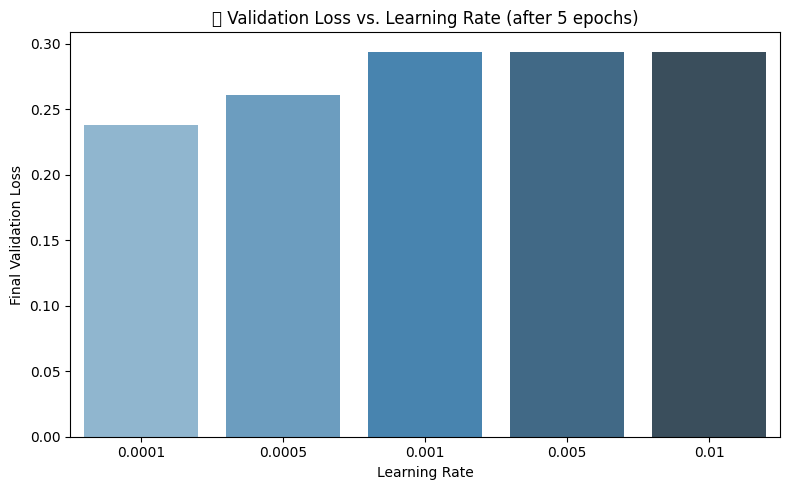

Learning Rate  Final Val Loss
4         0.0001        0.237815
3         0.0005        0.260682
0         0.0100        0.293591
1         0.0050        0.293670
2         0.0010        0.293884

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Candidate learning rates to try
learning_rates = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
num_epochs = 5
lr_results = []

for lr in learning_rates:
    print(f"\n🔁 Training with learning rate: {lr}")

    # Re-initialize VGG16 with fine-tuning
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    for param in model.features.parameters():
        param.requires_grad = True  # fine-tuning
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, NUM_CLASSES)
    )
    model = model.to(device)

    # Loss and optimizer setup
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train for a few epochs and log validation loss
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = evaluate(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{num_epochs} ➝ Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Store final validation loss
    lr_results.append((lr, val_loss))

# Summarize and plot results
results_df = pd.DataFrame(lr_results, columns=['Learning Rate', 'Final Val Loss']).sort_values('Final Val Loss')

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Learning Rate', y='Final Val Loss', palette='Blues_d')
plt.title("📉 Validation Loss vs. Learning Rate (after 5 epochs)")
plt.ylabel("Final Validation Loss")
plt.tight_layout()
plt.show()

display(results_df)
